In [ ]:
import pandas as pd

df = pd.read_csv('/content/Carbon_Emissions_Futures_2021_Onwards.csv')
df

Date  Price   Open   High    Low    Vol. Change %
0    2024-08-02  70.44  71.18  71.31  69.45  23.24K   -1.03%
1    2024-08-01  71.17  69.55  71.50  68.83  29.18K    2.79%
2    2024-07-31  69.24  68.95  69.44  68.04  20.38K    0.96%
3    2024-07-30  68.58  68.67  69.29  67.47  20.66K   -0.29%
4    2024-07-29  68.78  67.70  68.90  67.20  16.08K    1.58%
..          ...    ...    ...    ...    ...     ...      ...
919  2021-01-08  35.14  35.21  35.35  34.55   1.60K    0.49%
920  2021-01-07  34.97  34.05  35.00  34.05   1.17K    3.37%
921  2021-01-06  33.83  33.71  33.88  33.02   0.43K    2.05%
922  2021-01-05  33.15  33.69  33.83  32.96   1.28K   -2.18%
923  2021-01-04  33.89  33.14  34.45  33.14   1.25K    2.88%

[924 rows x 7 columns]

### RNN/LSTM/GRU/TCN + Quantile

In [ ]:
# Rewriting the provided RNN + Quantile code with improved MPIW minimization logic

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import itertools

# --- Set device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- Load & Preprocess ---
df = pd.read_csv("/content/Carbon_Emissions_Futures_2021_Onwards.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

def convert_volume(vol):
    try:
        if isinstance(vol, str):
            vol = vol.replace('K', '*1e3').replace('M', '*1e6')
            return eval(vol)
        return np.nan
    except:
        return np.nan

df['Vol.'] = df['Vol.'].apply(convert_volume)
df['Change %'] = df['Change %'].str.replace('%', '').astype(float)
df['Price_lag1'] = df['Price'].shift(1)
df['Vol_lag1'] = df['Vol.'].shift(1)
df['Change_lag1'] = df['Change %'].shift(1)
df.dropna(inplace=True)

features = ['Open', 'High', 'Low', 'Vol_lag1', 'Change_lag1', 'Price_lag1']
target = 'Price'

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_X.fit_transform(df[features])
y = scaler_y.fit_transform(df[[target]])

def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i - seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# --- RNN Model ---
class RNNQuantile(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

def quantile_loss(q, y, y_pred):
    e = y - y_pred
    return torch.mean(torch.max(q * e, (q - 1) * e))

def train_rnn_quantile(X_train, y_train, quantile, hidden_dim, num_layers, lr, epochs):
    model = RNNQuantile(X_train.shape[2], hidden_dim, num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)

    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train_t)
        loss = quantile_loss(quantile, y_train_t, y_pred)
        loss.backward()
        optimizer.step()
    return model

# --- Hyperparameter Grid ---
param_grid = {
    'seq_len': [1,2,3,4,5,6,7,8,9,10,12,16,20],
    'hidden_dim': [16,32,48,64],
    'num_layers': [1],
    'learning_rate': [0.005, 0.01, 0.02, 0.05],
    'epochs': [100]
}
target_coverage = 95

# --- Training Loop ---
valid_models = []

for values in itertools.product(*param_grid.values()):
    params = dict(zip(param_grid.keys(), values))
    print(f"\nTraining with params: {params}")

    X_seq, y_seq = create_sequences(X, y, seq_len=params['seq_len'])
    split = int(0.8 * len(X_seq))
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]
    y_test_rescaled = scaler_y.inverse_transform(y_test).flatten()

    lower_model = train_rnn_quantile(X_train, y_train, 0.025,
                                     params['hidden_dim'], params['num_layers'], params['learning_rate'], params['epochs'])
    upper_model = train_rnn_quantile(X_train, y_train, 0.975,
                                     params['hidden_dim'], params['num_layers'], params['learning_rate'], params['epochs'])

    X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
    lower_model.eval(); upper_model.eval()
    with torch.no_grad():
        pred_lower = lower_model(X_test_t).cpu().numpy()
        pred_upper = upper_model(X_test_t).cpu().numpy()

    pred_lower_rescaled = scaler_y.inverse_transform(pred_lower).flatten()
    pred_upper_rescaled = scaler_y.inverse_transform(pred_upper).flatten()
    median_pred = (pred_lower_rescaled + pred_upper_rescaled) / 2

    picp = np.mean((y_test_rescaled >= pred_lower_rescaled) & (y_test_rescaled <= pred_upper_rescaled)) * 100
    mpiw = np.mean(pred_upper_rescaled - pred_lower_rescaled)

    if picp >= target_coverage:
        print(f"✓ Accepted: PICP = {picp:.2f}% (≥ {target_coverage}) | MPIW = {mpiw:.4f}")
        valid_models.append((mpiw, params, pred_lower_rescaled, pred_upper_rescaled, median_pred, y_test_rescaled))
    else:
        print(f"✗ Rejected: PICP = {picp:.2f}% (< {target_coverage})")

# --- Select Best Model ---
if valid_models:
    valid_models.sort(key=lambda x: x[0])  # Sort by MPIW (minimize)
    _, best_params, pred_lower, pred_upper, median_pred, y_true = valid_models[0]
else:
    raise ValueError("No model met the target PICP threshold. Consider relaxing it.")

# --- Final Evaluation ---
mse = mean_squared_error(y_true, median_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, median_pred)
mape = np.mean(np.abs((y_true - median_pred) / y_true)) * 100
r2 = r2_score(y_true, median_pred)
picp = np.mean((y_true >= pred_lower) & (y_true <= pred_upper)) * 100
mpiw = np.mean(pred_upper - pred_lower)

print("\nBest Hyperparameters:", best_params)
print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R²: {r2:.4f}")
print(f"PICP: {picp:.2f}% | MPIW: {mpiw:.4f}")

# --- Plot ---
test_dates = df['Date'].iloc[-len(y_true):]
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_true, label='Actual', color='black')
plt.fill_between(test_dates, pred_lower, pred_upper, color='blue', alpha=0.3, label='Interval (2.5–97.5%)')
plt.plot(test_dates, median_pred, label='Median Prediction', color='blue')
plt.title('RNN + Quantile Forecasting (Best Model)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Using device: cuda

Training with params: {'seq_len': 1, 'hidden_dim': 16, 'num_layers': 1, 'learning_rate': 0.005, 'epochs': 100}
✓ Accepted: PICP = 98.36% (≥ 95) | MPIW = 36.6630

Training with params: {'seq_len': 1, 'hidden_dim': 16, 'num_layers': 1, 'learning_rate': 0.01, 'epochs': 100}
✓ Accepted: PICP = 97.81% (≥ 95) | MPIW = 24.6419

Training with params: {'seq_len': 1, 'hidden_dim': 16, 'num_layers': 1, 'learning_rate': 0.02, 'epochs': 100}
✓ Accepted: PICP = 97.27% (≥ 95) | MPIW = 21.7201

Training with params: {'seq_len': 1, 'hidden_dim': 16, 'num_layers': 1, 'learning_rate': 0.05, 'epochs': 100}
✓ Accepted: PICP = 100.00% (≥ 95) | MPIW = 63.0792

Training with params: {'seq_len': 1, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.005, 'epochs': 100}
✓ Accepted: PICP = 98.36% (≥ 95) | MPIW = 20.3946

Training with params: {'seq_len': 1, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.01, 'epochs': 100}
✓ Accepted: PICP = 98.36% (≥ 95) | MPIW = 13.0118

Training wi

Using device: cuda

Training with params: {'seq_len': 1, 'hidden_dim': 16, 'num_layers': 1, 'learning_rate': 0.005, 'epochs': 100}
✓ Accepted: PICP = 98.36% (≥ 95) | MPIW = 24.3287

Training with params: {'seq_len': 1, 'hidden_dim': 16, 'num_layers': 1, 'learning_rate': 0.01, 'epochs': 100}
✓ Accepted: PICP = 100.00% (≥ 95) | MPIW = 29.1729

Training with params: {'seq_len': 1, 'hidden_dim': 16, 'num_layers': 1, 'learning_rate': 0.02, 'epochs': 100}
✓ Accepted: PICP = 98.36% (≥ 95) | MPIW = 25.2885

Training with params: {'seq_len': 1, 'hidden_dim': 16, 'num_layers': 1, 'learning_rate': 0.05, 'epochs': 100}
✓ Accepted: PICP = 98.36% (≥ 95) | MPIW = 12.8555

Training with params: {'seq_len': 1, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.005, 'epochs': 100}
✓ Accepted: PICP = 99.45% (≥ 95) | MPIW = 29.7275

Training with params: {'seq_len': 1, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.01, 'epochs': 100}
✓ Accepted: PICP = 100.00% (≥ 95) | MPIW = 22.4073

Training w

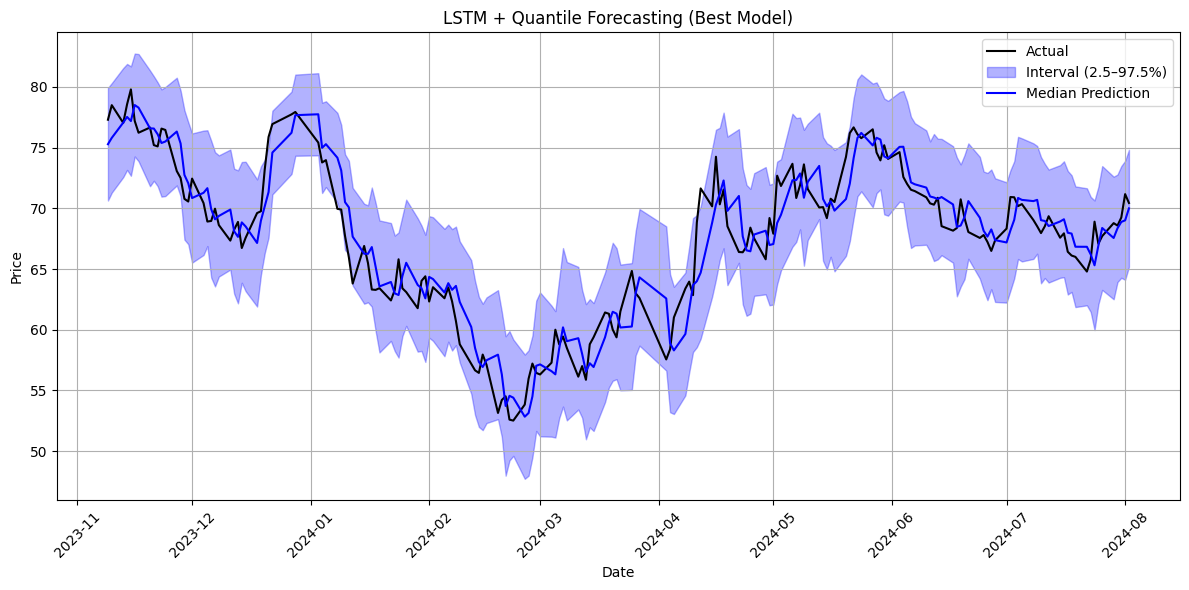

In [ ]:
# --- LSTM + Quantile Regression with MPIW minimization ---

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import itertools

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- Load & Preprocess ---
df = pd.read_csv("/content/Carbon_Emissions_Futures_2021_Onwards.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

def convert_volume(vol):
    try:
        if isinstance(vol, str):
            vol = vol.replace('K', '*1e3').replace('M', '*1e6')
            return eval(vol)
        return np.nan
    except:
        return np.nan

df['Vol.'] = df['Vol.'].apply(convert_volume)
df['Change %'] = df['Change %'].str.replace('%', '').astype(float)
df['Price_lag1'] = df['Price'].shift(1)
df['Vol_lag1'] = df['Vol.'].shift(1)
df['Change_lag1'] = df['Change %'].shift(1)
df.dropna(inplace=True)

features = ['Open', 'High', 'Low', 'Vol_lag1', 'Change_lag1', 'Price_lag1']
target = 'Price'

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_X.fit_transform(df[features])
y = scaler_y.fit_transform(df[[target]])

def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i - seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# --- LSTM Model ---
class LSTMQuantile(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

def quantile_loss(q, y, y_pred):
    e = y - y_pred
    return torch.mean(torch.max(q * e, (q - 1) * e))

def train_lstm_quantile(X_train, y_train, quantile, hidden_dim, num_layers, lr, epochs):
    model = LSTMQuantile(X_train.shape[2], hidden_dim, num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)

    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train_t)
        loss = quantile_loss(quantile, y_train_t, y_pred)
        loss.backward()
        optimizer.step()
    return model

# --- Hyperparameter Grid ---
param_grid = {
    'seq_len': [1,2,3,4,5,6,7,8,9,10,12,16,20],
    'hidden_dim': [16,32,48,64],
    'num_layers': [1],
    'learning_rate': [0.005, 0.01, 0.02, 0.05],
    'epochs': [100]
}
target_coverage = 95
valid_models = []

# --- Training Loop ---
for values in itertools.product(*param_grid.values()):
    params = dict(zip(param_grid.keys(), values))
    print(f"\nTraining with params: {params}")

    X_seq, y_seq = create_sequences(X, y, seq_len=params['seq_len'])
    split = int(0.8 * len(X_seq))
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]
    y_test_rescaled = scaler_y.inverse_transform(y_test).flatten()

    lower_model = train_lstm_quantile(X_train, y_train, 0.025,
                                      params['hidden_dim'], params['num_layers'], params['learning_rate'], params['epochs'])
    upper_model = train_lstm_quantile(X_train, y_train, 0.975,
                                      params['hidden_dim'], params['num_layers'], params['learning_rate'], params['epochs'])

    X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
    lower_model.eval(); upper_model.eval()
    with torch.no_grad():
        pred_lower = lower_model(X_test_t).cpu().numpy()
        pred_upper = upper_model(X_test_t).cpu().numpy()

    pred_lower_rescaled = scaler_y.inverse_transform(pred_lower).flatten()
    pred_upper_rescaled = scaler_y.inverse_transform(pred_upper).flatten()
    median_pred = (pred_lower_rescaled + pred_upper_rescaled) / 2

    picp = np.mean((y_test_rescaled >= pred_lower_rescaled) & (y_test_rescaled <= pred_upper_rescaled)) * 100
    mpiw = np.mean(pred_upper_rescaled - pred_lower_rescaled)

    if picp >= target_coverage:
        print(f"✓ Accepted: PICP = {picp:.2f}% (≥ {target_coverage}) | MPIW = {mpiw:.4f}")
        valid_models.append((mpiw, params, pred_lower_rescaled, pred_upper_rescaled, median_pred, y_test_rescaled))
    else:
        print(f"✗ Rejected: PICP = {picp:.2f}% (< {target_coverage})")

# --- Select Best Model ---
if valid_models:
    valid_models.sort(key=lambda x: x[0])  # sort by MPIW
    _, best_params, pred_lower, pred_upper, median_pred, y_true = valid_models[0]
else:
    raise ValueError("No model met the target PICP threshold.")

# --- Evaluation ---
mse = mean_squared_error(y_true, median_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, median_pred)
mape = np.mean(np.abs((y_true - median_pred) / y_true)) * 100
r2 = r2_score(y_true, median_pred)
picp = np.mean((y_true >= pred_lower) & (y_true <= pred_upper)) * 100
mpiw = np.mean(pred_upper - pred_lower)

print("\nBest Hyperparameters:", best_params)
print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R²: {r2:.4f}")
print(f"PICP: {picp:.2f}% | MPIW: {mpiw:.4f}")

# --- Plot ---
test_dates = df['Date'].iloc[-len(y_true):]
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_true, label='Actual', color='black')
plt.fill_between(test_dates, pred_lower, pred_upper, color='blue', alpha=0.3, label='Interval (2.5–97.5%)')
plt.plot(test_dates, median_pred, label='Median Prediction', color='blue')
plt.title('LSTM + Quantile Forecasting (Best Model)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# GRU + Quantile Regression with MPIW Minimization

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import itertools

# --- Set device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- Load & Preprocess ---
df = pd.read_csv("/content/Carbon_Emissions_Futures_2021_Onwards.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

def convert_volume(vol):
    try:
        if isinstance(vol, str):
            vol = vol.replace('K', '*1e3').replace('M', '*1e6')
            return eval(vol)
        return np.nan
    except:
        return np.nan

df['Vol.'] = df['Vol.'].apply(convert_volume)
df['Change %'] = df['Change %'].str.replace('%', '').astype(float)
df['Price_lag1'] = df['Price'].shift(1)
df['Vol_lag1'] = df['Vol.'].shift(1)
df['Change_lag1'] = df['Change %'].shift(1)
df.dropna(inplace=True)

features = ['Open', 'High', 'Low', 'Vol_lag1', 'Change_lag1', 'Price_lag1']
target = 'Price'

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_X.fit_transform(df[features])
y = scaler_y.fit_transform(df[[target]])

def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i - seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# --- GRU Model ---
class GRUQuantile(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

def quantile_loss(q, y, y_pred):
    e = y - y_pred
    return torch.mean(torch.max(q * e, (q - 1) * e))

def train_gru_quantile(X_train, y_train, quantile, hidden_dim, num_layers, lr, epochs):
    model = GRUQuantile(X_train.shape[2], hidden_dim, num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)

    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train_t)
        loss = quantile_loss(quantile, y_train_t, y_pred)
        loss.backward()
        optimizer.step()
    return model

# --- Hyperparameter Grid ---
param_grid = {
    'seq_len': [1,2,3,4,5,6,7,8,9,10,12,16,20],
    'hidden_dim': [16,32,48,64],
    'num_layers': [1],
    'learning_rate': [0.005, 0.01, 0.02, 0.05],
    'epochs': [100]
}
target_coverage = 95

# --- Training Loop ---
valid_models = []

for values in itertools.product(*param_grid.values()):
    params = dict(zip(param_grid.keys(), values))
    print(f"\nTraining with params: {params}")

    X_seq, y_seq = create_sequences(X, y, seq_len=params['seq_len'])
    split = int(0.8 * len(X_seq))
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]
    y_test_rescaled = scaler_y.inverse_transform(y_test).flatten()

    lower_model = train_gru_quantile(X_train, y_train, 0.025,
                                     params['hidden_dim'], params['num_layers'], params['learning_rate'], params['epochs'])
    upper_model = train_gru_quantile(X_train, y_train, 0.975,
                                     params['hidden_dim'], params['num_layers'], params['learning_rate'], params['epochs'])

    X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
    lower_model.eval(); upper_model.eval()
    with torch.no_grad():
        pred_lower = lower_model(X_test_t).cpu().numpy()
        pred_upper = upper_model(X_test_t).cpu().numpy()

    pred_lower_rescaled = scaler_y.inverse_transform(pred_lower).flatten()
    pred_upper_rescaled = scaler_y.inverse_transform(pred_upper).flatten()
    median_pred = (pred_lower_rescaled + pred_upper_rescaled) / 2

    picp = np.mean((y_test_rescaled >= pred_lower_rescaled) & (y_test_rescaled <= pred_upper_rescaled)) * 100
    mpiw = np.mean(pred_upper_rescaled - pred_lower_rescaled)

    if picp >= target_coverage:
        print(f"✓ Accepted: PICP = {picp:.2f}% (≥ {target_coverage}) | MPIW = {mpiw:.4f}")
        valid_models.append((mpiw, params, pred_lower_rescaled, pred_upper_rescaled, median_pred, y_test_rescaled))
    else:
        print(f"✗ Rejected: PICP = {picp:.2f}% (< {target_coverage})")

# --- Select Best Model ---
if valid_models:
    valid_models.sort(key=lambda x: x[0])  # Sort by MPIW (minimize)
    _, best_params, pred_lower, pred_upper, median_pred, y_true = valid_models[0]
else:
    raise ValueError("No model met the target PICP threshold. Consider relaxing it.")

# --- Final Evaluation ---
mse = mean_squared_error(y_true, median_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, median_pred)
mape = np.mean(np.abs((y_true - median_pred) / y_true)) * 100
r2 = r2_score(y_true, median_pred)
picp = np.mean((y_true >= pred_lower) & (y_true <= pred_upper)) * 100
mpiw = np.mean(pred_upper - pred_lower)

print("\nBest Hyperparameters:", best_params)
print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R²: {r2:.4f}")
print(f"PICP: {picp:.2f}% | MPIW: {mpiw:.4f}")

# --- Plot ---
test_dates = df['Date'].iloc[-len(y_true):]
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_true, label='Actual', color='black')
plt.fill_between(test_dates, pred_lower, pred_upper, color='blue', alpha=0.3, label='Interval (2.5–97.5%)')
plt.plot(test_dates, median_pred, label='Median Prediction', color='blue')
plt.title('GRU + Quantile Forecasting (Best Model)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Using device: cuda

Training with params: {'seq_len': 1, 'hidden_dim': 16, 'num_layers': 1, 'learning_rate': 0.005, 'epochs': 100}
✓ Accepted: PICP = 100.00% (≥ 95) | MPIW = 28.4408

Training with params: {'seq_len': 1, 'hidden_dim': 16, 'num_layers': 1, 'learning_rate': 0.01, 'epochs': 100}
✓ Accepted: PICP = 99.45% (≥ 95) | MPIW = 22.7206

Training with params: {'seq_len': 1, 'hidden_dim': 16, 'num_layers': 1, 'learning_rate': 0.02, 'epochs': 100}
✓ Accepted: PICP = 98.36% (≥ 95) | MPIW = 17.4378

Training with params: {'seq_len': 1, 'hidden_dim': 16, 'num_layers': 1, 'learning_rate': 0.05, 'epochs': 100}
✓ Accepted: PICP = 98.36% (≥ 95) | MPIW = 13.3395

Training with params: {'seq_len': 1, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.005, 'epochs': 100}
✓ Accepted: PICP = 99.45% (≥ 95) | MPIW = 18.2981

Training with params: {'seq_len': 1, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.01, 'epochs': 100}
✓ Accepted: PICP = 97.81% (≥ 95) | MPIW = 16.0764

Training wi

In [ ]:
# TCN + Quantile Regression with MPIW Minimization

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import itertools

# --- Set device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- Load & Preprocess ---
df = pd.read_csv("/content/Carbon_Emissions_Futures_2021_Onwards.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

def convert_volume(vol):
    try:
        if isinstance(vol, str):
            vol = vol.replace('K', '*1e3').replace('M', '*1e6')
            return eval(vol)
        return np.nan
    except:
        return np.nan

df['Vol.'] = df['Vol.'].apply(convert_volume)
df['Change %'] = df['Change %'].str.replace('%', '').astype(float)
df['Price_lag1'] = df['Price'].shift(1)
df['Vol_lag1'] = df['Vol.'].shift(1)
df['Change_lag1'] = df['Change %'].shift(1)
df.dropna(inplace=True)

features = ['Open', 'High', 'Low', 'Vol_lag1', 'Change_lag1', 'Price_lag1']
target = 'Price'

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_X.fit_transform(df[features])
y = scaler_y.fit_transform(df[[target]])

def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i - seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# --- TCN Model ---
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size]

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, padding, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, padding=padding, dilation=dilation),
            Chomp1d(padding),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=padding, dilation=dilation),
            Chomp1d(padding),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCNQuantile(nn.Module):
    def __init__(self, input_size, num_channels, kernel_size=2, dropout=0.2):
        super().__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_ch = input_size if i == 0 else num_channels[i-1]
            out_ch = num_channels[i]
            layers.append(TemporalBlock(in_ch, out_ch, kernel_size, dilation_size, (kernel_size-1)*dilation_size, dropout))
        self.tcn = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, seq_len)
        out = self.tcn(x)
        out = out[:, :, -1]  # last time step
        return self.linear(out)

def quantile_loss(q, y, y_pred):
    e = y - y_pred
    return torch.mean(torch.max(q * e, (q - 1) * e))

def train_tcn_quantile(X_train, y_train, quantile, num_channels, lr, epochs):
    model = TCNQuantile(X_train.shape[2], num_channels).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)

    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train_t)
        loss = quantile_loss(quantile, y_train_t, y_pred)
        loss.backward()
        optimizer.step()
    return model

# --- Hyperparameter Grid ---
param_grid = {
    'seq_len': [1,2,3,4,5,6,7,8,9,10,12,15,16,20],
    'num_channels': [[16, 32], [32, 64], [64, 64], [16,16], [32,32]],  # TCN-specific
    'learning_rate': [0.005, 0.01],
    'epochs': [100]
}
target_coverage = 95

# --- Training Loop ---
valid_models = []

for values in itertools.product(*param_grid.values()):
    params = dict(zip(param_grid.keys(), values))
    print(f"\nTraining with params: {params}")

    X_seq, y_seq = create_sequences(X, y, seq_len=params['seq_len'])
    split = int(0.8 * len(X_seq))
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]
    y_test_rescaled = scaler_y.inverse_transform(y_test).flatten()

    lower_model = train_tcn_quantile(X_train, y_train, 0.025,
                                     params['num_channels'], params['learning_rate'], params['epochs'])
    upper_model = train_tcn_quantile(X_train, y_train, 0.975,
                                     params['num_channels'], params['learning_rate'], params['epochs'])

    X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
    lower_model.eval(); upper_model.eval()
    with torch.no_grad():
        pred_lower = lower_model(X_test_t).cpu().numpy()
        pred_upper = upper_model(X_test_t).cpu().numpy()

    pred_lower_rescaled = scaler_y.inverse_transform(pred_lower).flatten()
    pred_upper_rescaled = scaler_y.inverse_transform(pred_upper).flatten()
    median_pred = (pred_lower_rescaled + pred_upper_rescaled) / 2

    picp = np.mean((y_test_rescaled >= pred_lower_rescaled) & (y_test_rescaled <= pred_upper_rescaled)) * 100
    mpiw = np.mean(pred_upper_rescaled - pred_lower_rescaled)

    if picp >= target_coverage:
        print(f"✓ Accepted: PICP = {picp:.2f}% (≥ {target_coverage}) | MPIW = {mpiw:.4f}")
        valid_models.append((mpiw, params, pred_lower_rescaled, pred_upper_rescaled, median_pred, y_test_rescaled))
    else:
        print(f"✗ Rejected: PICP = {picp:.2f}% (< {target_coverage})")

# --- Select Best Model ---
if valid_models:
    valid_models.sort(key=lambda x: x[0])  # Sort by MPIW (minimize)
    _, best_params, pred_lower, pred_upper, median_pred, y_true = valid_models[0]
else:
    raise ValueError("No model met the target PICP threshold. Consider relaxing it.")

# --- Final Evaluation ---
mse = mean_squared_error(y_true, median_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, median_pred)
mape = np.mean(np.abs((y_true - median_pred) / y_true)) * 100
r2 = r2_score(y_true, median_pred)
picp = np.mean((y_true >= pred_lower) & (y_true <= pred_upper)) * 100
mpiw = np.mean(pred_upper - pred_lower)

print("\nBest Hyperparameters:", best_params)
print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R²: {r2:.4f}")
print(f"PICP: {picp:.2f}% | MPIW: {mpiw:.4f}")

# --- Plot ---
test_dates = df['Date'].iloc[-len(y_true):]
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_true, label='Actual', color='black')
plt.fill_between(test_dates, pred_lower, pred_upper, color='blue', alpha=0.3, label='Interval (2.5–97.5%)')
plt.plot(test_dates, median_pred, label='Median Prediction', color='blue')
plt.title('TCN + Quantile Forecasting (Best Model)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Using device: cuda

Training with params: {'seq_len': 1, 'num_channels': [16, 32], 'learning_rate': 0.005, 'epochs': 100}
✓ Accepted: PICP = 100.00% (≥ 95) | MPIW = 18.3850

Training with params: {'seq_len': 1, 'num_channels': [16, 32], 'learning_rate': 0.01, 'epochs': 100}
✓ Accepted: PICP = 98.91% (≥ 95) | MPIW = 11.6760

Training with params: {'seq_len': 1, 'num_channels': [32, 64], 'learning_rate': 0.005, 'epochs': 100}
✓ Accepted: PICP = 100.00% (≥ 95) | MPIW = 14.3754

Training with params: {'seq_len': 1, 'num_channels': [32, 64], 'learning_rate': 0.01, 'epochs': 100}
✓ Accepted: PICP = 98.91% (≥ 95) | MPIW = 11.8330

Training with params: {'seq_len': 1, 'num_channels': [64, 64], 'learning_rate': 0.005, 'epochs': 100}
✓ Accepted: PICP = 100.00% (≥ 95) | MPIW = 16.2991

Training with params: {'seq_len': 1, 'num_channels': [64, 64], 'learning_rate': 0.01, 'epochs': 100}
✓ Accepted: PICP = 98.91% (≥ 95) | MPIW = 11.8863

Training with params: {'seq_len': 1, 'num_channels': [16, 16],

### GRU/LSTM/RNN + CNN

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# ---------- Use GPU if available ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------- Load & Preprocess ----------
df = pd.read_csv("/content/Carbon_Emissions_Futures_2021_Onwards.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

def convert_volume(vol_str):
    try:
        if isinstance(vol_str, str):
            vol_str = vol_str.replace('K', '*1e3').replace('M', '*1e6')
            return eval(vol_str)
        return np.nan
    except:
        return np.nan

df['Vol.'] = df['Vol.'].apply(convert_volume)
df['Change %'] = df['Change %'].str.replace('%', '').astype(float)
df['Price_lag1'] = df['Price'].shift(1)
df['Vol_lag1'] = df['Vol.'].shift(1)
df['Change_lag1'] = df['Change %'].shift(1)
df = df.dropna().reset_index(drop=True)

features = ['Open', 'High', 'Low', 'Vol_lag1', 'Change_lag1', 'Price_lag1']
target = 'Price'

# ---------- Scaling ----------
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_X.fit_transform(df[features])
y = scaler_y.fit_transform(df[[target]])

# ---------- Sequence Creation ----------
def create_sequences(X, y, seq_len=20):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i - seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# ---------- CNN + GRU Model Definition ----------
class CNNGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_size=3, gru_layers=1, dropout=0.2):
        super(CNNGRU, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, hidden_dim, kernel_size=kernel_size, padding=kernel_size//2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_dim, hidden_dim, gru_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # [B, F, T] -> [B, C, T]
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = x.permute(0, 2, 1)  # [B, T, C]
        x, _ = self.gru(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x

# ---------- Training & Evaluation Functions ----------
def train(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for x_batch, y_batch in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    all_preds, all_true = [], []
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)
            output = model(x_batch)
            all_preds.append(output.cpu().numpy())
            all_true.append(y_batch.cpu().numpy())
    return np.concatenate(all_true), np.concatenate(all_preds)

# ---------- Hyperparameter Grid Search ----------
param_grid = {
    'seq_len': [4, 8, 12, 16, 20],
    'hidden_dim': [64, 128],
    'learning_rate': [0.001, 0.005],
    'epochs': [50]
}

best_params = None
best_rmse = float('inf')
best_model = None

for seq_len in param_grid['seq_len']:
    for hidden_dim in param_grid['hidden_dim']:
        for lr in param_grid['learning_rate']:
            for epochs in param_grid['epochs']:
                print(f"\nTraining CNN + GRU with seq_len={seq_len}, hidden_dim={hidden_dim}, lr={lr}, epochs={epochs}")
                X_seq, y_seq = create_sequences(X, y, seq_len=seq_len)

                split_idx = int(np.where(df['Date'] >= '2024-01-01')[0][0]) - seq_len
                X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
                y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

                X_train_t = torch.tensor(X_train, dtype=torch.float32)
                y_train_t = torch.tensor(y_train, dtype=torch.float32)
                X_test_t = torch.tensor(X_test, dtype=torch.float32)
                y_test_t = torch.tensor(y_test, dtype=torch.float32)

                train_data = TensorDataset(X_train_t, y_train_t)
                test_data = TensorDataset(X_test_t, y_test_t)
                train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
                test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

                model = CNNGRU(input_dim=X_train.shape[2], hidden_dim=hidden_dim, output_dim=1).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)
                criterion = nn.MSELoss()

                for epoch in range(epochs):
                    loss = train(model, train_loader, criterion, optimizer)
                    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")

                y_true, y_pred = evaluate(model, test_loader)
                mse = mean_squared_error(y_true, y_pred)
                rmse = np.sqrt(mse)

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = {
                        'seq_len': seq_len,
                        'hidden_dim': hidden_dim,
                        'learning_rate': lr,
                        'epochs': epochs
                    }
                    best_model = model
                    best_pred = y_pred
                    best_y_true = y_true

# ---------- Final Evaluation ----------
# Inverse transform the scaled values to original scale
best_y_true_orig = scaler_y.inverse_transform(best_y_true.reshape(-1, 1))
best_pred_orig = scaler_y.inverse_transform(best_pred.reshape(-1, 1))

# Now calculate metrics on original scale
mse = mean_squared_error(best_y_true_orig, best_pred_orig)
rmse = np.sqrt(mse)
mae = mean_absolute_error(best_y_true_orig, best_pred_orig)
mape = np.mean(np.abs((best_y_true_orig - best_pred_orig) / best_y_true_orig)) * 100
r2 = r2_score(best_y_true_orig, best_pred_orig)

print(f"MSE (original scale): {mse:.4f}")
print(f"RMSE (original scale): {rmse:.4f}")
print(f"MAE (original scale): {mae:.4f}")
print(f"MAPE (original scale): {mape:.2f}%")
print(f"R² (original scale): {r2:.4f}")


# ---------- Plot ----------
test_dates = df['Date'].iloc[-len(best_y_true):]
plt.figure(figsize=(14, 6))
plt.plot(test_dates, scaler_y.inverse_transform(best_y_true.reshape(-1, 1)), label='Actual', color='black')
plt.plot(test_dates, scaler_y.inverse_transform(best_pred.reshape(-1, 1)), label='Predicted', color='green')
plt.title(f"CNN + GRU Forecast (Best Model: {best_params})")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Using device: cuda

Training CNN + GRU with seq_len=4, hidden_dim=64, lr=0.001, epochs=50
Epoch 1/50, Loss: 0.1998


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 2/50, Loss: 0.0354
Epoch 3/50, Loss: 0.0123
Epoch 4/50, Loss: 0.0080
Epoch 5/50, Loss: 0.0069
Epoch 6/50, Loss: 0.0051
Epoch 7/50, Loss: 0.0059
Epoch 8/50, Loss: 0.0056
Epoch 9/50, Loss: 0.0050
Epoch 10/50, Loss: 0.0046
Epoch 11/50, Loss: 0.0047
Epoch 12/50, Loss: 0.0045
Epoch 13/50, Loss: 0.0043
Epoch 14/50, Loss: 0.0042
Epoch 15/50, Loss: 0.0042
Epoch 16/50, Loss: 0.0041
Epoch 17/50, Loss: 0.0039
Epoch 18/50, Loss: 0.0040
Epoch 19/50, Loss: 0.0038
Epoch 20/50, Loss: 0.0035
Epoch 21/50, Loss: 0.0037
Epoch 22/50, Loss: 0.0037
Epoch 23/50, Loss: 0.0037
Epoch 24/50, Loss: 0.0031
Epoch 25/50, Loss: 0.0034
Epoch 26/50, Loss: 0.0033
Epoch 27/50, Loss: 0.0033
Epoch 28/50, Loss: 0.0032
Epoch 29/50, Loss: 0.0030
Epoch 30/50, Loss: 0.0032
Epoch 31/50, Loss: 0.0029
Epoch 32/50, Loss: 0.0028
Epoch 33/50, Loss: 0.0031
Epoch 34/50, Loss: 0.0029
Epoch 35/50, Loss: 0.0028
Epoch 36/50, Loss: 0.0027
Epoch 37/50, Loss: 0.0025
Epoch 38/50, Loss: 0.0025
Epoch 39/50, Loss: 0.0026
Epoch 40/50, Loss: 0

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 3/50, Loss: 0.0072
Epoch 4/50, Loss: 0.0059
Epoch 5/50, Loss: 0.0048
Epoch 6/50, Loss: 0.0051
Epoch 7/50, Loss: 0.0040
Epoch 8/50, Loss: 0.0042
Epoch 9/50, Loss: 0.0037
Epoch 10/50, Loss: 0.0038
Epoch 11/50, Loss: 0.0035
Epoch 12/50, Loss: 0.0035
Epoch 13/50, Loss: 0.0032
Epoch 14/50, Loss: 0.0034
Epoch 15/50, Loss: 0.0033
Epoch 16/50, Loss: 0.0033
Epoch 17/50, Loss: 0.0031
Epoch 18/50, Loss: 0.0032
Epoch 19/50, Loss: 0.0032
Epoch 20/50, Loss: 0.0027
Epoch 21/50, Loss: 0.0029
Epoch 22/50, Loss: 0.0031
Epoch 23/50, Loss: 0.0033
Epoch 24/50, Loss: 0.0027
Epoch 25/50, Loss: 0.0028
Epoch 26/50, Loss: 0.0028
Epoch 27/50, Loss: 0.0027
Epoch 28/50, Loss: 0.0030
Epoch 29/50, Loss: 0.0027
Epoch 30/50, Loss: 0.0025
Epoch 31/50, Loss: 0.0028
Epoch 32/50, Loss: 0.0025
Epoch 33/50, Loss: 0.0026
Epoch 34/50, Loss: 0.0026
Epoch 35/50, Loss: 0.0025
Epoch 36/50, Loss: 0.0027
Epoch 37/50, Loss: 0.0025
Epoch 38/50, Loss: 0.0025
Epoch 39/50, Loss: 0.0024
Epoch 40/50, Loss: 0.0024
Epoch 41/50, Loss: 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/50, Loss: 0.0784
Epoch 2/50, Loss: 0.0149
Epoch 3/50, Loss: 0.0055
Epoch 4/50, Loss: 0.0039
Epoch 5/50, Loss: 0.0033
Epoch 6/50, Loss: 0.0031
Epoch 7/50, Loss: 0.0030
Epoch 8/50, Loss: 0.0029
Epoch 9/50, Loss: 0.0028
Epoch 10/50, Loss: 0.0029
Epoch 11/50, Loss: 0.0028
Epoch 12/50, Loss: 0.0027
Epoch 13/50, Loss: 0.0026
Epoch 14/50, Loss: 0.0025
Epoch 15/50, Loss: 0.0026
Epoch 16/50, Loss: 0.0027
Epoch 17/50, Loss: 0.0024
Epoch 18/50, Loss: 0.0024
Epoch 19/50, Loss: 0.0025
Epoch 20/50, Loss: 0.0023
Epoch 21/50, Loss: 0.0024
Epoch 22/50, Loss: 0.0025
Epoch 23/50, Loss: 0.0022
Epoch 24/50, Loss: 0.0023
Epoch 25/50, Loss: 0.0022
Epoch 26/50, Loss: 0.0023
Epoch 27/50, Loss: 0.0025
Epoch 28/50, Loss: 0.0023
Epoch 29/50, Loss: 0.0023
Epoch 30/50, Loss: 0.0023
Epoch 31/50, Loss: 0.0023
Epoch 32/50, Loss: 0.0021
Epoch 33/50, Loss: 0.0021
Epoch 34/50, Loss: 0.0021
Epoch 35/50, Loss: 0.0023
Epoch 36/50, Loss: 0.0022
Epoch 37/50, Loss: 0.0023
Epoch 38/50, Loss: 0.0021
Epoch 39/50, Loss: 0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 2/50, Loss: 0.0062
Epoch 3/50, Loss: 0.0044
Epoch 4/50, Loss: 0.0036
Epoch 5/50, Loss: 0.0030
Epoch 6/50, Loss: 0.0030
Epoch 7/50, Loss: 0.0027
Epoch 8/50, Loss: 0.0029
Epoch 9/50, Loss: 0.0026
Epoch 10/50, Loss: 0.0025
Epoch 11/50, Loss: 0.0025
Epoch 12/50, Loss: 0.0026
Epoch 13/50, Loss: 0.0024
Epoch 14/50, Loss: 0.0022
Epoch 15/50, Loss: 0.0024
Epoch 16/50, Loss: 0.0025
Epoch 17/50, Loss: 0.0022
Epoch 18/50, Loss: 0.0026
Epoch 19/50, Loss: 0.0025
Epoch 20/50, Loss: 0.0025
Epoch 21/50, Loss: 0.0025
Epoch 22/50, Loss: 0.0020
Epoch 23/50, Loss: 0.0022
Epoch 24/50, Loss: 0.0021
Epoch 25/50, Loss: 0.0020
Epoch 26/50, Loss: 0.0024
Epoch 27/50, Loss: 0.0021
Epoch 28/50, Loss: 0.0022
Epoch 29/50, Loss: 0.0022
Epoch 30/50, Loss: 0.0020
Epoch 31/50, Loss: 0.0024
Epoch 32/50, Loss: 0.0020
Epoch 33/50, Loss: 0.0022
Epoch 34/50, Loss: 0.0023
Epoch 35/50, Loss: 0.0021
Epoch 36/50, Loss: 0.0019
Epoch 37/50, Loss: 0.0020
Epoch 38/50, Loss: 0.0020
Epoch 39/50, Loss: 0.0021
Epoch 40/50, Loss: 0

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 2/50, Loss: 0.0241
Epoch 3/50, Loss: 0.0108
Epoch 4/50, Loss: 0.0051
Epoch 5/50, Loss: 0.0041
Epoch 6/50, Loss: 0.0038
Epoch 7/50, Loss: 0.0036
Epoch 8/50, Loss: 0.0034
Epoch 9/50, Loss: 0.0035
Epoch 10/50, Loss: 0.0032
Epoch 11/50, Loss: 0.0033
Epoch 12/50, Loss: 0.0031
Epoch 13/50, Loss: 0.0029
Epoch 14/50, Loss: 0.0029
Epoch 15/50, Loss: 0.0031
Epoch 16/50, Loss: 0.0033
Epoch 17/50, Loss: 0.0029
Epoch 18/50, Loss: 0.0029
Epoch 19/50, Loss: 0.0028
Epoch 20/50, Loss: 0.0028
Epoch 21/50, Loss: 0.0028
Epoch 22/50, Loss: 0.0028
Epoch 23/50, Loss: 0.0027
Epoch 24/50, Loss: 0.0028
Epoch 25/50, Loss: 0.0025
Epoch 26/50, Loss: 0.0026
Epoch 27/50, Loss: 0.0027
Epoch 28/50, Loss: 0.0024
Epoch 29/50, Loss: 0.0025
Epoch 30/50, Loss: 0.0027
Epoch 31/50, Loss: 0.0027
Epoch 32/50, Loss: 0.0026
Epoch 33/50, Loss: 0.0026
Epoch 34/50, Loss: 0.0027
Epoch 35/50, Loss: 0.0026
Epoch 36/50, Loss: 0.0025
Epoch 37/50, Loss: 0.0024
Epoch 38/50, Loss: 0.0024
Epoch 39/50, Loss: 0.0024
Epoch 40/50, Loss: 0

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 6/50, Loss: 0.0034
Epoch 7/50, Loss: 0.0031
Epoch 8/50, Loss: 0.0033
Epoch 9/50, Loss: 0.0031
Epoch 10/50, Loss: 0.0031
Epoch 11/50, Loss: 0.0029
Epoch 12/50, Loss: 0.0029
Epoch 13/50, Loss: 0.0028
Epoch 14/50, Loss: 0.0027
Epoch 15/50, Loss: 0.0029
Epoch 16/50, Loss: 0.0028
Epoch 17/50, Loss: 0.0027
Epoch 18/50, Loss: 0.0026
Epoch 19/50, Loss: 0.0029
Epoch 20/50, Loss: 0.0026
Epoch 21/50, Loss: 0.0026
Epoch 22/50, Loss: 0.0028
Epoch 23/50, Loss: 0.0025
Epoch 24/50, Loss: 0.0024
Epoch 25/50, Loss: 0.0024
Epoch 26/50, Loss: 0.0024
Epoch 27/50, Loss: 0.0022
Epoch 28/50, Loss: 0.0020
Epoch 29/50, Loss: 0.0026
Epoch 30/50, Loss: 0.0025
Epoch 31/50, Loss: 0.0030
Epoch 32/50, Loss: 0.0022
Epoch 33/50, Loss: 0.0021
Epoch 34/50, Loss: 0.0024
Epoch 35/50, Loss: 0.0022
Epoch 36/50, Loss: 0.0024
Epoch 37/50, Loss: 0.0024
Epoch 38/50, Loss: 0.0023
Epoch 39/50, Loss: 0.0021
Epoch 40/50, Loss: 0.0020
Epoch 41/50, Loss: 0.0025
Epoch 42/50, Loss: 0.0030
Epoch 43/50, Loss: 0.0026
Epoch 44/50, Los

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 3/50, Loss: 0.0065
Epoch 4/50, Loss: 0.0045
Epoch 5/50, Loss: 0.0037
Epoch 6/50, Loss: 0.0033
Epoch 7/50, Loss: 0.0032
Epoch 8/50, Loss: 0.0030
Epoch 9/50, Loss: 0.0028
Epoch 10/50, Loss: 0.0028
Epoch 11/50, Loss: 0.0028
Epoch 12/50, Loss: 0.0025
Epoch 13/50, Loss: 0.0026
Epoch 14/50, Loss: 0.0024
Epoch 15/50, Loss: 0.0025
Epoch 16/50, Loss: 0.0024
Epoch 17/50, Loss: 0.0025
Epoch 18/50, Loss: 0.0023
Epoch 19/50, Loss: 0.0023
Epoch 20/50, Loss: 0.0023
Epoch 21/50, Loss: 0.0023
Epoch 22/50, Loss: 0.0023
Epoch 23/50, Loss: 0.0023
Epoch 24/50, Loss: 0.0023
Epoch 25/50, Loss: 0.0021
Epoch 26/50, Loss: 0.0020
Epoch 27/50, Loss: 0.0018
Epoch 28/50, Loss: 0.0022
Epoch 29/50, Loss: 0.0019
Epoch 30/50, Loss: 0.0021
Epoch 31/50, Loss: 0.0021
Epoch 32/50, Loss: 0.0020
Epoch 33/50, Loss: 0.0021
Epoch 34/50, Loss: 0.0020
Epoch 35/50, Loss: 0.0021
Epoch 36/50, Loss: 0.0019
Epoch 37/50, Loss: 0.0022
Epoch 38/50, Loss: 0.0023
Epoch 39/50, Loss: 0.0020
Epoch 40/50, Loss: 0.0018
Epoch 41/50, Loss: 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/50, Loss: 0.0639
Epoch 2/50, Loss: 0.0098
Epoch 3/50, Loss: 0.0051
Epoch 4/50, Loss: 0.0041
Epoch 5/50, Loss: 0.0040
Epoch 6/50, Loss: 0.0035
Epoch 7/50, Loss: 0.0032
Epoch 8/50, Loss: 0.0033
Epoch 9/50, Loss: 0.0033
Epoch 10/50, Loss: 0.0028
Epoch 11/50, Loss: 0.0032
Epoch 12/50, Loss: 0.0029
Epoch 13/50, Loss: 0.0028
Epoch 14/50, Loss: 0.0028
Epoch 15/50, Loss: 0.0028
Epoch 16/50, Loss: 0.0028
Epoch 17/50, Loss: 0.0029
Epoch 18/50, Loss: 0.0027
Epoch 19/50, Loss: 0.0025
Epoch 20/50, Loss: 0.0026
Epoch 21/50, Loss: 0.0023
Epoch 22/50, Loss: 0.0022
Epoch 23/50, Loss: 0.0024
Epoch 24/50, Loss: 0.0023
Epoch 25/50, Loss: 0.0025
Epoch 26/50, Loss: 0.0030
Epoch 27/50, Loss: 0.0023
Epoch 28/50, Loss: 0.0026
Epoch 29/50, Loss: 0.0023
Epoch 30/50, Loss: 0.0022
Epoch 31/50, Loss: 0.0020
Epoch 32/50, Loss: 0.0022
Epoch 33/50, Loss: 0.0022
Epoch 34/50, Loss: 0.0021
Epoch 35/50, Loss: 0.0021
Epoch 36/50, Loss: 0.0019
Epoch 37/50, Loss: 0.0020
Epoch 38/50, Loss: 0.0020
Epoch 39/50, Loss: 0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 4/50, Loss: 0.0058
Epoch 5/50, Loss: 0.0049
Epoch 6/50, Loss: 0.0046
Epoch 7/50, Loss: 0.0040
Epoch 8/50, Loss: 0.0037
Epoch 9/50, Loss: 0.0034
Epoch 10/50, Loss: 0.0036
Epoch 11/50, Loss: 0.0037
Epoch 12/50, Loss: 0.0034
Epoch 13/50, Loss: 0.0036
Epoch 14/50, Loss: 0.0033
Epoch 15/50, Loss: 0.0032
Epoch 16/50, Loss: 0.0033
Epoch 17/50, Loss: 0.0031
Epoch 18/50, Loss: 0.0031
Epoch 19/50, Loss: 0.0029
Epoch 20/50, Loss: 0.0029
Epoch 21/50, Loss: 0.0026
Epoch 22/50, Loss: 0.0029
Epoch 23/50, Loss: 0.0030
Epoch 24/50, Loss: 0.0026
Epoch 25/50, Loss: 0.0025
Epoch 26/50, Loss: 0.0025
Epoch 27/50, Loss: 0.0027
Epoch 28/50, Loss: 0.0023
Epoch 29/50, Loss: 0.0027
Epoch 30/50, Loss: 0.0024
Epoch 31/50, Loss: 0.0023
Epoch 32/50, Loss: 0.0023
Epoch 33/50, Loss: 0.0025
Epoch 34/50, Loss: 0.0025
Epoch 35/50, Loss: 0.0022
Epoch 36/50, Loss: 0.0023
Epoch 37/50, Loss: 0.0022
Epoch 38/50, Loss: 0.0022
Epoch 39/50, Loss: 0.0023
Epoch 40/50, Loss: 0.0022
Epoch 41/50, Loss: 0.0022
Epoch 42/50, Loss:

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 2/50, Loss: 0.0085
Epoch 3/50, Loss: 0.0059
Epoch 4/50, Loss: 0.0045
Epoch 5/50, Loss: 0.0043
Epoch 6/50, Loss: 0.0044
Epoch 7/50, Loss: 0.0036
Epoch 8/50, Loss: 0.0037
Epoch 9/50, Loss: 0.0033
Epoch 10/50, Loss: 0.0034
Epoch 11/50, Loss: 0.0031
Epoch 12/50, Loss: 0.0032
Epoch 13/50, Loss: 0.0031
Epoch 14/50, Loss: 0.0032
Epoch 15/50, Loss: 0.0033
Epoch 16/50, Loss: 0.0031
Epoch 17/50, Loss: 0.0029
Epoch 18/50, Loss: 0.0030
Epoch 19/50, Loss: 0.0026
Epoch 20/50, Loss: 0.0026
Epoch 21/50, Loss: 0.0027
Epoch 22/50, Loss: 0.0026
Epoch 23/50, Loss: 0.0030
Epoch 24/50, Loss: 0.0028
Epoch 25/50, Loss: 0.0026
Epoch 26/50, Loss: 0.0024
Epoch 27/50, Loss: 0.0023
Epoch 28/50, Loss: 0.0022
Epoch 29/50, Loss: 0.0028
Epoch 30/50, Loss: 0.0022
Epoch 31/50, Loss: 0.0022
Epoch 32/50, Loss: 0.0022
Epoch 33/50, Loss: 0.0022
Epoch 34/50, Loss: 0.0022
Epoch 35/50, Loss: 0.0024
Epoch 36/50, Loss: 0.0026
Epoch 37/50, Loss: 0.0021
Epoch 38/50, Loss: 0.0022
Epoch 39/50, Loss: 0.0020
Epoch 40/50, Loss: 0

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 6/50, Loss: 0.0034
Epoch 7/50, Loss: 0.0030
Epoch 8/50, Loss: 0.0031
Epoch 9/50, Loss: 0.0030
Epoch 10/50, Loss: 0.0030
Epoch 11/50, Loss: 0.0031
Epoch 12/50, Loss: 0.0028
Epoch 13/50, Loss: 0.0029
Epoch 14/50, Loss: 0.0030
Epoch 15/50, Loss: 0.0029
Epoch 16/50, Loss: 0.0028
Epoch 17/50, Loss: 0.0027
Epoch 18/50, Loss: 0.0026
Epoch 19/50, Loss: 0.0026
Epoch 20/50, Loss: 0.0024
Epoch 21/50, Loss: 0.0026
Epoch 22/50, Loss: 0.0025
Epoch 23/50, Loss: 0.0025
Epoch 24/50, Loss: 0.0022
Epoch 25/50, Loss: 0.0024
Epoch 26/50, Loss: 0.0022
Epoch 27/50, Loss: 0.0024
Epoch 28/50, Loss: 0.0024
Epoch 29/50, Loss: 0.0023
Epoch 30/50, Loss: 0.0022
Epoch 31/50, Loss: 0.0021
Epoch 32/50, Loss: 0.0021
Epoch 33/50, Loss: 0.0023
Epoch 34/50, Loss: 0.0022
Epoch 35/50, Loss: 0.0024
Epoch 36/50, Loss: 0.0022
Epoch 37/50, Loss: 0.0020
Epoch 38/50, Loss: 0.0021
Epoch 39/50, Loss: 0.0021
Epoch 40/50, Loss: 0.0021
Epoch 41/50, Loss: 0.0021
Epoch 42/50, Loss: 0.0019
Epoch 43/50, Loss: 0.0019
Epoch 44/50, Los

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/50, Loss: 0.0712
Epoch 2/50, Loss: 0.0077
Epoch 3/50, Loss: 0.0062
Epoch 4/50, Loss: 0.0045
Epoch 5/50, Loss: 0.0035
Epoch 6/50, Loss: 0.0035
Epoch 7/50, Loss: 0.0031
Epoch 8/50, Loss: 0.0031
Epoch 9/50, Loss: 0.0029
Epoch 10/50, Loss: 0.0026
Epoch 11/50, Loss: 0.0026
Epoch 12/50, Loss: 0.0026
Epoch 13/50, Loss: 0.0024
Epoch 14/50, Loss: 0.0024
Epoch 15/50, Loss: 0.0024
Epoch 16/50, Loss: 0.0023
Epoch 17/50, Loss: 0.0022
Epoch 18/50, Loss: 0.0022
Epoch 19/50, Loss: 0.0024
Epoch 20/50, Loss: 0.0024
Epoch 21/50, Loss: 0.0024
Epoch 22/50, Loss: 0.0021
Epoch 23/50, Loss: 0.0022
Epoch 24/50, Loss: 0.0022
Epoch 25/50, Loss: 0.0024
Epoch 26/50, Loss: 0.0022
Epoch 27/50, Loss: 0.0022
Epoch 28/50, Loss: 0.0020
Epoch 29/50, Loss: 0.0021
Epoch 30/50, Loss: 0.0022
Epoch 31/50, Loss: 0.0022
Epoch 32/50, Loss: 0.0021
Epoch 33/50, Loss: 0.0020
Epoch 34/50, Loss: 0.0020
Epoch 35/50, Loss: 0.0020
Epoch 36/50, Loss: 0.0018
Epoch 37/50, Loss: 0.0018
Epoch 38/50, Loss: 0.0019
Epoch 39/50, Loss: 0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 4/50, Loss: 0.0045
Epoch 5/50, Loss: 0.0036
Epoch 6/50, Loss: 0.0035
Epoch 7/50, Loss: 0.0037
Epoch 8/50, Loss: 0.0034
Epoch 9/50, Loss: 0.0034
Epoch 10/50, Loss: 0.0033
Epoch 11/50, Loss: 0.0031
Epoch 12/50, Loss: 0.0031
Epoch 13/50, Loss: 0.0031
Epoch 14/50, Loss: 0.0032
Epoch 15/50, Loss: 0.0029
Epoch 16/50, Loss: 0.0030
Epoch 17/50, Loss: 0.0030
Epoch 18/50, Loss: 0.0027
Epoch 19/50, Loss: 0.0026
Epoch 20/50, Loss: 0.0029
Epoch 21/50, Loss: 0.0026
Epoch 22/50, Loss: 0.0025
Epoch 23/50, Loss: 0.0027
Epoch 24/50, Loss: 0.0028
Epoch 25/50, Loss: 0.0026
Epoch 26/50, Loss: 0.0026
Epoch 27/50, Loss: 0.0024
Epoch 28/50, Loss: 0.0024
Epoch 29/50, Loss: 0.0026
Epoch 30/50, Loss: 0.0025
Epoch 31/50, Loss: 0.0024
Epoch 32/50, Loss: 0.0025
Epoch 33/50, Loss: 0.0023
Epoch 34/50, Loss: 0.0024
Epoch 35/50, Loss: 0.0025
Epoch 36/50, Loss: 0.0023
Epoch 37/50, Loss: 0.0023
Epoch 38/50, Loss: 0.0024
Epoch 39/50, Loss: 0.0024
Epoch 40/50, Loss: 0.0023
Epoch 41/50, Loss: 0.0023
Epoch 42/50, Loss:

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 3/50, Loss: 0.0069
Epoch 4/50, Loss: 0.0049
Epoch 5/50, Loss: 0.0043
Epoch 6/50, Loss: 0.0040
Epoch 7/50, Loss: 0.0037
Epoch 8/50, Loss: 0.0037
Epoch 9/50, Loss: 0.0035
Epoch 10/50, Loss: 0.0032
Epoch 11/50, Loss: 0.0031
Epoch 12/50, Loss: 0.0031
Epoch 13/50, Loss: 0.0032
Epoch 14/50, Loss: 0.0029
Epoch 15/50, Loss: 0.0029
Epoch 16/50, Loss: 0.0029
Epoch 17/50, Loss: 0.0027
Epoch 18/50, Loss: 0.0027
Epoch 19/50, Loss: 0.0025
Epoch 20/50, Loss: 0.0025
Epoch 21/50, Loss: 0.0025
Epoch 22/50, Loss: 0.0028
Epoch 23/50, Loss: 0.0028
Epoch 24/50, Loss: 0.0025
Epoch 25/50, Loss: 0.0027
Epoch 26/50, Loss: 0.0026
Epoch 27/50, Loss: 0.0029
Epoch 28/50, Loss: 0.0025
Epoch 29/50, Loss: 0.0021
Epoch 30/50, Loss: 0.0021
Epoch 31/50, Loss: 0.0023
Epoch 32/50, Loss: 0.0026
Epoch 33/50, Loss: 0.0023
Epoch 34/50, Loss: 0.0024
Epoch 35/50, Loss: 0.0025
Epoch 36/50, Loss: 0.0021
Epoch 37/50, Loss: 0.0021
Epoch 38/50, Loss: 0.0023
Epoch 39/50, Loss: 0.0022
Epoch 40/50, Loss: 0.0019
Epoch 41/50, Loss: 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 6/50, Loss: 0.0038
Epoch 7/50, Loss: 0.0036
Epoch 8/50, Loss: 0.0034
Epoch 9/50, Loss: 0.0033
Epoch 10/50, Loss: 0.0031
Epoch 11/50, Loss: 0.0030
Epoch 12/50, Loss: 0.0030
Epoch 13/50, Loss: 0.0029
Epoch 14/50, Loss: 0.0031
Epoch 15/50, Loss: 0.0027
Epoch 16/50, Loss: 0.0026
Epoch 17/50, Loss: 0.0025
Epoch 18/50, Loss: 0.0027
Epoch 19/50, Loss: 0.0025
Epoch 20/50, Loss: 0.0026
Epoch 21/50, Loss: 0.0025
Epoch 22/50, Loss: 0.0025
Epoch 23/50, Loss: 0.0026
Epoch 24/50, Loss: 0.0023
Epoch 25/50, Loss: 0.0023
Epoch 26/50, Loss: 0.0024
Epoch 27/50, Loss: 0.0024
Epoch 28/50, Loss: 0.0023
Epoch 29/50, Loss: 0.0023
Epoch 30/50, Loss: 0.0021
Epoch 31/50, Loss: 0.0023
Epoch 32/50, Loss: 0.0020
Epoch 33/50, Loss: 0.0023
Epoch 34/50, Loss: 0.0021
Epoch 35/50, Loss: 0.0023
Epoch 36/50, Loss: 0.0020
Epoch 37/50, Loss: 0.0023
Epoch 38/50, Loss: 0.0022
Epoch 39/50, Loss: 0.0020
Epoch 40/50, Loss: 0.0021
Epoch 41/50, Loss: 0.0022
Epoch 42/50, Loss: 0.0021
Epoch 43/50, Loss: 0.0020
Epoch 44/50, Los

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 2/50, Loss: 0.0067
Epoch 3/50, Loss: 0.0044
Epoch 4/50, Loss: 0.0037
Epoch 5/50, Loss: 0.0033
Epoch 6/50, Loss: 0.0031
Epoch 7/50, Loss: 0.0032
Epoch 8/50, Loss: 0.0030
Epoch 9/50, Loss: 0.0031
Epoch 10/50, Loss: 0.0029
Epoch 11/50, Loss: 0.0028
Epoch 12/50, Loss: 0.0031
Epoch 13/50, Loss: 0.0033
Epoch 14/50, Loss: 0.0030
Epoch 15/50, Loss: 0.0026
Epoch 16/50, Loss: 0.0024
Epoch 17/50, Loss: 0.0028
Epoch 18/50, Loss: 0.0026
Epoch 19/50, Loss: 0.0025
Epoch 20/50, Loss: 0.0022
Epoch 21/50, Loss: 0.0024
Epoch 22/50, Loss: 0.0023
Epoch 23/50, Loss: 0.0024
Epoch 24/50, Loss: 0.0022
Epoch 25/50, Loss: 0.0023
Epoch 26/50, Loss: 0.0027
Epoch 27/50, Loss: 0.0025
Epoch 28/50, Loss: 0.0026
Epoch 29/50, Loss: 0.0026
Epoch 30/50, Loss: 0.0027
Epoch 31/50, Loss: 0.0026
Epoch 32/50, Loss: 0.0028
Epoch 33/50, Loss: 0.0025
Epoch 34/50, Loss: 0.0024
Epoch 35/50, Loss: 0.0023
Epoch 36/50, Loss: 0.0022
Epoch 37/50, Loss: 0.0022
Epoch 38/50, Loss: 0.0025
Epoch 39/50, Loss: 0.0021
Epoch 40/50, Loss: 0

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 5/50, Loss: 0.0045
Epoch 6/50, Loss: 0.0042
Epoch 7/50, Loss: 0.0039
Epoch 8/50, Loss: 0.0038
Epoch 9/50, Loss: 0.0034
Epoch 10/50, Loss: 0.0035
Epoch 11/50, Loss: 0.0034
Epoch 12/50, Loss: 0.0031
Epoch 13/50, Loss: 0.0034
Epoch 14/50, Loss: 0.0034
Epoch 15/50, Loss: 0.0033
Epoch 16/50, Loss: 0.0030
Epoch 17/50, Loss: 0.0031
Epoch 18/50, Loss: 0.0029
Epoch 19/50, Loss: 0.0032
Epoch 20/50, Loss: 0.0031
Epoch 21/50, Loss: 0.0030
Epoch 22/50, Loss: 0.0028
Epoch 23/50, Loss: 0.0028
Epoch 24/50, Loss: 0.0030
Epoch 25/50, Loss: 0.0026
Epoch 26/50, Loss: 0.0027
Epoch 27/50, Loss: 0.0024
Epoch 28/50, Loss: 0.0026
Epoch 29/50, Loss: 0.0027
Epoch 30/50, Loss: 0.0028
Epoch 31/50, Loss: 0.0027
Epoch 32/50, Loss: 0.0026
Epoch 33/50, Loss: 0.0023
Epoch 34/50, Loss: 0.0025
Epoch 35/50, Loss: 0.0023
Epoch 36/50, Loss: 0.0024
Epoch 37/50, Loss: 0.0023
Epoch 38/50, Loss: 0.0025
Epoch 39/50, Loss: 0.0024
Epoch 40/50, Loss: 0.0022
Epoch 41/50, Loss: 0.0024
Epoch 42/50, Loss: 0.0024
Epoch 43/50, Loss

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/50, Loss: 0.0738
Epoch 2/50, Loss: 0.0138
Epoch 3/50, Loss: 0.0072
Epoch 4/50, Loss: 0.0057
Epoch 5/50, Loss: 0.0043
Epoch 6/50, Loss: 0.0044
Epoch 7/50, Loss: 0.0041
Epoch 8/50, Loss: 0.0040
Epoch 9/50, Loss: 0.0034
Epoch 10/50, Loss: 0.0036
Epoch 11/50, Loss: 0.0033
Epoch 12/50, Loss: 0.0030
Epoch 13/50, Loss: 0.0032
Epoch 14/50, Loss: 0.0031
Epoch 15/50, Loss: 0.0032
Epoch 16/50, Loss: 0.0034
Epoch 17/50, Loss: 0.0031
Epoch 18/50, Loss: 0.0028
Epoch 19/50, Loss: 0.0025
Epoch 20/50, Loss: 0.0027
Epoch 21/50, Loss: 0.0026
Epoch 22/50, Loss: 0.0026
Epoch 23/50, Loss: 0.0026
Epoch 24/50, Loss: 0.0026
Epoch 25/50, Loss: 0.0022
Epoch 26/50, Loss: 0.0023
Epoch 27/50, Loss: 0.0024
Epoch 28/50, Loss: 0.0023
Epoch 29/50, Loss: 0.0023
Epoch 30/50, Loss: 0.0023
Epoch 31/50, Loss: 0.0022
Epoch 32/50, Loss: 0.0020
Epoch 33/50, Loss: 0.0022
Epoch 34/50, Loss: 0.0021
Epoch 35/50, Loss: 0.0023
Epoch 36/50, Loss: 0.0022
Epoch 37/50, Loss: 0.0024
Epoch 38/50, Loss: 0.0021
Epoch 39/50, Loss: 0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 3/50, Loss: 0.0066
Epoch 4/50, Loss: 0.0044
Epoch 5/50, Loss: 0.0036
Epoch 6/50, Loss: 0.0035
Epoch 7/50, Loss: 0.0034
Epoch 8/50, Loss: 0.0032
Epoch 9/50, Loss: 0.0029
Epoch 10/50, Loss: 0.0028
Epoch 11/50, Loss: 0.0029
Epoch 12/50, Loss: 0.0029
Epoch 13/50, Loss: 0.0027
Epoch 14/50, Loss: 0.0024
Epoch 15/50, Loss: 0.0027
Epoch 16/50, Loss: 0.0026
Epoch 17/50, Loss: 0.0025
Epoch 18/50, Loss: 0.0024
Epoch 19/50, Loss: 0.0022
Epoch 20/50, Loss: 0.0024
Epoch 21/50, Loss: 0.0022
Epoch 22/50, Loss: 0.0024
Epoch 23/50, Loss: 0.0022
Epoch 24/50, Loss: 0.0022
Epoch 25/50, Loss: 0.0023
Epoch 26/50, Loss: 0.0023
Epoch 27/50, Loss: 0.0022
Epoch 28/50, Loss: 0.0021
Epoch 29/50, Loss: 0.0019
Epoch 30/50, Loss: 0.0021
Epoch 31/50, Loss: 0.0021
Epoch 32/50, Loss: 0.0021
Epoch 33/50, Loss: 0.0023
Epoch 34/50, Loss: 0.0022
Epoch 35/50, Loss: 0.0020
Epoch 36/50, Loss: 0.0021
Epoch 37/50, Loss: 0.0021
Epoch 38/50, Loss: 0.0020
Epoch 39/50, Loss: 0.0021
Epoch 40/50, Loss: 0.0021
Epoch 41/50, Loss: 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 2/50, Loss: 0.0102
Epoch 3/50, Loss: 0.0048
Epoch 4/50, Loss: 0.0041
Epoch 5/50, Loss: 0.0039
Epoch 6/50, Loss: 0.0033
Epoch 7/50, Loss: 0.0033
Epoch 8/50, Loss: 0.0034
Epoch 9/50, Loss: 0.0031
Epoch 10/50, Loss: 0.0033
Epoch 11/50, Loss: 0.0032
Epoch 12/50, Loss: 0.0028
Epoch 13/50, Loss: 0.0027
Epoch 14/50, Loss: 0.0027
Epoch 15/50, Loss: 0.0026
Epoch 16/50, Loss: 0.0027
Epoch 17/50, Loss: 0.0029
Epoch 18/50, Loss: 0.0027
Epoch 19/50, Loss: 0.0026
Epoch 20/50, Loss: 0.0025
Epoch 21/50, Loss: 0.0024
Epoch 22/50, Loss: 0.0024
Epoch 23/50, Loss: 0.0023
Epoch 24/50, Loss: 0.0023
Epoch 25/50, Loss: 0.0024
Epoch 26/50, Loss: 0.0026
Epoch 27/50, Loss: 0.0025
Epoch 28/50, Loss: 0.0021
Epoch 29/50, Loss: 0.0023
Epoch 30/50, Loss: 0.0020
Epoch 31/50, Loss: 0.0024
Epoch 32/50, Loss: 0.0021
Epoch 33/50, Loss: 0.0021
Epoch 34/50, Loss: 0.0022
Epoch 35/50, Loss: 0.0024
Epoch 36/50, Loss: 0.0021
Epoch 37/50, Loss: 0.0028
Epoch 38/50, Loss: 0.0025
Epoch 39/50, Loss: 0.0025
Epoch 40/50, Loss: 0

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# ---------- Use GPU if available ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------- Load & Preprocess ----------
df = pd.read_csv("/content/Carbon_Emissions_Futures_2021_Onwards.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

def convert_volume(vol_str):
    try:
        if isinstance(vol_str, str):
            vol_str = vol_str.replace('K', '*1e3').replace('M', '*1e6')
            return eval(vol_str)
        return np.nan
    except:
        return np.nan

df['Vol.'] = df['Vol.'].apply(convert_volume)
df['Change %'] = df['Change %'].str.replace('%', '').astype(float)
df['Price_lag1'] = df['Price'].shift(1)
df['Vol_lag1'] = df['Vol.'].shift(1)
df['Change_lag1'] = df['Change %'].shift(1)
df = df.dropna().reset_index(drop=True)

features = ['Open', 'High', 'Low', 'Vol_lag1', 'Change_lag1', 'Price_lag1']
target = 'Price'

# ---------- Scaling ----------
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = scaler_X.fit_transform(df[features])
y = scaler_y.fit_transform(df[[target]])

# ---------- Sequence Creation ----------
def create_sequences(X, y, seq_len=20):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i - seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# ---------- CNN + LSTM Model Definition ----------
class CNNLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_size=3, lstm_layers=1, dropout=0.2):
        super(CNNLSTM, self).__init__()

        # CNN Layer
        self.conv1 = nn.Conv1d(input_dim, hidden_dim, kernel_size=kernel_size, padding=kernel_size//2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        # LSTM Layer
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, lstm_layers, batch_first=True, dropout=dropout)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # CNN Layer
        x = x.permute(0, 2, 1)  # [B, F, T] -> [Batch size, Features, Sequence length]
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Reshape for LSTM input (B, T, F) -> [B, Seq_len, hidden_dim]
        x = x.permute(0, 2, 1)  # [B, T, F]

        # LSTM Layer
        x, _ = self.lstm(x)

        # Fully connected layer
        x = x[:, -1, :]  # Taking output from the last time step
        x = self.fc(x)
        return x

# ---------- Training and Evaluation Functions ----------
def train(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for x_batch, y_batch in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        output = model(x_batch)

        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    all_preds = []
    all_true = []

    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)
            output = model(x_batch)

            # Move the tensors to CPU before converting to numpy
            all_preds.append(output.cpu().numpy())
            all_true.append(y_batch.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_true = np.concatenate(all_true, axis=0)
    return all_true, all_preds


# ---------- Hyperparameter Search ----------
param_grid = {
    'seq_len': [4,8,12,16,20],
    'hidden_dim': [32, 64, 128],
    'learning_rate': [0.001, 0.005],
    'epochs': [50]
}

best_params = None
best_rmse = float('inf')
best_model = None

for seq_len in param_grid['seq_len']:
    for hidden_dim in param_grid['hidden_dim']:
        for lr in param_grid['learning_rate']:
            for epochs in param_grid['epochs']:
                print(f"Training CNN + LSTM with seq_len={seq_len}, hidden_dim={hidden_dim}, lr={lr}, epochs={epochs}")

                X_seq, y_seq = create_sequences(X, y, seq_len=seq_len)

                split_idx = int(np.where(df['Date'] >= '2024-01-01')[0][0]) - seq_len
                X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
                y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

                # Convert to PyTorch tensors
                X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
                y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)
                X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
                y_test_t = torch.tensor(y_test, dtype=torch.float32).to(device)

                # Create DataLoaders
                train_data = TensorDataset(X_train_t, y_train_t)
                test_data = TensorDataset(X_test_t, y_test_t)
                train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
                test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

                # Initialize model, loss function, optimizer
                model = CNNLSTM(input_dim=X_train.shape[2], hidden_dim=hidden_dim, output_dim=1).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)
                criterion = nn.MSELoss()

                # Train model
                for epoch in range(epochs):
                    loss = train(model, train_loader, criterion, optimizer)
                    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")

                # Evaluate model
                y_true, y_pred = evaluate(model, test_loader)
                mse = mean_squared_error(y_true, y_pred)
                rmse = np.sqrt(mse)

                # Save the best model
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = {
                        'seq_len': seq_len,
                        'hidden_dim': hidden_dim,
                        'learning_rate': lr,
                        'epochs': epochs
                    }
                    best_model = model
                    best_pred = y_pred
                    best_y_true = y_true

# ---------- Final Evaluation ----------
# Inverse transform the scaled values to original scale
best_y_true_orig = scaler_y.inverse_transform(best_y_true.reshape(-1, 1))
best_pred_orig = scaler_y.inverse_transform(best_pred.reshape(-1, 1))

# Now calculate metrics on original scale
mse = mean_squared_error(best_y_true_orig, best_pred_orig)
rmse = np.sqrt(mse)
mae = mean_absolute_error(best_y_true_orig, best_pred_orig)
mape = np.mean(np.abs((best_y_true_orig - best_pred_orig) / best_y_true_orig)) * 100
r2 = r2_score(best_y_true_orig, best_pred_orig)

print(f"MSE (original scale): {mse:.4f}")
print(f"RMSE (original scale): {rmse:.4f}")
print(f"MAE (original scale): {mae:.4f}")
print(f"MAPE (original scale): {mape:.2f}%")
print(f"R² (original scale): {r2:.4f}")

# ---------- Plotting ----------
test_dates = df['Date'].iloc[-len(best_y_true):]
plt.figure(figsize=(14, 6))
plt.plot(test_dates, scaler_y.inverse_transform(best_y_true.reshape(-1, 1)), label='Actual', color='black')
plt.plot(test_dates, scaler_y.inverse_transform(best_pred.reshape(-1, 1)), label='Predicted', color='blue')
plt.title(f"CNN + LSTM Forecast (Best Model: {best_params})")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Using device: cuda
Training CNN + LSTM with seq_len=4, hidden_dim=32, lr=0.001, epochs=50
Epoch 1/50, Loss: 0.4333
Epoch 2/50, Loss: 0.1768


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 3/50, Loss: 0.0322
Epoch 4/50, Loss: 0.0237
Epoch 5/50, Loss: 0.0190
Epoch 6/50, Loss: 0.0143
Epoch 7/50, Loss: 0.0109
Epoch 8/50, Loss: 0.0086
Epoch 9/50, Loss: 0.0062
Epoch 10/50, Loss: 0.0053
Epoch 11/50, Loss: 0.0046
Epoch 12/50, Loss: 0.0045
Epoch 13/50, Loss: 0.0045
Epoch 14/50, Loss: 0.0043
Epoch 15/50, Loss: 0.0040
Epoch 16/50, Loss: 0.0039
Epoch 17/50, Loss: 0.0040
Epoch 18/50, Loss: 0.0039
Epoch 19/50, Loss: 0.0035
Epoch 20/50, Loss: 0.0038
Epoch 21/50, Loss: 0.0036
Epoch 22/50, Loss: 0.0036
Epoch 23/50, Loss: 0.0033
Epoch 24/50, Loss: 0.0037
Epoch 25/50, Loss: 0.0037
Epoch 26/50, Loss: 0.0033
Epoch 27/50, Loss: 0.0036
Epoch 28/50, Loss: 0.0033
Epoch 29/50, Loss: 0.0032
Epoch 30/50, Loss: 0.0032
Epoch 31/50, Loss: 0.0035
Epoch 32/50, Loss: 0.0035
Epoch 33/50, Loss: 0.0034
Epoch 34/50, Loss: 0.0037
Epoch 35/50, Loss: 0.0033
Epoch 36/50, Loss: 0.0033
Epoch 37/50, Loss: 0.0034
Epoch 38/50, Loss: 0.0032
Epoch 39/50, Loss: 0.0032
Epoch 40/50, Loss: 0.0035
Epoch 41/50, Loss: 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/50, Loss: 0.1501
Epoch 2/50, Loss: 0.0221
Epoch 3/50, Loss: 0.0098
Epoch 4/50, Loss: 0.0055
Epoch 5/50, Loss: 0.0051
Epoch 6/50, Loss: 0.0047
Epoch 7/50, Loss: 0.0041
Epoch 8/50, Loss: 0.0041
Epoch 9/50, Loss: 0.0040
Epoch 10/50, Loss: 0.0039
Epoch 11/50, Loss: 0.0039
Epoch 12/50, Loss: 0.0034
Epoch 13/50, Loss: 0.0034
Epoch 14/50, Loss: 0.0035
Epoch 15/50, Loss: 0.0032
Epoch 16/50, Loss: 0.0035
Epoch 17/50, Loss: 0.0032
Epoch 18/50, Loss: 0.0033
Epoch 19/50, Loss: 0.0031
Epoch 20/50, Loss: 0.0032
Epoch 21/50, Loss: 0.0031
Epoch 22/50, Loss: 0.0032
Epoch 23/50, Loss: 0.0031
Epoch 24/50, Loss: 0.0030
Epoch 25/50, Loss: 0.0027
Epoch 26/50, Loss: 0.0029
Epoch 27/50, Loss: 0.0030
Epoch 28/50, Loss: 0.0030
Epoch 29/50, Loss: 0.0029
Epoch 30/50, Loss: 0.0028
Epoch 31/50, Loss: 0.0025
Epoch 32/50, Loss: 0.0029
Epoch 33/50, Loss: 0.0030
Epoch 34/50, Loss: 0.0027
Epoch 35/50, Loss: 0.0027
Epoch 36/50, Loss: 0.0029
Epoch 37/50, Loss: 0.0032
Epoch 38/50, Loss: 0.0027
Epoch 39/50, Loss: 0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 3/50, Loss: 0.0174
Epoch 4/50, Loss: 0.0092
Epoch 5/50, Loss: 0.0059
Epoch 6/50, Loss: 0.0048
Epoch 7/50, Loss: 0.0040
Epoch 8/50, Loss: 0.0043
Epoch 9/50, Loss: 0.0039
Epoch 10/50, Loss: 0.0036
Epoch 11/50, Loss: 0.0037
Epoch 12/50, Loss: 0.0032
Epoch 13/50, Loss: 0.0032
Epoch 14/50, Loss: 0.0029
Epoch 15/50, Loss: 0.0031
Epoch 16/50, Loss: 0.0029
Epoch 17/50, Loss: 0.0028
Epoch 18/50, Loss: 0.0030
Epoch 19/50, Loss: 0.0028
Epoch 20/50, Loss: 0.0026
Epoch 21/50, Loss: 0.0028
Epoch 22/50, Loss: 0.0026
Epoch 23/50, Loss: 0.0028
Epoch 24/50, Loss: 0.0024
Epoch 25/50, Loss: 0.0026
Epoch 26/50, Loss: 0.0027
Epoch 27/50, Loss: 0.0027
Epoch 28/50, Loss: 0.0026
Epoch 29/50, Loss: 0.0024
Epoch 30/50, Loss: 0.0024
Epoch 31/50, Loss: 0.0025
Epoch 32/50, Loss: 0.0025
Epoch 33/50, Loss: 0.0024
Epoch 34/50, Loss: 0.0023
Epoch 35/50, Loss: 0.0022
Epoch 36/50, Loss: 0.0024
Epoch 37/50, Loss: 0.0024
Epoch 38/50, Loss: 0.0021
Epoch 39/50, Loss: 0.0021
Epoch 40/50, Loss: 0.0023
Epoch 41/50, Loss: 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/50, Loss: 0.1248
Epoch 2/50, Loss: 0.0215
Epoch 3/50, Loss: 0.0090
Epoch 4/50, Loss: 0.0044
Epoch 5/50, Loss: 0.0035
Epoch 6/50, Loss: 0.0034
Epoch 7/50, Loss: 0.0031
Epoch 8/50, Loss: 0.0031
Epoch 9/50, Loss: 0.0029
Epoch 10/50, Loss: 0.0031
Epoch 11/50, Loss: 0.0028
Epoch 12/50, Loss: 0.0028
Epoch 13/50, Loss: 0.0031
Epoch 14/50, Loss: 0.0030
Epoch 15/50, Loss: 0.0029
Epoch 16/50, Loss: 0.0026
Epoch 17/50, Loss: 0.0025
Epoch 18/50, Loss: 0.0026
Epoch 19/50, Loss: 0.0028
Epoch 20/50, Loss: 0.0024
Epoch 21/50, Loss: 0.0024
Epoch 22/50, Loss: 0.0024
Epoch 23/50, Loss: 0.0029
Epoch 24/50, Loss: 0.0027
Epoch 25/50, Loss: 0.0024
Epoch 26/50, Loss: 0.0025
Epoch 27/50, Loss: 0.0024
Epoch 28/50, Loss: 0.0026
Epoch 29/50, Loss: 0.0025
Epoch 30/50, Loss: 0.0024
Epoch 31/50, Loss: 0.0021
Epoch 32/50, Loss: 0.0023
Epoch 33/50, Loss: 0.0021
Epoch 34/50, Loss: 0.0021
Epoch 35/50, Loss: 0.0024
Epoch 36/50, Loss: 0.0024
Epoch 37/50, Loss: 0.0024
Epoch 38/50, Loss: 0.0020
Epoch 39/50, Loss: 0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/50, Loss: 0.1676
Epoch 2/50, Loss: 0.0259
Epoch 3/50, Loss: 0.0131
Epoch 4/50, Loss: 0.0061
Epoch 5/50, Loss: 0.0037
Epoch 6/50, Loss: 0.0031
Epoch 7/50, Loss: 0.0029
Epoch 8/50, Loss: 0.0030
Epoch 9/50, Loss: 0.0030
Epoch 10/50, Loss: 0.0028
Epoch 11/50, Loss: 0.0029
Epoch 12/50, Loss: 0.0029
Epoch 13/50, Loss: 0.0028
Epoch 14/50, Loss: 0.0026
Epoch 15/50, Loss: 0.0024
Epoch 16/50, Loss: 0.0027
Epoch 17/50, Loss: 0.0026
Epoch 18/50, Loss: 0.0026
Epoch 19/50, Loss: 0.0026
Epoch 20/50, Loss: 0.0024
Epoch 21/50, Loss: 0.0025
Epoch 22/50, Loss: 0.0023
Epoch 23/50, Loss: 0.0025
Epoch 24/50, Loss: 0.0024
Epoch 25/50, Loss: 0.0024
Epoch 26/50, Loss: 0.0022
Epoch 27/50, Loss: 0.0021
Epoch 28/50, Loss: 0.0021
Epoch 29/50, Loss: 0.0023
Epoch 30/50, Loss: 0.0021
Epoch 31/50, Loss: 0.0020
Epoch 32/50, Loss: 0.0021
Epoch 33/50, Loss: 0.0021
Epoch 34/50, Loss: 0.0022
Epoch 35/50, Loss: 0.0022
Epoch 36/50, Loss: 0.0021
Epoch 37/50, Loss: 0.0022
Epoch 38/50, Loss: 0.0020
Epoch 39/50, Loss: 0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 2/50, Loss: 0.0075
Epoch 3/50, Loss: 0.0037
Epoch 4/50, Loss: 0.0031
Epoch 5/50, Loss: 0.0030
Epoch 6/50, Loss: 0.0028
Epoch 7/50, Loss: 0.0027
Epoch 8/50, Loss: 0.0024
Epoch 9/50, Loss: 0.0027
Epoch 10/50, Loss: 0.0025
Epoch 11/50, Loss: 0.0025
Epoch 12/50, Loss: 0.0026
Epoch 13/50, Loss: 0.0026
Epoch 14/50, Loss: 0.0028
Epoch 15/50, Loss: 0.0024
Epoch 16/50, Loss: 0.0022
Epoch 17/50, Loss: 0.0023
Epoch 18/50, Loss: 0.0024
Epoch 19/50, Loss: 0.0024
Epoch 20/50, Loss: 0.0022
Epoch 21/50, Loss: 0.0021
Epoch 22/50, Loss: 0.0022
Epoch 23/50, Loss: 0.0025
Epoch 24/50, Loss: 0.0021
Epoch 25/50, Loss: 0.0021
Epoch 26/50, Loss: 0.0021
Epoch 27/50, Loss: 0.0023
Epoch 28/50, Loss: 0.0021
Epoch 29/50, Loss: 0.0021
Epoch 30/50, Loss: 0.0020
Epoch 31/50, Loss: 0.0018
Epoch 32/50, Loss: 0.0023
Epoch 33/50, Loss: 0.0019
Epoch 34/50, Loss: 0.0019
Epoch 35/50, Loss: 0.0022
Epoch 36/50, Loss: 0.0019
Epoch 37/50, Loss: 0.0018
Epoch 38/50, Loss: 0.0020
Epoch 39/50, Loss: 0.0020
Epoch 40/50, Loss: 0

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 2/50, Loss: 0.1835
Epoch 3/50, Loss: 0.0371
Epoch 4/50, Loss: 0.0236
Epoch 5/50, Loss: 0.0181
Epoch 6/50, Loss: 0.0096
Epoch 7/50, Loss: 0.0062
Epoch 8/50, Loss: 0.0053
Epoch 9/50, Loss: 0.0044
Epoch 10/50, Loss: 0.0044
Epoch 11/50, Loss: 0.0039
Epoch 12/50, Loss: 0.0042
Epoch 13/50, Loss: 0.0040
Epoch 14/50, Loss: 0.0040
Epoch 15/50, Loss: 0.0038
Epoch 16/50, Loss: 0.0035
Epoch 17/50, Loss: 0.0039
Epoch 18/50, Loss: 0.0037
Epoch 19/50, Loss: 0.0036
Epoch 20/50, Loss: 0.0035
Epoch 21/50, Loss: 0.0033
Epoch 22/50, Loss: 0.0036
Epoch 23/50, Loss: 0.0033
Epoch 24/50, Loss: 0.0033
Epoch 25/50, Loss: 0.0036
Epoch 26/50, Loss: 0.0034
Epoch 27/50, Loss: 0.0030
Epoch 28/50, Loss: 0.0029
Epoch 29/50, Loss: 0.0031
Epoch 30/50, Loss: 0.0032
Epoch 31/50, Loss: 0.0031
Epoch 32/50, Loss: 0.0030
Epoch 33/50, Loss: 0.0029
Epoch 34/50, Loss: 0.0029
Epoch 35/50, Loss: 0.0029
Epoch 36/50, Loss: 0.0030
Epoch 37/50, Loss: 0.0029
Epoch 38/50, Loss: 0.0029
Epoch 39/50, Loss: 0.0030
Epoch 40/50, Loss: 0

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/50, Loss: 0.0879
Epoch 2/50, Loss: 0.0219
Epoch 3/50, Loss: 0.0094
Epoch 4/50, Loss: 0.0057
Epoch 5/50, Loss: 0.0051
Epoch 6/50, Loss: 0.0041
Epoch 7/50, Loss: 0.0040
Epoch 8/50, Loss: 0.0039
Epoch 9/50, Loss: 0.0036
Epoch 10/50, Loss: 0.0037
Epoch 11/50, Loss: 0.0039
Epoch 12/50, Loss: 0.0036
Epoch 13/50, Loss: 0.0034
Epoch 14/50, Loss: 0.0032
Epoch 15/50, Loss: 0.0032
Epoch 16/50, Loss: 0.0032
Epoch 17/50, Loss: 0.0032
Epoch 18/50, Loss: 0.0032
Epoch 19/50, Loss: 0.0030
Epoch 20/50, Loss: 0.0031
Epoch 21/50, Loss: 0.0029
Epoch 22/50, Loss: 0.0031
Epoch 23/50, Loss: 0.0031
Epoch 24/50, Loss: 0.0031
Epoch 25/50, Loss: 0.0029
Epoch 26/50, Loss: 0.0028
Epoch 27/50, Loss: 0.0028
Epoch 28/50, Loss: 0.0028
Epoch 29/50, Loss: 0.0031
Epoch 30/50, Loss: 0.0031
Epoch 31/50, Loss: 0.0031
Epoch 32/50, Loss: 0.0028
Epoch 33/50, Loss: 0.0026
Epoch 34/50, Loss: 0.0026
Epoch 35/50, Loss: 0.0024
Epoch 36/50, Loss: 0.0026
Epoch 37/50, Loss: 0.0026
Epoch 38/50, Loss: 0.0024
Epoch 39/50, Loss: 0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 3/50, Loss: 0.0175
Epoch 4/50, Loss: 0.0101
Epoch 5/50, Loss: 0.0054
Epoch 6/50, Loss: 0.0042
Epoch 7/50, Loss: 0.0037
Epoch 8/50, Loss: 0.0035
Epoch 9/50, Loss: 0.0038
Epoch 10/50, Loss: 0.0035
Epoch 11/50, Loss: 0.0034
Epoch 12/50, Loss: 0.0035
Epoch 13/50, Loss: 0.0033
Epoch 14/50, Loss: 0.0033
Epoch 15/50, Loss: 0.0033
Epoch 16/50, Loss: 0.0032
Epoch 17/50, Loss: 0.0033
Epoch 18/50, Loss: 0.0031
Epoch 19/50, Loss: 0.0029
Epoch 20/50, Loss: 0.0031
Epoch 21/50, Loss: 0.0028
Epoch 22/50, Loss: 0.0028
Epoch 23/50, Loss: 0.0027
Epoch 24/50, Loss: 0.0028
Epoch 25/50, Loss: 0.0029
Epoch 26/50, Loss: 0.0028
Epoch 27/50, Loss: 0.0026
Epoch 28/50, Loss: 0.0025
Epoch 29/50, Loss: 0.0026
Epoch 30/50, Loss: 0.0027
Epoch 31/50, Loss: 0.0026
Epoch 32/50, Loss: 0.0024
Epoch 33/50, Loss: 0.0026
Epoch 34/50, Loss: 0.0026
Epoch 35/50, Loss: 0.0026
Epoch 36/50, Loss: 0.0028
Epoch 37/50, Loss: 0.0025
Epoch 38/50, Loss: 0.0025
Epoch 39/50, Loss: 0.0024
Epoch 40/50, Loss: 0.0025
Epoch 41/50, Loss: 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 5/50, Loss: 0.0039
Epoch 6/50, Loss: 0.0035
Epoch 7/50, Loss: 0.0035
Epoch 8/50, Loss: 0.0031
Epoch 9/50, Loss: 0.0032
Epoch 10/50, Loss: 0.0031
Epoch 11/50, Loss: 0.0032
Epoch 12/50, Loss: 0.0031
Epoch 13/50, Loss: 0.0029
Epoch 14/50, Loss: 0.0027
Epoch 15/50, Loss: 0.0028
Epoch 16/50, Loss: 0.0029
Epoch 17/50, Loss: 0.0026
Epoch 18/50, Loss: 0.0026
Epoch 19/50, Loss: 0.0026
Epoch 20/50, Loss: 0.0026
Epoch 21/50, Loss: 0.0026
Epoch 22/50, Loss: 0.0024
Epoch 23/50, Loss: 0.0024
Epoch 24/50, Loss: 0.0025
Epoch 25/50, Loss: 0.0025
Epoch 26/50, Loss: 0.0025
Epoch 27/50, Loss: 0.0023
Epoch 28/50, Loss: 0.0022
Epoch 29/50, Loss: 0.0022
Epoch 30/50, Loss: 0.0023
Epoch 31/50, Loss: 0.0022
Epoch 32/50, Loss: 0.0023
Epoch 33/50, Loss: 0.0023
Epoch 34/50, Loss: 0.0021
Epoch 35/50, Loss: 0.0022
Epoch 36/50, Loss: 0.0023
Epoch 37/50, Loss: 0.0020
Epoch 38/50, Loss: 0.0022
Epoch 39/50, Loss: 0.0021
Epoch 40/50, Loss: 0.0022
Epoch 41/50, Loss: 0.0026
Epoch 42/50, Loss: 0.0029
Epoch 43/50, Loss

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 4/50, Loss: 0.0043
Epoch 5/50, Loss: 0.0032
Epoch 6/50, Loss: 0.0031
Epoch 7/50, Loss: 0.0029
Epoch 8/50, Loss: 0.0026
Epoch 9/50, Loss: 0.0026
Epoch 10/50, Loss: 0.0026
Epoch 11/50, Loss: 0.0026
Epoch 12/50, Loss: 0.0025
Epoch 13/50, Loss: 0.0026
Epoch 14/50, Loss: 0.0027
Epoch 15/50, Loss: 0.0026
Epoch 16/50, Loss: 0.0024
Epoch 17/50, Loss: 0.0024
Epoch 18/50, Loss: 0.0024
Epoch 19/50, Loss: 0.0025
Epoch 20/50, Loss: 0.0024
Epoch 21/50, Loss: 0.0024
Epoch 22/50, Loss: 0.0025
Epoch 23/50, Loss: 0.0022
Epoch 24/50, Loss: 0.0023
Epoch 25/50, Loss: 0.0021
Epoch 26/50, Loss: 0.0021
Epoch 27/50, Loss: 0.0020
Epoch 28/50, Loss: 0.0021
Epoch 29/50, Loss: 0.0021
Epoch 30/50, Loss: 0.0024
Epoch 31/50, Loss: 0.0021
Epoch 32/50, Loss: 0.0021
Epoch 33/50, Loss: 0.0019
Epoch 34/50, Loss: 0.0021
Epoch 35/50, Loss: 0.0019
Epoch 36/50, Loss: 0.0019
Epoch 37/50, Loss: 0.0019
Epoch 38/50, Loss: 0.0019
Epoch 39/50, Loss: 0.0019
Epoch 40/50, Loss: 0.0018
Epoch 41/50, Loss: 0.0019
Epoch 42/50, Loss:

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 3/50, Loss: 0.0046
Epoch 4/50, Loss: 0.0034
Epoch 5/50, Loss: 0.0031
Epoch 6/50, Loss: 0.0027
Epoch 7/50, Loss: 0.0026
Epoch 8/50, Loss: 0.0026
Epoch 9/50, Loss: 0.0024
Epoch 10/50, Loss: 0.0026
Epoch 11/50, Loss: 0.0026
Epoch 12/50, Loss: 0.0023
Epoch 13/50, Loss: 0.0022
Epoch 14/50, Loss: 0.0021
Epoch 15/50, Loss: 0.0022
Epoch 16/50, Loss: 0.0021
Epoch 17/50, Loss: 0.0022
Epoch 18/50, Loss: 0.0020
Epoch 19/50, Loss: 0.0018
Epoch 20/50, Loss: 0.0022
Epoch 21/50, Loss: 0.0020
Epoch 22/50, Loss: 0.0019
Epoch 23/50, Loss: 0.0021
Epoch 24/50, Loss: 0.0023
Epoch 25/50, Loss: 0.0021
Epoch 26/50, Loss: 0.0020
Epoch 27/50, Loss: 0.0018
Epoch 28/50, Loss: 0.0019
Epoch 29/50, Loss: 0.0019
Epoch 30/50, Loss: 0.0019
Epoch 31/50, Loss: 0.0022
Epoch 32/50, Loss: 0.0019
Epoch 33/50, Loss: 0.0019
Epoch 34/50, Loss: 0.0018
Epoch 35/50, Loss: 0.0019
Epoch 36/50, Loss: 0.0020
Epoch 37/50, Loss: 0.0018
Epoch 38/50, Loss: 0.0017
Epoch 39/50, Loss: 0.0019
Epoch 40/50, Loss: 0.0016
Epoch 41/50, Loss: 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 4/50, Loss: 0.0160
Epoch 5/50, Loss: 0.0105
Epoch 6/50, Loss: 0.0079
Epoch 7/50, Loss: 0.0064
Epoch 8/50, Loss: 0.0055
Epoch 9/50, Loss: 0.0053
Epoch 10/50, Loss: 0.0042
Epoch 11/50, Loss: 0.0044
Epoch 12/50, Loss: 0.0041
Epoch 13/50, Loss: 0.0039
Epoch 14/50, Loss: 0.0041
Epoch 15/50, Loss: 0.0039
Epoch 16/50, Loss: 0.0040
Epoch 17/50, Loss: 0.0042
Epoch 18/50, Loss: 0.0041
Epoch 19/50, Loss: 0.0041
Epoch 20/50, Loss: 0.0039
Epoch 21/50, Loss: 0.0037
Epoch 22/50, Loss: 0.0037
Epoch 23/50, Loss: 0.0038
Epoch 24/50, Loss: 0.0037
Epoch 25/50, Loss: 0.0035
Epoch 26/50, Loss: 0.0035
Epoch 27/50, Loss: 0.0037
Epoch 28/50, Loss: 0.0034
Epoch 29/50, Loss: 0.0033
Epoch 30/50, Loss: 0.0037
Epoch 31/50, Loss: 0.0038
Epoch 32/50, Loss: 0.0034
Epoch 33/50, Loss: 0.0033
Epoch 34/50, Loss: 0.0034
Epoch 35/50, Loss: 0.0031
Epoch 36/50, Loss: 0.0031
Epoch 37/50, Loss: 0.0032
Epoch 38/50, Loss: 0.0032
Epoch 39/50, Loss: 0.0032
Epoch 40/50, Loss: 0.0031
Epoch 41/50, Loss: 0.0030
Epoch 42/50, Loss:

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 3/50, Loss: 0.0092
Epoch 4/50, Loss: 0.0058
Epoch 5/50, Loss: 0.0047
Epoch 6/50, Loss: 0.0044
Epoch 7/50, Loss: 0.0040
Epoch 8/50, Loss: 0.0034
Epoch 9/50, Loss: 0.0036
Epoch 10/50, Loss: 0.0035
Epoch 11/50, Loss: 0.0034
Epoch 12/50, Loss: 0.0036
Epoch 13/50, Loss: 0.0036
Epoch 14/50, Loss: 0.0033
Epoch 15/50, Loss: 0.0033
Epoch 16/50, Loss: 0.0032
Epoch 17/50, Loss: 0.0030
Epoch 18/50, Loss: 0.0031
Epoch 19/50, Loss: 0.0034
Epoch 20/50, Loss: 0.0031
Epoch 21/50, Loss: 0.0032
Epoch 22/50, Loss: 0.0032
Epoch 23/50, Loss: 0.0031
Epoch 24/50, Loss: 0.0030
Epoch 25/50, Loss: 0.0030
Epoch 26/50, Loss: 0.0029
Epoch 27/50, Loss: 0.0027
Epoch 28/50, Loss: 0.0027
Epoch 29/50, Loss: 0.0028
Epoch 30/50, Loss: 0.0029
Epoch 31/50, Loss: 0.0027
Epoch 32/50, Loss: 0.0027
Epoch 33/50, Loss: 0.0030
Epoch 34/50, Loss: 0.0027
Epoch 35/50, Loss: 0.0025
Epoch 36/50, Loss: 0.0027
Epoch 37/50, Loss: 0.0025
Epoch 38/50, Loss: 0.0025
Epoch 39/50, Loss: 0.0024
Epoch 40/50, Loss: 0.0023
Epoch 41/50, Loss: 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/50, Loss: 0.1786
Epoch 2/50, Loss: 0.0288
Epoch 3/50, Loss: 0.0177
Epoch 4/50, Loss: 0.0086
Epoch 5/50, Loss: 0.0050
Epoch 6/50, Loss: 0.0040
Epoch 7/50, Loss: 0.0034
Epoch 8/50, Loss: 0.0035
Epoch 9/50, Loss: 0.0033
Epoch 10/50, Loss: 0.0031
Epoch 11/50, Loss: 0.0030
Epoch 12/50, Loss: 0.0028
Epoch 13/50, Loss: 0.0030
Epoch 14/50, Loss: 0.0030
Epoch 15/50, Loss: 0.0027
Epoch 16/50, Loss: 0.0033
Epoch 17/50, Loss: 0.0029
Epoch 18/50, Loss: 0.0030
Epoch 19/50, Loss: 0.0029
Epoch 20/50, Loss: 0.0026
Epoch 21/50, Loss: 0.0027
Epoch 22/50, Loss: 0.0028
Epoch 23/50, Loss: 0.0029
Epoch 24/50, Loss: 0.0027
Epoch 25/50, Loss: 0.0025
Epoch 26/50, Loss: 0.0026
Epoch 27/50, Loss: 0.0027
Epoch 28/50, Loss: 0.0025
Epoch 29/50, Loss: 0.0025
Epoch 30/50, Loss: 0.0023
Epoch 31/50, Loss: 0.0024
Epoch 32/50, Loss: 0.0025
Epoch 33/50, Loss: 0.0023
Epoch 34/50, Loss: 0.0023
Epoch 35/50, Loss: 0.0022
Epoch 36/50, Loss: 0.0022
Epoch 37/50, Loss: 0.0025
Epoch 38/50, Loss: 0.0024
Epoch 39/50, Loss: 0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/50, Loss: 0.0840
Epoch 2/50, Loss: 0.0103
Epoch 3/50, Loss: 0.0057
Epoch 4/50, Loss: 0.0047
Epoch 5/50, Loss: 0.0039
Epoch 6/50, Loss: 0.0034
Epoch 7/50, Loss: 0.0032
Epoch 8/50, Loss: 0.0031
Epoch 9/50, Loss: 0.0032
Epoch 10/50, Loss: 0.0035
Epoch 11/50, Loss: 0.0033
Epoch 12/50, Loss: 0.0033
Epoch 13/50, Loss: 0.0031
Epoch 14/50, Loss: 0.0029
Epoch 15/50, Loss: 0.0029
Epoch 16/50, Loss: 0.0028
Epoch 17/50, Loss: 0.0026
Epoch 18/50, Loss: 0.0028
Epoch 19/50, Loss: 0.0026
Epoch 20/50, Loss: 0.0027
Epoch 21/50, Loss: 0.0027
Epoch 22/50, Loss: 0.0026
Epoch 23/50, Loss: 0.0026
Epoch 24/50, Loss: 0.0024
Epoch 25/50, Loss: 0.0026
Epoch 26/50, Loss: 0.0025
Epoch 27/50, Loss: 0.0026
Epoch 28/50, Loss: 0.0026
Epoch 29/50, Loss: 0.0025
Epoch 30/50, Loss: 0.0024
Epoch 31/50, Loss: 0.0027
Epoch 32/50, Loss: 0.0027
Epoch 33/50, Loss: 0.0026
Epoch 34/50, Loss: 0.0024
Epoch 35/50, Loss: 0.0024
Epoch 36/50, Loss: 0.0026
Epoch 37/50, Loss: 0.0024
Epoch 38/50, Loss: 0.0022
Epoch 39/50, Loss: 0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 3/50, Loss: 0.0076
Epoch 4/50, Loss: 0.0042
Epoch 5/50, Loss: 0.0036
Epoch 6/50, Loss: 0.0034
Epoch 7/50, Loss: 0.0030
Epoch 8/50, Loss: 0.0029
Epoch 9/50, Loss: 0.0029
Epoch 10/50, Loss: 0.0029
Epoch 11/50, Loss: 0.0027
Epoch 12/50, Loss: 0.0029
Epoch 13/50, Loss: 0.0026
Epoch 14/50, Loss: 0.0027
Epoch 15/50, Loss: 0.0027
Epoch 16/50, Loss: 0.0026
Epoch 17/50, Loss: 0.0025
Epoch 18/50, Loss: 0.0025
Epoch 19/50, Loss: 0.0024
Epoch 20/50, Loss: 0.0025
Epoch 21/50, Loss: 0.0023
Epoch 22/50, Loss: 0.0023
Epoch 23/50, Loss: 0.0024
Epoch 24/50, Loss: 0.0022
Epoch 25/50, Loss: 0.0023
Epoch 26/50, Loss: 0.0024
Epoch 27/50, Loss: 0.0023
Epoch 28/50, Loss: 0.0023
Epoch 29/50, Loss: 0.0024
Epoch 30/50, Loss: 0.0021
Epoch 31/50, Loss: 0.0021
Epoch 32/50, Loss: 0.0021
Epoch 33/50, Loss: 0.0021
Epoch 34/50, Loss: 0.0020
Epoch 35/50, Loss: 0.0022
Epoch 36/50, Loss: 0.0021
Epoch 37/50, Loss: 0.0021
Epoch 38/50, Loss: 0.0020
Epoch 39/50, Loss: 0.0020
Epoch 40/50, Loss: 0.0018
Epoch 41/50, Loss: 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 2/50, Loss: 0.0173
Epoch 3/50, Loss: 0.0058
Epoch 4/50, Loss: 0.0039
Epoch 5/50, Loss: 0.0033
Epoch 6/50, Loss: 0.0029
Epoch 7/50, Loss: 0.0030
Epoch 8/50, Loss: 0.0026
Epoch 9/50, Loss: 0.0029
Epoch 10/50, Loss: 0.0026
Epoch 11/50, Loss: 0.0025
Epoch 12/50, Loss: 0.0026
Epoch 13/50, Loss: 0.0025
Epoch 14/50, Loss: 0.0026
Epoch 15/50, Loss: 0.0025
Epoch 16/50, Loss: 0.0023
Epoch 17/50, Loss: 0.0023
Epoch 18/50, Loss: 0.0022
Epoch 19/50, Loss: 0.0022
Epoch 20/50, Loss: 0.0022
Epoch 21/50, Loss: 0.0022
Epoch 22/50, Loss: 0.0022
Epoch 23/50, Loss: 0.0022
Epoch 24/50, Loss: 0.0022
Epoch 25/50, Loss: 0.0020
Epoch 26/50, Loss: 0.0021
Epoch 27/50, Loss: 0.0021
Epoch 28/50, Loss: 0.0020
Epoch 29/50, Loss: 0.0020
Epoch 30/50, Loss: 0.0021
Epoch 31/50, Loss: 0.0021
Epoch 32/50, Loss: 0.0020
Epoch 33/50, Loss: 0.0020
Epoch 34/50, Loss: 0.0019
Epoch 35/50, Loss: 0.0018
Epoch 36/50, Loss: 0.0017
Epoch 37/50, Loss: 0.0018
Epoch 38/50, Loss: 0.0022
Epoch 39/50, Loss: 0.0020
Epoch 40/50, Loss: 0

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 5/50, Loss: 0.0104
Epoch 6/50, Loss: 0.0053
Epoch 7/50, Loss: 0.0048
Epoch 8/50, Loss: 0.0041
Epoch 9/50, Loss: 0.0041
Epoch 10/50, Loss: 0.0037
Epoch 11/50, Loss: 0.0039
Epoch 12/50, Loss: 0.0038
Epoch 13/50, Loss: 0.0035
Epoch 14/50, Loss: 0.0037
Epoch 15/50, Loss: 0.0034
Epoch 16/50, Loss: 0.0036
Epoch 17/50, Loss: 0.0033
Epoch 18/50, Loss: 0.0035
Epoch 19/50, Loss: 0.0031
Epoch 20/50, Loss: 0.0031
Epoch 21/50, Loss: 0.0030
Epoch 22/50, Loss: 0.0034
Epoch 23/50, Loss: 0.0033
Epoch 24/50, Loss: 0.0029
Epoch 25/50, Loss: 0.0031
Epoch 26/50, Loss: 0.0030
Epoch 27/50, Loss: 0.0027
Epoch 28/50, Loss: 0.0031
Epoch 29/50, Loss: 0.0029
Epoch 30/50, Loss: 0.0029
Epoch 31/50, Loss: 0.0029
Epoch 32/50, Loss: 0.0027
Epoch 33/50, Loss: 0.0027
Epoch 34/50, Loss: 0.0027
Epoch 35/50, Loss: 0.0026
Epoch 36/50, Loss: 0.0025
Epoch 37/50, Loss: 0.0025
Epoch 38/50, Loss: 0.0027
Epoch 39/50, Loss: 0.0027
Epoch 40/50, Loss: 0.0024
Epoch 41/50, Loss: 0.0028
Epoch 42/50, Loss: 0.0027
Epoch 43/50, Loss

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 3/50, Loss: 0.0097
Epoch 4/50, Loss: 0.0053
Epoch 5/50, Loss: 0.0045
Epoch 6/50, Loss: 0.0042
Epoch 7/50, Loss: 0.0040
Epoch 8/50, Loss: 0.0038
Epoch 9/50, Loss: 0.0036
Epoch 10/50, Loss: 0.0038
Epoch 11/50, Loss: 0.0036
Epoch 12/50, Loss: 0.0035
Epoch 13/50, Loss: 0.0033
Epoch 14/50, Loss: 0.0035
Epoch 15/50, Loss: 0.0035
Epoch 16/50, Loss: 0.0032
Epoch 17/50, Loss: 0.0033
Epoch 18/50, Loss: 0.0032
Epoch 19/50, Loss: 0.0032
Epoch 20/50, Loss: 0.0032
Epoch 21/50, Loss: 0.0030
Epoch 22/50, Loss: 0.0029
Epoch 23/50, Loss: 0.0034
Epoch 24/50, Loss: 0.0030
Epoch 25/50, Loss: 0.0030
Epoch 26/50, Loss: 0.0028
Epoch 27/50, Loss: 0.0031
Epoch 28/50, Loss: 0.0028
Epoch 29/50, Loss: 0.0027
Epoch 30/50, Loss: 0.0027
Epoch 31/50, Loss: 0.0027
Epoch 32/50, Loss: 0.0024
Epoch 33/50, Loss: 0.0025
Epoch 34/50, Loss: 0.0026
Epoch 35/50, Loss: 0.0024
Epoch 36/50, Loss: 0.0026
Epoch 37/50, Loss: 0.0027
Epoch 38/50, Loss: 0.0024
Epoch 39/50, Loss: 0.0025
Epoch 40/50, Loss: 0.0024
Epoch 41/50, Loss: 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 3/50, Loss: 0.0172
Epoch 4/50, Loss: 0.0097
Epoch 5/50, Loss: 0.0074
Epoch 6/50, Loss: 0.0048
Epoch 7/50, Loss: 0.0049
Epoch 8/50, Loss: 0.0043
Epoch 9/50, Loss: 0.0044
Epoch 10/50, Loss: 0.0040
Epoch 11/50, Loss: 0.0044
Epoch 12/50, Loss: 0.0042
Epoch 13/50, Loss: 0.0043
Epoch 14/50, Loss: 0.0043
Epoch 15/50, Loss: 0.0043
Epoch 16/50, Loss: 0.0040
Epoch 17/50, Loss: 0.0039
Epoch 18/50, Loss: 0.0039
Epoch 19/50, Loss: 0.0037
Epoch 20/50, Loss: 0.0038
Epoch 21/50, Loss: 0.0040
Epoch 22/50, Loss: 0.0037
Epoch 23/50, Loss: 0.0037
Epoch 24/50, Loss: 0.0034
Epoch 25/50, Loss: 0.0035
Epoch 26/50, Loss: 0.0034
Epoch 27/50, Loss: 0.0032
Epoch 28/50, Loss: 0.0033
Epoch 29/50, Loss: 0.0031
Epoch 30/50, Loss: 0.0031
Epoch 31/50, Loss: 0.0031
Epoch 32/50, Loss: 0.0027
Epoch 33/50, Loss: 0.0029
Epoch 34/50, Loss: 0.0027
Epoch 35/50, Loss: 0.0027
Epoch 36/50, Loss: 0.0028
Epoch 37/50, Loss: 0.0031
Epoch 38/50, Loss: 0.0026
Epoch 39/50, Loss: 0.0027
Epoch 40/50, Loss: 0.0025
Epoch 41/50, Loss: 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 6/50, Loss: 0.0035
Epoch 7/50, Loss: 0.0029
Epoch 8/50, Loss: 0.0032
Epoch 9/50, Loss: 0.0032
Epoch 10/50, Loss: 0.0031
Epoch 11/50, Loss: 0.0029
Epoch 12/50, Loss: 0.0029
Epoch 13/50, Loss: 0.0028
Epoch 14/50, Loss: 0.0025
Epoch 15/50, Loss: 0.0028
Epoch 16/50, Loss: 0.0027
Epoch 17/50, Loss: 0.0026
Epoch 18/50, Loss: 0.0024
Epoch 19/50, Loss: 0.0026
Epoch 20/50, Loss: 0.0026
Epoch 21/50, Loss: 0.0028
Epoch 22/50, Loss: 0.0025
Epoch 23/50, Loss: 0.0024
Epoch 24/50, Loss: 0.0024
Epoch 25/50, Loss: 0.0027
Epoch 26/50, Loss: 0.0024
Epoch 27/50, Loss: 0.0023
Epoch 28/50, Loss: 0.0021
Epoch 29/50, Loss: 0.0025
Epoch 30/50, Loss: 0.0027
Epoch 31/50, Loss: 0.0024
Epoch 32/50, Loss: 0.0023
Epoch 33/50, Loss: 0.0023
Epoch 34/50, Loss: 0.0022
Epoch 35/50, Loss: 0.0021
Epoch 36/50, Loss: 0.0022
Epoch 37/50, Loss: 0.0024
Epoch 38/50, Loss: 0.0023
Epoch 39/50, Loss: 0.0022
Epoch 40/50, Loss: 0.0021
Epoch 41/50, Loss: 0.0021
Epoch 42/50, Loss: 0.0020
Epoch 43/50, Loss: 0.0021
Epoch 44/50, Los

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 5/50, Loss: 0.0036
Epoch 6/50, Loss: 0.0032
Epoch 7/50, Loss: 0.0033
Epoch 8/50, Loss: 0.0029
Epoch 9/50, Loss: 0.0030
Epoch 10/50, Loss: 0.0028
Epoch 11/50, Loss: 0.0026
Epoch 12/50, Loss: 0.0026
Epoch 13/50, Loss: 0.0026
Epoch 14/50, Loss: 0.0026
Epoch 15/50, Loss: 0.0026
Epoch 16/50, Loss: 0.0026
Epoch 17/50, Loss: 0.0024
Epoch 18/50, Loss: 0.0023
Epoch 19/50, Loss: 0.0024
Epoch 20/50, Loss: 0.0024
Epoch 21/50, Loss: 0.0024
Epoch 22/50, Loss: 0.0023
Epoch 23/50, Loss: 0.0020
Epoch 24/50, Loss: 0.0022
Epoch 25/50, Loss: 0.0022
Epoch 26/50, Loss: 0.0022
Epoch 27/50, Loss: 0.0020
Epoch 28/50, Loss: 0.0022
Epoch 29/50, Loss: 0.0021
Epoch 30/50, Loss: 0.0022
Epoch 31/50, Loss: 0.0022
Epoch 32/50, Loss: 0.0020
Epoch 33/50, Loss: 0.0021
Epoch 34/50, Loss: 0.0021
Epoch 35/50, Loss: 0.0021
Epoch 36/50, Loss: 0.0021
Epoch 37/50, Loss: 0.0019
Epoch 38/50, Loss: 0.0019
Epoch 39/50, Loss: 0.0019
Epoch 40/50, Loss: 0.0021
Epoch 41/50, Loss: 0.0019
Epoch 42/50, Loss: 0.0018
Epoch 43/50, Loss

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 3/50, Loss: 0.0036
Epoch 4/50, Loss: 0.0029
Epoch 5/50, Loss: 0.0028
Epoch 6/50, Loss: 0.0028
Epoch 7/50, Loss: 0.0026
Epoch 8/50, Loss: 0.0027
Epoch 9/50, Loss: 0.0028
Epoch 10/50, Loss: 0.0025
Epoch 11/50, Loss: 0.0024
Epoch 12/50, Loss: 0.0024
Epoch 13/50, Loss: 0.0025
Epoch 14/50, Loss: 0.0024
Epoch 15/50, Loss: 0.0025
Epoch 16/50, Loss: 0.0026
Epoch 17/50, Loss: 0.0030
Epoch 18/50, Loss: 0.0029
Epoch 19/50, Loss: 0.0024
Epoch 20/50, Loss: 0.0023
Epoch 21/50, Loss: 0.0022
Epoch 22/50, Loss: 0.0021
Epoch 23/50, Loss: 0.0024
Epoch 24/50, Loss: 0.0020
Epoch 25/50, Loss: 0.0022
Epoch 26/50, Loss: 0.0024
Epoch 27/50, Loss: 0.0026
Epoch 28/50, Loss: 0.0020
Epoch 29/50, Loss: 0.0020
Epoch 30/50, Loss: 0.0022
Epoch 31/50, Loss: 0.0020
Epoch 32/50, Loss: 0.0021
Epoch 33/50, Loss: 0.0019
Epoch 34/50, Loss: 0.0020
Epoch 35/50, Loss: 0.0020
Epoch 36/50, Loss: 0.0017
Epoch 37/50, Loss: 0.0021
Epoch 38/50, Loss: 0.0021
Epoch 39/50, Loss: 0.0021
Epoch 40/50, Loss: 0.0018
Epoch 41/50, Loss: 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 5/50, Loss: 0.0151
Epoch 6/50, Loss: 0.0108
Epoch 7/50, Loss: 0.0088
Epoch 8/50, Loss: 0.0068
Epoch 9/50, Loss: 0.0062
Epoch 10/50, Loss: 0.0055
Epoch 11/50, Loss: 0.0049
Epoch 12/50, Loss: 0.0045
Epoch 13/50, Loss: 0.0049
Epoch 14/50, Loss: 0.0046
Epoch 15/50, Loss: 0.0043
Epoch 16/50, Loss: 0.0043
Epoch 17/50, Loss: 0.0042
Epoch 18/50, Loss: 0.0044
Epoch 19/50, Loss: 0.0039
Epoch 20/50, Loss: 0.0040
Epoch 21/50, Loss: 0.0044
Epoch 22/50, Loss: 0.0041
Epoch 23/50, Loss: 0.0040
Epoch 24/50, Loss: 0.0040
Epoch 25/50, Loss: 0.0038
Epoch 26/50, Loss: 0.0036
Epoch 27/50, Loss: 0.0038
Epoch 28/50, Loss: 0.0038
Epoch 29/50, Loss: 0.0039
Epoch 30/50, Loss: 0.0034
Epoch 31/50, Loss: 0.0033
Epoch 32/50, Loss: 0.0035
Epoch 33/50, Loss: 0.0033
Epoch 34/50, Loss: 0.0034
Epoch 35/50, Loss: 0.0034
Epoch 36/50, Loss: 0.0033
Epoch 37/50, Loss: 0.0034
Epoch 38/50, Loss: 0.0031
Epoch 39/50, Loss: 0.0037
Epoch 40/50, Loss: 0.0034
Epoch 41/50, Loss: 0.0032
Epoch 42/50, Loss: 0.0033
Epoch 43/50, Loss

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/50, Loss: 0.1380
Epoch 2/50, Loss: 0.0273
Epoch 3/50, Loss: 0.0086
Epoch 4/50, Loss: 0.0050
Epoch 5/50, Loss: 0.0044
Epoch 6/50, Loss: 0.0041
Epoch 7/50, Loss: 0.0039
Epoch 8/50, Loss: 0.0037
Epoch 9/50, Loss: 0.0037
Epoch 10/50, Loss: 0.0038
Epoch 11/50, Loss: 0.0033
Epoch 12/50, Loss: 0.0035
Epoch 13/50, Loss: 0.0035
Epoch 14/50, Loss: 0.0034
Epoch 15/50, Loss: 0.0036
Epoch 16/50, Loss: 0.0034
Epoch 17/50, Loss: 0.0039
Epoch 18/50, Loss: 0.0035
Epoch 19/50, Loss: 0.0033
Epoch 20/50, Loss: 0.0033
Epoch 21/50, Loss: 0.0030
Epoch 22/50, Loss: 0.0030
Epoch 23/50, Loss: 0.0030
Epoch 24/50, Loss: 0.0029
Epoch 25/50, Loss: 0.0031
Epoch 26/50, Loss: 0.0028
Epoch 27/50, Loss: 0.0027
Epoch 28/50, Loss: 0.0028
Epoch 29/50, Loss: 0.0027
Epoch 30/50, Loss: 0.0027
Epoch 31/50, Loss: 0.0027
Epoch 32/50, Loss: 0.0027
Epoch 33/50, Loss: 0.0026
Epoch 34/50, Loss: 0.0027
Epoch 35/50, Loss: 0.0026
Epoch 36/50, Loss: 0.0024
Epoch 37/50, Loss: 0.0024
Epoch 38/50, Loss: 0.0025
Epoch 39/50, Loss: 0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 4/50, Loss: 0.0064
Epoch 5/50, Loss: 0.0041
Epoch 6/50, Loss: 0.0040
Epoch 7/50, Loss: 0.0036
Epoch 8/50, Loss: 0.0035
Epoch 9/50, Loss: 0.0034
Epoch 10/50, Loss: 0.0031
Epoch 11/50, Loss: 0.0030
Epoch 12/50, Loss: 0.0032
Epoch 13/50, Loss: 0.0033
Epoch 14/50, Loss: 0.0029
Epoch 15/50, Loss: 0.0029
Epoch 16/50, Loss: 0.0030
Epoch 17/50, Loss: 0.0029
Epoch 18/50, Loss: 0.0028
Epoch 19/50, Loss: 0.0029
Epoch 20/50, Loss: 0.0029
Epoch 21/50, Loss: 0.0029
Epoch 22/50, Loss: 0.0029
Epoch 23/50, Loss: 0.0025
Epoch 24/50, Loss: 0.0028
Epoch 25/50, Loss: 0.0028
Epoch 26/50, Loss: 0.0028
Epoch 27/50, Loss: 0.0027
Epoch 28/50, Loss: 0.0026
Epoch 29/50, Loss: 0.0023
Epoch 30/50, Loss: 0.0026
Epoch 31/50, Loss: 0.0026
Epoch 32/50, Loss: 0.0025
Epoch 33/50, Loss: 0.0026
Epoch 34/50, Loss: 0.0026
Epoch 35/50, Loss: 0.0025
Epoch 36/50, Loss: 0.0027
Epoch 37/50, Loss: 0.0025
Epoch 38/50, Loss: 0.0024
Epoch 39/50, Loss: 0.0025
Epoch 40/50, Loss: 0.0023
Epoch 41/50, Loss: 0.0023
Epoch 42/50, Loss:

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 2/50, Loss: 0.0156
Epoch 3/50, Loss: 0.0083
Epoch 4/50, Loss: 0.0046
Epoch 5/50, Loss: 0.0041
Epoch 6/50, Loss: 0.0036
Epoch 7/50, Loss: 0.0031
Epoch 8/50, Loss: 0.0032
Epoch 9/50, Loss: 0.0030
Epoch 10/50, Loss: 0.0031
Epoch 11/50, Loss: 0.0031
Epoch 12/50, Loss: 0.0030
Epoch 13/50, Loss: 0.0030
Epoch 14/50, Loss: 0.0028
Epoch 15/50, Loss: 0.0027
Epoch 16/50, Loss: 0.0029
Epoch 17/50, Loss: 0.0027
Epoch 18/50, Loss: 0.0027
Epoch 19/50, Loss: 0.0026
Epoch 20/50, Loss: 0.0027
Epoch 21/50, Loss: 0.0026
Epoch 22/50, Loss: 0.0027
Epoch 23/50, Loss: 0.0026
Epoch 24/50, Loss: 0.0025
Epoch 25/50, Loss: 0.0025
Epoch 26/50, Loss: 0.0025
Epoch 27/50, Loss: 0.0022
Epoch 28/50, Loss: 0.0023
Epoch 29/50, Loss: 0.0024
Epoch 30/50, Loss: 0.0024
Epoch 31/50, Loss: 0.0024
Epoch 32/50, Loss: 0.0025
Epoch 33/50, Loss: 0.0022
Epoch 34/50, Loss: 0.0023
Epoch 35/50, Loss: 0.0023
Epoch 36/50, Loss: 0.0024
Epoch 37/50, Loss: 0.0021
Epoch 38/50, Loss: 0.0021
Epoch 39/50, Loss: 0.0023
Epoch 40/50, Loss: 0

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 2/50, Loss: 0.0210
Epoch 3/50, Loss: 0.0106
Epoch 4/50, Loss: 0.0051
Epoch 5/50, Loss: 0.0039
Epoch 6/50, Loss: 0.0033
Epoch 7/50, Loss: 0.0030
Epoch 8/50, Loss: 0.0029
Epoch 9/50, Loss: 0.0030
Epoch 10/50, Loss: 0.0027
Epoch 11/50, Loss: 0.0028
Epoch 12/50, Loss: 0.0027
Epoch 13/50, Loss: 0.0028
Epoch 14/50, Loss: 0.0026
Epoch 15/50, Loss: 0.0024
Epoch 16/50, Loss: 0.0027
Epoch 17/50, Loss: 0.0026
Epoch 18/50, Loss: 0.0025
Epoch 19/50, Loss: 0.0024
Epoch 20/50, Loss: 0.0023
Epoch 21/50, Loss: 0.0024
Epoch 22/50, Loss: 0.0023
Epoch 23/50, Loss: 0.0025
Epoch 24/50, Loss: 0.0022
Epoch 25/50, Loss: 0.0021
Epoch 26/50, Loss: 0.0020
Epoch 27/50, Loss: 0.0021
Epoch 28/50, Loss: 0.0020
Epoch 29/50, Loss: 0.0022
Epoch 30/50, Loss: 0.0023
Epoch 31/50, Loss: 0.0022
Epoch 32/50, Loss: 0.0020
Epoch 33/50, Loss: 0.0021
Epoch 34/50, Loss: 0.0019
Epoch 35/50, Loss: 0.0021
Epoch 36/50, Loss: 0.0021
Epoch 37/50, Loss: 0.0019
Epoch 38/50, Loss: 0.0020
Epoch 39/50, Loss: 0.0019
Epoch 40/50, Loss: 0

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 2/50, Loss: 0.0198
Epoch 3/50, Loss: 0.0066
Epoch 4/50, Loss: 0.0048
Epoch 5/50, Loss: 0.0039
Epoch 6/50, Loss: 0.0033
Epoch 7/50, Loss: 0.0030
Epoch 8/50, Loss: 0.0029
Epoch 9/50, Loss: 0.0028
Epoch 10/50, Loss: 0.0030
Epoch 11/50, Loss: 0.0027
Epoch 12/50, Loss: 0.0026
Epoch 13/50, Loss: 0.0027
Epoch 14/50, Loss: 0.0025
Epoch 15/50, Loss: 0.0027
Epoch 16/50, Loss: 0.0025
Epoch 17/50, Loss: 0.0025
Epoch 18/50, Loss: 0.0023
Epoch 19/50, Loss: 0.0024
Epoch 20/50, Loss: 0.0023
Epoch 21/50, Loss: 0.0023
Epoch 22/50, Loss: 0.0022
Epoch 23/50, Loss: 0.0022
Epoch 24/50, Loss: 0.0024
Epoch 25/50, Loss: 0.0024
Epoch 26/50, Loss: 0.0021
Epoch 27/50, Loss: 0.0021
Epoch 28/50, Loss: 0.0021
Epoch 29/50, Loss: 0.0021
Epoch 30/50, Loss: 0.0020
Epoch 31/50, Loss: 0.0021
Epoch 32/50, Loss: 0.0020
Epoch 33/50, Loss: 0.0020
Epoch 34/50, Loss: 0.0020
Epoch 35/50, Loss: 0.0020
Epoch 36/50, Loss: 0.0018
Epoch 37/50, Loss: 0.0018
Epoch 38/50, Loss: 0.0019
Epoch 39/50, Loss: 0.0020
Epoch 40/50, Loss: 0

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------- Load & Preprocess ----------
df = pd.read_csv("/content/Carbon_Emissions_Futures_2021_Onwards.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

def convert_volume(vol_str):
    try:
        if isinstance(vol_str, str):
            vol_str = vol_str.replace('K', '*1e3').replace('M', '*1e6')
            return eval(vol_str)
        return np.nan
    except:
        return np.nan

df['Vol.'] = df['Vol.'].apply(convert_volume)
df['Change %'] = df['Change %'].str.replace('%', '').astype(float)
df['Price_lag1'] = df['Price'].shift(1)
df['Vol_lag1'] = df['Vol.'].shift(1)
df['Change_lag1'] = df['Change %'].shift(1)
df = df.dropna().reset_index(drop=True)

features = ['Open', 'High', 'Low', 'Vol_lag1', 'Change_lag1', 'Price_lag1']
target = 'Price'

# ---------- Scaling ----------
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = scaler_X.fit_transform(df[features])
y = scaler_y.fit_transform(df[[target]])

# ---------- Sequence Creation ----------
def create_sequences(X, y, seq_len=20):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i - seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# ---------- RNN + CNN Model ----------
class RNN_CNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_size=3, rnn_layers=1, dropout=0.2):
        super(RNN_CNN, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, hidden_dim, kernel_size=kernel_size, padding=kernel_size//2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        self.rnn = nn.RNN(hidden_dim, hidden_dim, num_layers=rnn_layers, batch_first=True, dropout=dropout)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # [B, F, T]
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = x.permute(0, 2, 1)  # [B, T, F]
        x, _ = self.rnn(x)

        x = x[:, -1, :]
        x = self.fc(x)
        return x

# ---------- Training + Evaluation ----------
def train(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for x_batch, y_batch in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        output = model(x_batch)

        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    all_preds, all_true = [], []
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)
            output = model(x_batch)
            all_preds.append(output.cpu().numpy())
            all_true.append(y_batch.cpu().numpy())
    return np.concatenate(all_true, axis=0), np.concatenate(all_preds, axis=0)

# ---------- Hyperparameter Search ----------
param_grid = {
    'seq_len': [4,8,12,16,20],
    'hidden_dim': [32, 64, 128],
    'learning_rate': [0.001, 0.005],
    'epochs': [50]
}

best_params = None
best_rmse = float('inf')
best_model = None

for seq_len in param_grid['seq_len']:
    for hidden_dim in param_grid['hidden_dim']:
        for lr in param_grid['learning_rate']:
            for epochs in param_grid['epochs']:
                print(f"Training RNN + CNN with seq_len={seq_len}, hidden_dim={hidden_dim}, lr={lr}, epochs={epochs}")

                X_seq, y_seq = create_sequences(X, y, seq_len=seq_len)
                split_idx = int(np.where(df['Date'] >= '2024-01-01')[0][0]) - seq_len
                X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
                y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

                X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
                y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)
                X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
                y_test_t = torch.tensor(y_test, dtype=torch.float32).to(device)

                train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)
                test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=64, shuffle=False)

                model = RNN_CNN(input_dim=X_train.shape[2], hidden_dim=hidden_dim, output_dim=1).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)
                criterion = nn.MSELoss()

                for epoch in range(epochs):
                    loss = train(model, train_loader, criterion, optimizer)
                    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")

                y_true, y_pred = evaluate(model, test_loader)
                mse = mean_squared_error(y_true, y_pred)
                rmse = np.sqrt(mse)

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = {
                        'seq_len': seq_len,
                        'hidden_dim': hidden_dim,
                        'learning_rate': lr,
                        'epochs': epochs
                    }
                    best_model = model
                    best_pred = y_pred
                    best_y_true = y_true

# ---------- Final Evaluation ----------
print(f"Best Hyperparameters: {best_params}")
print(f"Best RMSE: {best_rmse:.4f}")

# Inverse transform the scaled values to original scale
best_y_true_orig = scaler_y.inverse_transform(best_y_true.reshape(-1, 1))
best_pred_orig = scaler_y.inverse_transform(best_pred.reshape(-1, 1))

# Now calculate metrics on original scale
mse = mean_squared_error(best_y_true_orig, best_pred_orig)
rmse = np.sqrt(mse)
mae = mean_absolute_error(best_y_true_orig, best_pred_orig)
mape = np.mean(np.abs((best_y_true_orig - best_pred_orig) / best_y_true_orig)) * 100
r2 = r2_score(best_y_true_orig, best_pred_orig)

print(f"MSE (original scale): {mse:.4f}")
print(f"RMSE (original scale): {rmse:.4f}")
print(f"MAE (original scale): {mae:.4f}")
print(f"MAPE (original scale): {mape:.2f}%")
print(f"R² (original scale): {r2:.4f}")

# ---------- Plot ----------
test_dates = df['Date'].iloc[-len(best_y_true):]
plt.figure(figsize=(14, 6))
plt.plot(test_dates, scaler_y.inverse_transform(best_y_true.reshape(-1, 1)), label='Actual', color='black')
plt.plot(test_dates, scaler_y.inverse_transform(best_pred.reshape(-1, 1)), label='Predicted', color='green')
plt.title(f"RNN + CNN Forecast (Best Model: {best_params})")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Using device: cuda
Training RNN + CNN with seq_len=4, hidden_dim=32, lr=0.001, epochs=50
Epoch 1/50, Loss: 0.0916
Epoch 2/50, Loss: 0.0255
Epoch 3/50, Loss: 0.0136
Epoch 4/50, Loss: 0.0083


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 5/50, Loss: 0.0069
Epoch 6/50, Loss: 0.0074
Epoch 7/50, Loss: 0.0063
Epoch 8/50, Loss: 0.0057
Epoch 9/50, Loss: 0.0057
Epoch 10/50, Loss: 0.0052
Epoch 11/50, Loss: 0.0051
Epoch 12/50, Loss: 0.0045
Epoch 13/50, Loss: 0.0045
Epoch 14/50, Loss: 0.0046
Epoch 15/50, Loss: 0.0039
Epoch 16/50, Loss: 0.0039
Epoch 17/50, Loss: 0.0039
Epoch 18/50, Loss: 0.0041
Epoch 19/50, Loss: 0.0036
Epoch 20/50, Loss: 0.0036
Epoch 21/50, Loss: 0.0035
Epoch 22/50, Loss: 0.0034
Epoch 23/50, Loss: 0.0035
Epoch 24/50, Loss: 0.0037
Epoch 25/50, Loss: 0.0034
Epoch 26/50, Loss: 0.0037
Epoch 27/50, Loss: 0.0030
Epoch 28/50, Loss: 0.0034
Epoch 29/50, Loss: 0.0032
Epoch 30/50, Loss: 0.0031
Epoch 31/50, Loss: 0.0032
Epoch 32/50, Loss: 0.0030
Epoch 33/50, Loss: 0.0030
Epoch 34/50, Loss: 0.0028
Epoch 35/50, Loss: 0.0030
Epoch 36/50, Loss: 0.0029
Epoch 37/50, Loss: 0.0029
Epoch 38/50, Loss: 0.0027
Epoch 39/50, Loss: 0.0030
Epoch 40/50, Loss: 0.0033
Epoch 41/50, Loss: 0.0029
Epoch 42/50, Loss: 0.0029
Epoch 43/50, Loss

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 2/50, Loss: 0.0244
Epoch 3/50, Loss: 0.0092
Epoch 4/50, Loss: 0.0074
Epoch 5/50, Loss: 0.0062
Epoch 6/50, Loss: 0.0053
Epoch 7/50, Loss: 0.0049
Epoch 8/50, Loss: 0.0048
Epoch 9/50, Loss: 0.0047
Epoch 10/50, Loss: 0.0040
Epoch 11/50, Loss: 0.0041
Epoch 12/50, Loss: 0.0039
Epoch 13/50, Loss: 0.0036
Epoch 14/50, Loss: 0.0037
Epoch 15/50, Loss: 0.0034
Epoch 16/50, Loss: 0.0034
Epoch 17/50, Loss: 0.0034
Epoch 18/50, Loss: 0.0035
Epoch 19/50, Loss: 0.0034
Epoch 20/50, Loss: 0.0031
Epoch 21/50, Loss: 0.0031
Epoch 22/50, Loss: 0.0032
Epoch 23/50, Loss: 0.0036
Epoch 24/50, Loss: 0.0034
Epoch 25/50, Loss: 0.0032
Epoch 26/50, Loss: 0.0030
Epoch 27/50, Loss: 0.0031
Epoch 28/50, Loss: 0.0033
Epoch 29/50, Loss: 0.0033
Epoch 30/50, Loss: 0.0032
Epoch 31/50, Loss: 0.0028
Epoch 32/50, Loss: 0.0025
Epoch 33/50, Loss: 0.0029
Epoch 34/50, Loss: 0.0027
Epoch 35/50, Loss: 0.0028
Epoch 36/50, Loss: 0.0027
Epoch 37/50, Loss: 0.0027
Epoch 38/50, Loss: 0.0024
Epoch 39/50, Loss: 0.0025
Epoch 40/50, Loss: 0

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 5/50, Loss: 0.0067
Epoch 6/50, Loss: 0.0067
Epoch 7/50, Loss: 0.0057
Epoch 8/50, Loss: 0.0053
Epoch 9/50, Loss: 0.0052
Epoch 10/50, Loss: 0.0045
Epoch 11/50, Loss: 0.0044
Epoch 12/50, Loss: 0.0041
Epoch 13/50, Loss: 0.0043
Epoch 14/50, Loss: 0.0039
Epoch 15/50, Loss: 0.0036
Epoch 16/50, Loss: 0.0033
Epoch 17/50, Loss: 0.0029
Epoch 18/50, Loss: 0.0033
Epoch 19/50, Loss: 0.0033
Epoch 20/50, Loss: 0.0034
Epoch 21/50, Loss: 0.0031
Epoch 22/50, Loss: 0.0029
Epoch 23/50, Loss: 0.0032
Epoch 24/50, Loss: 0.0031
Epoch 25/50, Loss: 0.0027
Epoch 26/50, Loss: 0.0031
Epoch 27/50, Loss: 0.0027
Epoch 28/50, Loss: 0.0028
Epoch 29/50, Loss: 0.0028
Epoch 30/50, Loss: 0.0024
Epoch 31/50, Loss: 0.0026
Epoch 32/50, Loss: 0.0028
Epoch 33/50, Loss: 0.0026
Epoch 34/50, Loss: 0.0023
Epoch 35/50, Loss: 0.0025
Epoch 36/50, Loss: 0.0025
Epoch 37/50, Loss: 0.0025
Epoch 38/50, Loss: 0.0025
Epoch 39/50, Loss: 0.0026
Epoch 40/50, Loss: 0.0025
Epoch 41/50, Loss: 0.0024
Epoch 42/50, Loss: 0.0024
Epoch 43/50, Loss

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 3/50, Loss: 0.0075
Epoch 4/50, Loss: 0.0044
Epoch 5/50, Loss: 0.0041
Epoch 6/50, Loss: 0.0040
Epoch 7/50, Loss: 0.0036
Epoch 8/50, Loss: 0.0033
Epoch 9/50, Loss: 0.0034
Epoch 10/50, Loss: 0.0034
Epoch 11/50, Loss: 0.0031
Epoch 12/50, Loss: 0.0033
Epoch 13/50, Loss: 0.0032
Epoch 14/50, Loss: 0.0028
Epoch 15/50, Loss: 0.0029
Epoch 16/50, Loss: 0.0031
Epoch 17/50, Loss: 0.0031
Epoch 18/50, Loss: 0.0029
Epoch 19/50, Loss: 0.0026
Epoch 20/50, Loss: 0.0028
Epoch 21/50, Loss: 0.0027
Epoch 22/50, Loss: 0.0027
Epoch 23/50, Loss: 0.0027
Epoch 24/50, Loss: 0.0028
Epoch 25/50, Loss: 0.0025
Epoch 26/50, Loss: 0.0030
Epoch 27/50, Loss: 0.0026
Epoch 28/50, Loss: 0.0025
Epoch 29/50, Loss: 0.0025
Epoch 30/50, Loss: 0.0029
Epoch 31/50, Loss: 0.0023
Epoch 32/50, Loss: 0.0027
Epoch 33/50, Loss: 0.0025
Epoch 34/50, Loss: 0.0026
Epoch 35/50, Loss: 0.0028
Epoch 36/50, Loss: 0.0023
Epoch 37/50, Loss: 0.0023
Epoch 38/50, Loss: 0.0021
Epoch 39/50, Loss: 0.0024
Epoch 40/50, Loss: 0.0022
Epoch 41/50, Loss: 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/50, Loss: 0.0975
Epoch 2/50, Loss: 0.0189
Epoch 3/50, Loss: 0.0072
Epoch 4/50, Loss: 0.0046
Epoch 5/50, Loss: 0.0044
Epoch 6/50, Loss: 0.0039
Epoch 7/50, Loss: 0.0039
Epoch 8/50, Loss: 0.0037
Epoch 9/50, Loss: 0.0034
Epoch 10/50, Loss: 0.0030
Epoch 11/50, Loss: 0.0032
Epoch 12/50, Loss: 0.0027
Epoch 13/50, Loss: 0.0027
Epoch 14/50, Loss: 0.0026
Epoch 15/50, Loss: 0.0027
Epoch 16/50, Loss: 0.0028
Epoch 17/50, Loss: 0.0025
Epoch 18/50, Loss: 0.0025
Epoch 19/50, Loss: 0.0025
Epoch 20/50, Loss: 0.0023
Epoch 21/50, Loss: 0.0023
Epoch 22/50, Loss: 0.0024
Epoch 23/50, Loss: 0.0022
Epoch 24/50, Loss: 0.0022
Epoch 25/50, Loss: 0.0022
Epoch 26/50, Loss: 0.0022
Epoch 27/50, Loss: 0.0024
Epoch 28/50, Loss: 0.0025
Epoch 29/50, Loss: 0.0023
Epoch 30/50, Loss: 0.0022
Epoch 31/50, Loss: 0.0020
Epoch 32/50, Loss: 0.0019
Epoch 33/50, Loss: 0.0019
Epoch 34/50, Loss: 0.0019
Epoch 35/50, Loss: 0.0020
Epoch 36/50, Loss: 0.0020
Epoch 37/50, Loss: 0.0019
Epoch 38/50, Loss: 0.0019
Epoch 39/50, Loss: 0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/50, Loss: 0.1499
Epoch 2/50, Loss: 0.0154
Epoch 3/50, Loss: 0.0071
Epoch 4/50, Loss: 0.0043
Epoch 5/50, Loss: 0.0039
Epoch 6/50, Loss: 0.0036
Epoch 7/50, Loss: 0.0033
Epoch 8/50, Loss: 0.0034
Epoch 9/50, Loss: 0.0036
Epoch 10/50, Loss: 0.0034
Epoch 11/50, Loss: 0.0029
Epoch 12/50, Loss: 0.0027
Epoch 13/50, Loss: 0.0030
Epoch 14/50, Loss: 0.0026
Epoch 15/50, Loss: 0.0026
Epoch 16/50, Loss: 0.0027
Epoch 17/50, Loss: 0.0026
Epoch 18/50, Loss: 0.0025
Epoch 19/50, Loss: 0.0025
Epoch 20/50, Loss: 0.0026
Epoch 21/50, Loss: 0.0027
Epoch 22/50, Loss: 0.0025
Epoch 23/50, Loss: 0.0022
Epoch 24/50, Loss: 0.0023
Epoch 25/50, Loss: 0.0022
Epoch 26/50, Loss: 0.0020
Epoch 27/50, Loss: 0.0021
Epoch 28/50, Loss: 0.0021
Epoch 29/50, Loss: 0.0024
Epoch 30/50, Loss: 0.0023
Epoch 31/50, Loss: 0.0019
Epoch 32/50, Loss: 0.0020
Epoch 33/50, Loss: 0.0019
Epoch 34/50, Loss: 0.0021
Epoch 35/50, Loss: 0.0021
Epoch 36/50, Loss: 0.0025
Epoch 37/50, Loss: 0.0023
Epoch 38/50, Loss: 0.0023
Epoch 39/50, Loss: 0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 5/50, Loss: 0.0108
Epoch 6/50, Loss: 0.0089
Epoch 7/50, Loss: 0.0082
Epoch 8/50, Loss: 0.0085
Epoch 9/50, Loss: 0.0070
Epoch 10/50, Loss: 0.0073
Epoch 11/50, Loss: 0.0076
Epoch 12/50, Loss: 0.0065
Epoch 13/50, Loss: 0.0064
Epoch 14/50, Loss: 0.0060
Epoch 15/50, Loss: 0.0057
Epoch 16/50, Loss: 0.0052
Epoch 17/50, Loss: 0.0051
Epoch 18/50, Loss: 0.0052
Epoch 19/50, Loss: 0.0050
Epoch 20/50, Loss: 0.0051
Epoch 21/50, Loss: 0.0052
Epoch 22/50, Loss: 0.0046
Epoch 23/50, Loss: 0.0050
Epoch 24/50, Loss: 0.0045
Epoch 25/50, Loss: 0.0048
Epoch 26/50, Loss: 0.0048
Epoch 27/50, Loss: 0.0043
Epoch 28/50, Loss: 0.0043
Epoch 29/50, Loss: 0.0040
Epoch 30/50, Loss: 0.0042
Epoch 31/50, Loss: 0.0042
Epoch 32/50, Loss: 0.0040
Epoch 33/50, Loss: 0.0038
Epoch 34/50, Loss: 0.0040
Epoch 35/50, Loss: 0.0038
Epoch 36/50, Loss: 0.0037
Epoch 37/50, Loss: 0.0036
Epoch 38/50, Loss: 0.0036
Epoch 39/50, Loss: 0.0037
Epoch 40/50, Loss: 0.0035
Epoch 41/50, Loss: 0.0036
Epoch 42/50, Loss: 0.0037
Epoch 43/50, Loss

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 3/50, Loss: 0.0084
Epoch 4/50, Loss: 0.0061
Epoch 5/50, Loss: 0.0055
Epoch 6/50, Loss: 0.0045
Epoch 7/50, Loss: 0.0040
Epoch 8/50, Loss: 0.0035
Epoch 9/50, Loss: 0.0031
Epoch 10/50, Loss: 0.0033
Epoch 11/50, Loss: 0.0033
Epoch 12/50, Loss: 0.0031
Epoch 13/50, Loss: 0.0032
Epoch 14/50, Loss: 0.0031
Epoch 15/50, Loss: 0.0030
Epoch 16/50, Loss: 0.0027
Epoch 17/50, Loss: 0.0028
Epoch 18/50, Loss: 0.0032
Epoch 19/50, Loss: 0.0028
Epoch 20/50, Loss: 0.0028
Epoch 21/50, Loss: 0.0027
Epoch 22/50, Loss: 0.0027
Epoch 23/50, Loss: 0.0023
Epoch 24/50, Loss: 0.0027
Epoch 25/50, Loss: 0.0023
Epoch 26/50, Loss: 0.0025
Epoch 27/50, Loss: 0.0023
Epoch 28/50, Loss: 0.0026
Epoch 29/50, Loss: 0.0024
Epoch 30/50, Loss: 0.0022
Epoch 31/50, Loss: 0.0023
Epoch 32/50, Loss: 0.0026
Epoch 33/50, Loss: 0.0022
Epoch 34/50, Loss: 0.0022
Epoch 35/50, Loss: 0.0027
Epoch 36/50, Loss: 0.0022
Epoch 37/50, Loss: 0.0022
Epoch 38/50, Loss: 0.0023
Epoch 39/50, Loss: 0.0024
Epoch 40/50, Loss: 0.0023
Epoch 41/50, Loss: 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/50, Loss: 0.1272
Epoch 2/50, Loss: 0.0212
Epoch 3/50, Loss: 0.0111
Epoch 4/50, Loss: 0.0067
Epoch 5/50, Loss: 0.0055
Epoch 6/50, Loss: 0.0049
Epoch 7/50, Loss: 0.0046
Epoch 8/50, Loss: 0.0043
Epoch 9/50, Loss: 0.0039
Epoch 10/50, Loss: 0.0041
Epoch 11/50, Loss: 0.0037
Epoch 12/50, Loss: 0.0034
Epoch 13/50, Loss: 0.0034
Epoch 14/50, Loss: 0.0030
Epoch 15/50, Loss: 0.0032
Epoch 16/50, Loss: 0.0029
Epoch 17/50, Loss: 0.0029
Epoch 18/50, Loss: 0.0031
Epoch 19/50, Loss: 0.0030
Epoch 20/50, Loss: 0.0030
Epoch 21/50, Loss: 0.0027
Epoch 22/50, Loss: 0.0029
Epoch 23/50, Loss: 0.0024
Epoch 24/50, Loss: 0.0026
Epoch 25/50, Loss: 0.0026
Epoch 26/50, Loss: 0.0027
Epoch 27/50, Loss: 0.0026
Epoch 28/50, Loss: 0.0024
Epoch 29/50, Loss: 0.0025
Epoch 30/50, Loss: 0.0026
Epoch 31/50, Loss: 0.0026
Epoch 32/50, Loss: 0.0024
Epoch 33/50, Loss: 0.0022
Epoch 34/50, Loss: 0.0025
Epoch 35/50, Loss: 0.0024
Epoch 36/50, Loss: 0.0023
Epoch 37/50, Loss: 0.0022
Epoch 38/50, Loss: 0.0021
Epoch 39/50, Loss: 0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 5/50, Loss: 0.0048
Epoch 6/50, Loss: 0.0036
Epoch 7/50, Loss: 0.0033
Epoch 8/50, Loss: 0.0031
Epoch 9/50, Loss: 0.0032
Epoch 10/50, Loss: 0.0030
Epoch 11/50, Loss: 0.0029
Epoch 12/50, Loss: 0.0030
Epoch 13/50, Loss: 0.0031
Epoch 14/50, Loss: 0.0029
Epoch 15/50, Loss: 0.0026
Epoch 16/50, Loss: 0.0026
Epoch 17/50, Loss: 0.0030
Epoch 18/50, Loss: 0.0028
Epoch 19/50, Loss: 0.0027
Epoch 20/50, Loss: 0.0026
Epoch 21/50, Loss: 0.0024
Epoch 22/50, Loss: 0.0022
Epoch 23/50, Loss: 0.0025
Epoch 24/50, Loss: 0.0027
Epoch 25/50, Loss: 0.0022
Epoch 26/50, Loss: 0.0024
Epoch 27/50, Loss: 0.0024
Epoch 28/50, Loss: 0.0021
Epoch 29/50, Loss: 0.0024
Epoch 30/50, Loss: 0.0025
Epoch 31/50, Loss: 0.0025
Epoch 32/50, Loss: 0.0024
Epoch 33/50, Loss: 0.0028
Epoch 34/50, Loss: 0.0035
Epoch 35/50, Loss: 0.0036
Epoch 36/50, Loss: 0.0027
Epoch 37/50, Loss: 0.0026
Epoch 38/50, Loss: 0.0022
Epoch 39/50, Loss: 0.0020
Epoch 40/50, Loss: 0.0019
Epoch 41/50, Loss: 0.0019
Epoch 42/50, Loss: 0.0018
Epoch 43/50, Loss

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 3/50, Loss: 0.0068
Epoch 4/50, Loss: 0.0046
Epoch 5/50, Loss: 0.0039
Epoch 6/50, Loss: 0.0036
Epoch 7/50, Loss: 0.0029
Epoch 8/50, Loss: 0.0028
Epoch 9/50, Loss: 0.0030
Epoch 10/50, Loss: 0.0031
Epoch 11/50, Loss: 0.0025
Epoch 12/50, Loss: 0.0026
Epoch 13/50, Loss: 0.0025
Epoch 14/50, Loss: 0.0026
Epoch 15/50, Loss: 0.0026
Epoch 16/50, Loss: 0.0024
Epoch 17/50, Loss: 0.0023
Epoch 18/50, Loss: 0.0023
Epoch 19/50, Loss: 0.0023
Epoch 20/50, Loss: 0.0024
Epoch 21/50, Loss: 0.0022
Epoch 22/50, Loss: 0.0023
Epoch 23/50, Loss: 0.0022
Epoch 24/50, Loss: 0.0021
Epoch 25/50, Loss: 0.0019
Epoch 26/50, Loss: 0.0020
Epoch 27/50, Loss: 0.0020
Epoch 28/50, Loss: 0.0019
Epoch 29/50, Loss: 0.0019
Epoch 30/50, Loss: 0.0021
Epoch 31/50, Loss: 0.0021
Epoch 32/50, Loss: 0.0020
Epoch 33/50, Loss: 0.0021
Epoch 34/50, Loss: 0.0019
Epoch 35/50, Loss: 0.0018
Epoch 36/50, Loss: 0.0018
Epoch 37/50, Loss: 0.0019
Epoch 38/50, Loss: 0.0019
Epoch 39/50, Loss: 0.0018
Epoch 40/50, Loss: 0.0019
Epoch 41/50, Loss: 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 3/50, Loss: 0.0056
Epoch 4/50, Loss: 0.0039
Epoch 5/50, Loss: 0.0032
Epoch 6/50, Loss: 0.0031
Epoch 7/50, Loss: 0.0028
Epoch 8/50, Loss: 0.0025
Epoch 9/50, Loss: 0.0024
Epoch 10/50, Loss: 0.0025
Epoch 11/50, Loss: 0.0024
Epoch 12/50, Loss: 0.0023
Epoch 13/50, Loss: 0.0024
Epoch 14/50, Loss: 0.0029
Epoch 15/50, Loss: 0.0025
Epoch 16/50, Loss: 0.0021
Epoch 17/50, Loss: 0.0022
Epoch 18/50, Loss: 0.0025
Epoch 19/50, Loss: 0.0019
Epoch 20/50, Loss: 0.0021
Epoch 21/50, Loss: 0.0019
Epoch 22/50, Loss: 0.0019
Epoch 23/50, Loss: 0.0018
Epoch 24/50, Loss: 0.0018
Epoch 25/50, Loss: 0.0020
Epoch 26/50, Loss: 0.0024
Epoch 27/50, Loss: 0.0024
Epoch 28/50, Loss: 0.0018
Epoch 29/50, Loss: 0.0018
Epoch 30/50, Loss: 0.0017
Epoch 31/50, Loss: 0.0018
Epoch 32/50, Loss: 0.0019
Epoch 33/50, Loss: 0.0017
Epoch 34/50, Loss: 0.0017
Epoch 35/50, Loss: 0.0017
Epoch 36/50, Loss: 0.0018
Epoch 37/50, Loss: 0.0018
Epoch 38/50, Loss: 0.0021
Epoch 39/50, Loss: 0.0022
Epoch 40/50, Loss: 0.0019
Epoch 41/50, Loss: 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 3/50, Loss: 0.0341
Epoch 4/50, Loss: 0.0224
Epoch 5/50, Loss: 0.0134
Epoch 6/50, Loss: 0.0069
Epoch 7/50, Loss: 0.0060
Epoch 8/50, Loss: 0.0054
Epoch 9/50, Loss: 0.0046
Epoch 10/50, Loss: 0.0045
Epoch 11/50, Loss: 0.0044
Epoch 12/50, Loss: 0.0043
Epoch 13/50, Loss: 0.0040
Epoch 14/50, Loss: 0.0040
Epoch 15/50, Loss: 0.0034
Epoch 16/50, Loss: 0.0037
Epoch 17/50, Loss: 0.0034
Epoch 18/50, Loss: 0.0035
Epoch 19/50, Loss: 0.0035
Epoch 20/50, Loss: 0.0037
Epoch 21/50, Loss: 0.0032
Epoch 22/50, Loss: 0.0030
Epoch 23/50, Loss: 0.0034
Epoch 24/50, Loss: 0.0033
Epoch 25/50, Loss: 0.0032
Epoch 26/50, Loss: 0.0030
Epoch 27/50, Loss: 0.0030
Epoch 28/50, Loss: 0.0029
Epoch 29/50, Loss: 0.0030
Epoch 30/50, Loss: 0.0026
Epoch 31/50, Loss: 0.0029
Epoch 32/50, Loss: 0.0028
Epoch 33/50, Loss: 0.0029
Epoch 34/50, Loss: 0.0029
Epoch 35/50, Loss: 0.0029
Epoch 36/50, Loss: 0.0030
Epoch 37/50, Loss: 0.0029
Epoch 38/50, Loss: 0.0028
Epoch 39/50, Loss: 0.0028
Epoch 40/50, Loss: 0.0029
Epoch 41/50, Loss: 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/50, Loss: 0.1283
Epoch 2/50, Loss: 0.0274
Epoch 3/50, Loss: 0.0155
Epoch 4/50, Loss: 0.0090
Epoch 5/50, Loss: 0.0069
Epoch 6/50, Loss: 0.0052
Epoch 7/50, Loss: 0.0052
Epoch 8/50, Loss: 0.0040
Epoch 9/50, Loss: 0.0039
Epoch 10/50, Loss: 0.0037
Epoch 11/50, Loss: 0.0035
Epoch 12/50, Loss: 0.0035
Epoch 13/50, Loss: 0.0040
Epoch 14/50, Loss: 0.0035
Epoch 15/50, Loss: 0.0034
Epoch 16/50, Loss: 0.0031
Epoch 17/50, Loss: 0.0036
Epoch 18/50, Loss: 0.0033
Epoch 19/50, Loss: 0.0031
Epoch 20/50, Loss: 0.0031
Epoch 21/50, Loss: 0.0032
Epoch 22/50, Loss: 0.0031
Epoch 23/50, Loss: 0.0031
Epoch 24/50, Loss: 0.0031
Epoch 25/50, Loss: 0.0035
Epoch 26/50, Loss: 0.0031
Epoch 27/50, Loss: 0.0028
Epoch 28/50, Loss: 0.0029
Epoch 29/50, Loss: 0.0030
Epoch 30/50, Loss: 0.0029
Epoch 31/50, Loss: 0.0031
Epoch 32/50, Loss: 0.0036
Epoch 33/50, Loss: 0.0033
Epoch 34/50, Loss: 0.0030
Epoch 35/50, Loss: 0.0029
Epoch 36/50, Loss: 0.0026
Epoch 37/50, Loss: 0.0024
Epoch 38/50, Loss: 0.0027
Epoch 39/50, Loss: 0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 4/50, Loss: 0.0072
Epoch 5/50, Loss: 0.0053
Epoch 6/50, Loss: 0.0051
Epoch 7/50, Loss: 0.0045
Epoch 8/50, Loss: 0.0043
Epoch 9/50, Loss: 0.0042
Epoch 10/50, Loss: 0.0038
Epoch 11/50, Loss: 0.0035
Epoch 12/50, Loss: 0.0036
Epoch 13/50, Loss: 0.0036
Epoch 14/50, Loss: 0.0034
Epoch 15/50, Loss: 0.0031
Epoch 16/50, Loss: 0.0032
Epoch 17/50, Loss: 0.0032
Epoch 18/50, Loss: 0.0030
Epoch 19/50, Loss: 0.0031
Epoch 20/50, Loss: 0.0031
Epoch 21/50, Loss: 0.0029
Epoch 22/50, Loss: 0.0027
Epoch 23/50, Loss: 0.0029
Epoch 24/50, Loss: 0.0029
Epoch 25/50, Loss: 0.0027
Epoch 26/50, Loss: 0.0028
Epoch 27/50, Loss: 0.0026
Epoch 28/50, Loss: 0.0028
Epoch 29/50, Loss: 0.0025
Epoch 30/50, Loss: 0.0025
Epoch 31/50, Loss: 0.0025
Epoch 32/50, Loss: 0.0024
Epoch 33/50, Loss: 0.0024
Epoch 34/50, Loss: 0.0026
Epoch 35/50, Loss: 0.0028
Epoch 36/50, Loss: 0.0025
Epoch 37/50, Loss: 0.0024
Epoch 38/50, Loss: 0.0026
Epoch 39/50, Loss: 0.0023
Epoch 40/50, Loss: 0.0023
Epoch 41/50, Loss: 0.0023
Epoch 42/50, Loss:

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 2/50, Loss: 0.0131
Epoch 3/50, Loss: 0.0088
Epoch 4/50, Loss: 0.0063
Epoch 5/50, Loss: 0.0052
Epoch 6/50, Loss: 0.0040
Epoch 7/50, Loss: 0.0037
Epoch 8/50, Loss: 0.0033
Epoch 9/50, Loss: 0.0034
Epoch 10/50, Loss: 0.0032
Epoch 11/50, Loss: 0.0030
Epoch 12/50, Loss: 0.0032
Epoch 13/50, Loss: 0.0029
Epoch 14/50, Loss: 0.0026
Epoch 15/50, Loss: 0.0029
Epoch 16/50, Loss: 0.0027
Epoch 17/50, Loss: 0.0027
Epoch 18/50, Loss: 0.0024
Epoch 19/50, Loss: 0.0027
Epoch 20/50, Loss: 0.0026
Epoch 21/50, Loss: 0.0027
Epoch 22/50, Loss: 0.0024
Epoch 23/50, Loss: 0.0025
Epoch 24/50, Loss: 0.0021
Epoch 25/50, Loss: 0.0022
Epoch 26/50, Loss: 0.0022
Epoch 27/50, Loss: 0.0023
Epoch 28/50, Loss: 0.0030
Epoch 29/50, Loss: 0.0026
Epoch 30/50, Loss: 0.0022
Epoch 31/50, Loss: 0.0023
Epoch 32/50, Loss: 0.0021
Epoch 33/50, Loss: 0.0021
Epoch 34/50, Loss: 0.0020
Epoch 35/50, Loss: 0.0021
Epoch 36/50, Loss: 0.0019
Epoch 37/50, Loss: 0.0018
Epoch 38/50, Loss: 0.0022
Epoch 39/50, Loss: 0.0032
Epoch 40/50, Loss: 0

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 6/50, Loss: 0.0040
Epoch 7/50, Loss: 0.0040
Epoch 8/50, Loss: 0.0033
Epoch 9/50, Loss: 0.0040
Epoch 10/50, Loss: 0.0033
Epoch 11/50, Loss: 0.0031
Epoch 12/50, Loss: 0.0031
Epoch 13/50, Loss: 0.0028
Epoch 14/50, Loss: 0.0028
Epoch 15/50, Loss: 0.0027
Epoch 16/50, Loss: 0.0028
Epoch 17/50, Loss: 0.0025
Epoch 18/50, Loss: 0.0026
Epoch 19/50, Loss: 0.0024
Epoch 20/50, Loss: 0.0025
Epoch 21/50, Loss: 0.0028
Epoch 22/50, Loss: 0.0024
Epoch 23/50, Loss: 0.0021
Epoch 24/50, Loss: 0.0022
Epoch 25/50, Loss: 0.0022
Epoch 26/50, Loss: 0.0022
Epoch 27/50, Loss: 0.0021
Epoch 28/50, Loss: 0.0023
Epoch 29/50, Loss: 0.0021
Epoch 30/50, Loss: 0.0021
Epoch 31/50, Loss: 0.0021
Epoch 32/50, Loss: 0.0019
Epoch 33/50, Loss: 0.0018
Epoch 34/50, Loss: 0.0020
Epoch 35/50, Loss: 0.0019
Epoch 36/50, Loss: 0.0020
Epoch 37/50, Loss: 0.0019
Epoch 38/50, Loss: 0.0019
Epoch 39/50, Loss: 0.0018
Epoch 40/50, Loss: 0.0021
Epoch 41/50, Loss: 0.0022
Epoch 42/50, Loss: 0.0020
Epoch 43/50, Loss: 0.0019
Epoch 44/50, Los

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 4/50, Loss: 0.0043
Epoch 5/50, Loss: 0.0034
Epoch 6/50, Loss: 0.0032
Epoch 7/50, Loss: 0.0028
Epoch 8/50, Loss: 0.0026
Epoch 9/50, Loss: 0.0027
Epoch 10/50, Loss: 0.0026
Epoch 11/50, Loss: 0.0023
Epoch 12/50, Loss: 0.0023
Epoch 13/50, Loss: 0.0025
Epoch 14/50, Loss: 0.0021
Epoch 15/50, Loss: 0.0022
Epoch 16/50, Loss: 0.0021
Epoch 17/50, Loss: 0.0021
Epoch 18/50, Loss: 0.0020
Epoch 19/50, Loss: 0.0020
Epoch 20/50, Loss: 0.0019
Epoch 21/50, Loss: 0.0020
Epoch 22/50, Loss: 0.0024
Epoch 23/50, Loss: 0.0024
Epoch 24/50, Loss: 0.0024
Epoch 25/50, Loss: 0.0026
Epoch 26/50, Loss: 0.0020
Epoch 27/50, Loss: 0.0021
Epoch 28/50, Loss: 0.0022
Epoch 29/50, Loss: 0.0024
Epoch 30/50, Loss: 0.0023
Epoch 31/50, Loss: 0.0020
Epoch 32/50, Loss: 0.0021
Epoch 33/50, Loss: 0.0017
Epoch 34/50, Loss: 0.0018
Epoch 35/50, Loss: 0.0021
Epoch 36/50, Loss: 0.0025
Epoch 37/50, Loss: 0.0031
Epoch 38/50, Loss: 0.0026
Epoch 39/50, Loss: 0.0019
Epoch 40/50, Loss: 0.0019
Epoch 41/50, Loss: 0.0021
Epoch 42/50, Loss:

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 6/50, Loss: 0.0074
Epoch 7/50, Loss: 0.0068
Epoch 8/50, Loss: 0.0051
Epoch 9/50, Loss: 0.0055
Epoch 10/50, Loss: 0.0051
Epoch 11/50, Loss: 0.0046
Epoch 12/50, Loss: 0.0050
Epoch 13/50, Loss: 0.0042
Epoch 14/50, Loss: 0.0043
Epoch 15/50, Loss: 0.0048
Epoch 16/50, Loss: 0.0045
Epoch 17/50, Loss: 0.0045
Epoch 18/50, Loss: 0.0044
Epoch 19/50, Loss: 0.0040
Epoch 20/50, Loss: 0.0042
Epoch 21/50, Loss: 0.0040
Epoch 22/50, Loss: 0.0036
Epoch 23/50, Loss: 0.0036
Epoch 24/50, Loss: 0.0035
Epoch 25/50, Loss: 0.0037
Epoch 26/50, Loss: 0.0032
Epoch 27/50, Loss: 0.0033
Epoch 28/50, Loss: 0.0035
Epoch 29/50, Loss: 0.0033
Epoch 30/50, Loss: 0.0034
Epoch 31/50, Loss: 0.0031
Epoch 32/50, Loss: 0.0033
Epoch 33/50, Loss: 0.0031
Epoch 34/50, Loss: 0.0033
Epoch 35/50, Loss: 0.0031
Epoch 36/50, Loss: 0.0033
Epoch 37/50, Loss: 0.0031
Epoch 38/50, Loss: 0.0029
Epoch 39/50, Loss: 0.0031
Epoch 40/50, Loss: 0.0029
Epoch 41/50, Loss: 0.0030
Epoch 42/50, Loss: 0.0030
Epoch 43/50, Loss: 0.0030
Epoch 44/50, Los

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 4/50, Loss: 0.0060
Epoch 5/50, Loss: 0.0054
Epoch 6/50, Loss: 0.0044
Epoch 7/50, Loss: 0.0038
Epoch 8/50, Loss: 0.0037
Epoch 9/50, Loss: 0.0039
Epoch 10/50, Loss: 0.0036
Epoch 11/50, Loss: 0.0031
Epoch 12/50, Loss: 0.0030
Epoch 13/50, Loss: 0.0034
Epoch 14/50, Loss: 0.0034
Epoch 15/50, Loss: 0.0033
Epoch 16/50, Loss: 0.0029
Epoch 17/50, Loss: 0.0031
Epoch 18/50, Loss: 0.0030
Epoch 19/50, Loss: 0.0031
Epoch 20/50, Loss: 0.0026
Epoch 21/50, Loss: 0.0028
Epoch 22/50, Loss: 0.0028
Epoch 23/50, Loss: 0.0024
Epoch 24/50, Loss: 0.0026
Epoch 25/50, Loss: 0.0026
Epoch 26/50, Loss: 0.0028
Epoch 27/50, Loss: 0.0027
Epoch 28/50, Loss: 0.0025
Epoch 29/50, Loss: 0.0023
Epoch 30/50, Loss: 0.0024
Epoch 31/50, Loss: 0.0021
Epoch 32/50, Loss: 0.0027
Epoch 33/50, Loss: 0.0026
Epoch 34/50, Loss: 0.0023
Epoch 35/50, Loss: 0.0024
Epoch 36/50, Loss: 0.0025
Epoch 37/50, Loss: 0.0026
Epoch 38/50, Loss: 0.0021
Epoch 39/50, Loss: 0.0023
Epoch 40/50, Loss: 0.0025
Epoch 41/50, Loss: 0.0020
Epoch 42/50, Loss:

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 2/50, Loss: 0.0278
Epoch 3/50, Loss: 0.0134
Epoch 4/50, Loss: 0.0078
Epoch 5/50, Loss: 0.0061
Epoch 6/50, Loss: 0.0048
Epoch 7/50, Loss: 0.0047
Epoch 8/50, Loss: 0.0047
Epoch 9/50, Loss: 0.0040
Epoch 10/50, Loss: 0.0039
Epoch 11/50, Loss: 0.0037
Epoch 12/50, Loss: 0.0035
Epoch 13/50, Loss: 0.0035
Epoch 14/50, Loss: 0.0035
Epoch 15/50, Loss: 0.0033
Epoch 16/50, Loss: 0.0033
Epoch 17/50, Loss: 0.0030
Epoch 18/50, Loss: 0.0031
Epoch 19/50, Loss: 0.0028
Epoch 20/50, Loss: 0.0029
Epoch 21/50, Loss: 0.0028
Epoch 22/50, Loss: 0.0027
Epoch 23/50, Loss: 0.0028
Epoch 24/50, Loss: 0.0025
Epoch 25/50, Loss: 0.0026
Epoch 26/50, Loss: 0.0024
Epoch 27/50, Loss: 0.0025
Epoch 28/50, Loss: 0.0027
Epoch 29/50, Loss: 0.0025
Epoch 30/50, Loss: 0.0026
Epoch 31/50, Loss: 0.0026
Epoch 32/50, Loss: 0.0025
Epoch 33/50, Loss: 0.0025
Epoch 34/50, Loss: 0.0024
Epoch 35/50, Loss: 0.0026
Epoch 36/50, Loss: 0.0023
Epoch 37/50, Loss: 0.0023
Epoch 38/50, Loss: 0.0022
Epoch 39/50, Loss: 0.0023
Epoch 40/50, Loss: 0

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 6/50, Loss: 0.0035
Epoch 7/50, Loss: 0.0031
Epoch 8/50, Loss: 0.0030
Epoch 9/50, Loss: 0.0029
Epoch 10/50, Loss: 0.0026
Epoch 11/50, Loss: 0.0032
Epoch 12/50, Loss: 0.0031
Epoch 13/50, Loss: 0.0032
Epoch 14/50, Loss: 0.0027
Epoch 15/50, Loss: 0.0031
Epoch 16/50, Loss: 0.0026
Epoch 17/50, Loss: 0.0026
Epoch 18/50, Loss: 0.0033
Epoch 19/50, Loss: 0.0026
Epoch 20/50, Loss: 0.0024
Epoch 21/50, Loss: 0.0021
Epoch 22/50, Loss: 0.0023
Epoch 23/50, Loss: 0.0022
Epoch 24/50, Loss: 0.0024
Epoch 25/50, Loss: 0.0023
Epoch 26/50, Loss: 0.0027
Epoch 27/50, Loss: 0.0023
Epoch 28/50, Loss: 0.0026
Epoch 29/50, Loss: 0.0027
Epoch 30/50, Loss: 0.0024
Epoch 31/50, Loss: 0.0025
Epoch 32/50, Loss: 0.0023
Epoch 33/50, Loss: 0.0023
Epoch 34/50, Loss: 0.0022
Epoch 35/50, Loss: 0.0020
Epoch 36/50, Loss: 0.0021
Epoch 37/50, Loss: 0.0021
Epoch 38/50, Loss: 0.0019
Epoch 39/50, Loss: 0.0018
Epoch 40/50, Loss: 0.0021
Epoch 41/50, Loss: 0.0018
Epoch 42/50, Loss: 0.0018
Epoch 43/50, Loss: 0.0020
Epoch 44/50, Los

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 3/50, Loss: 0.0078
Epoch 4/50, Loss: 0.0053
Epoch 5/50, Loss: 0.0051
Epoch 6/50, Loss: 0.0041
Epoch 7/50, Loss: 0.0036
Epoch 8/50, Loss: 0.0041
Epoch 9/50, Loss: 0.0033
Epoch 10/50, Loss: 0.0028
Epoch 11/50, Loss: 0.0031
Epoch 12/50, Loss: 0.0030
Epoch 13/50, Loss: 0.0029
Epoch 14/50, Loss: 0.0028
Epoch 15/50, Loss: 0.0027
Epoch 16/50, Loss: 0.0027
Epoch 17/50, Loss: 0.0025
Epoch 18/50, Loss: 0.0024
Epoch 19/50, Loss: 0.0022
Epoch 20/50, Loss: 0.0023
Epoch 21/50, Loss: 0.0024
Epoch 22/50, Loss: 0.0025
Epoch 23/50, Loss: 0.0024
Epoch 24/50, Loss: 0.0023
Epoch 25/50, Loss: 0.0021
Epoch 26/50, Loss: 0.0021
Epoch 27/50, Loss: 0.0021
Epoch 28/50, Loss: 0.0022
Epoch 29/50, Loss: 0.0022
Epoch 30/50, Loss: 0.0022
Epoch 31/50, Loss: 0.0020
Epoch 32/50, Loss: 0.0021
Epoch 33/50, Loss: 0.0019
Epoch 34/50, Loss: 0.0021
Epoch 35/50, Loss: 0.0021
Epoch 36/50, Loss: 0.0019
Epoch 37/50, Loss: 0.0019
Epoch 38/50, Loss: 0.0020
Epoch 39/50, Loss: 0.0019
Epoch 40/50, Loss: 0.0020
Epoch 41/50, Loss: 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 4/50, Loss: 0.0046
Epoch 5/50, Loss: 0.0033
Epoch 6/50, Loss: 0.0031
Epoch 7/50, Loss: 0.0027
Epoch 8/50, Loss: 0.0029
Epoch 9/50, Loss: 0.0027
Epoch 10/50, Loss: 0.0023
Epoch 11/50, Loss: 0.0025
Epoch 12/50, Loss: 0.0025
Epoch 13/50, Loss: 0.0022
Epoch 14/50, Loss: 0.0031
Epoch 15/50, Loss: 0.0022
Epoch 16/50, Loss: 0.0028
Epoch 17/50, Loss: 0.0024
Epoch 18/50, Loss: 0.0026
Epoch 19/50, Loss: 0.0025
Epoch 20/50, Loss: 0.0026
Epoch 21/50, Loss: 0.0022
Epoch 22/50, Loss: 0.0024
Epoch 23/50, Loss: 0.0024
Epoch 24/50, Loss: 0.0025
Epoch 25/50, Loss: 0.0019
Epoch 26/50, Loss: 0.0020
Epoch 27/50, Loss: 0.0024
Epoch 28/50, Loss: 0.0026
Epoch 29/50, Loss: 0.0021
Epoch 30/50, Loss: 0.0020
Epoch 31/50, Loss: 0.0020
Epoch 32/50, Loss: 0.0020
Epoch 33/50, Loss: 0.0022
Epoch 34/50, Loss: 0.0023
Epoch 35/50, Loss: 0.0023
Epoch 36/50, Loss: 0.0027
Epoch 37/50, Loss: 0.0021
Epoch 38/50, Loss: 0.0019
Epoch 39/50, Loss: 0.0021
Epoch 40/50, Loss: 0.0019
Epoch 41/50, Loss: 0.0016
Epoch 42/50, Loss:

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/50, Loss: 0.1205
Epoch 2/50, Loss: 0.0351
Epoch 3/50, Loss: 0.0176
Epoch 4/50, Loss: 0.0116
Epoch 5/50, Loss: 0.0076
Epoch 6/50, Loss: 0.0070
Epoch 7/50, Loss: 0.0057
Epoch 8/50, Loss: 0.0049
Epoch 9/50, Loss: 0.0045
Epoch 10/50, Loss: 0.0044
Epoch 11/50, Loss: 0.0041
Epoch 12/50, Loss: 0.0041
Epoch 13/50, Loss: 0.0036
Epoch 14/50, Loss: 0.0037
Epoch 15/50, Loss: 0.0039
Epoch 16/50, Loss: 0.0034
Epoch 17/50, Loss: 0.0035
Epoch 18/50, Loss: 0.0038
Epoch 19/50, Loss: 0.0033
Epoch 20/50, Loss: 0.0033
Epoch 21/50, Loss: 0.0032
Epoch 22/50, Loss: 0.0033
Epoch 23/50, Loss: 0.0030
Epoch 24/50, Loss: 0.0032
Epoch 25/50, Loss: 0.0030
Epoch 26/50, Loss: 0.0030
Epoch 27/50, Loss: 0.0030
Epoch 28/50, Loss: 0.0031
Epoch 29/50, Loss: 0.0028
Epoch 30/50, Loss: 0.0030
Epoch 31/50, Loss: 0.0030
Epoch 32/50, Loss: 0.0028
Epoch 33/50, Loss: 0.0027
Epoch 34/50, Loss: 0.0027
Epoch 35/50, Loss: 0.0026
Epoch 36/50, Loss: 0.0027
Epoch 37/50, Loss: 0.0026
Epoch 38/50, Loss: 0.0027
Epoch 39/50, Loss: 0.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 5/50, Loss: 0.0049
Epoch 6/50, Loss: 0.0042
Epoch 7/50, Loss: 0.0042
Epoch 8/50, Loss: 0.0037
Epoch 9/50, Loss: 0.0035
Epoch 10/50, Loss: 0.0035
Epoch 11/50, Loss: 0.0035
Epoch 12/50, Loss: 0.0032
Epoch 13/50, Loss: 0.0033
Epoch 14/50, Loss: 0.0034
Epoch 15/50, Loss: 0.0032
Epoch 16/50, Loss: 0.0031
Epoch 17/50, Loss: 0.0030
Epoch 18/50, Loss: 0.0030
Epoch 19/50, Loss: 0.0028
Epoch 20/50, Loss: 0.0026
Epoch 21/50, Loss: 0.0028
Epoch 22/50, Loss: 0.0027
Epoch 23/50, Loss: 0.0027
Epoch 24/50, Loss: 0.0027
Epoch 25/50, Loss: 0.0026
Epoch 26/50, Loss: 0.0026
Epoch 27/50, Loss: 0.0026
Epoch 28/50, Loss: 0.0026
Epoch 29/50, Loss: 0.0027
Epoch 30/50, Loss: 0.0026
Epoch 31/50, Loss: 0.0028
Epoch 32/50, Loss: 0.0025
Epoch 33/50, Loss: 0.0027
Epoch 34/50, Loss: 0.0024
Epoch 35/50, Loss: 0.0024
Epoch 36/50, Loss: 0.0032
Epoch 37/50, Loss: 0.0026
Epoch 38/50, Loss: 0.0021
Epoch 39/50, Loss: 0.0023
Epoch 40/50, Loss: 0.0024
Epoch 41/50, Loss: 0.0022
Epoch 42/50, Loss: 0.0021
Epoch 43/50, Loss

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 2/50, Loss: 0.0190
Epoch 3/50, Loss: 0.0106
Epoch 4/50, Loss: 0.0069
Epoch 5/50, Loss: 0.0054
Epoch 6/50, Loss: 0.0050
Epoch 7/50, Loss: 0.0046
Epoch 8/50, Loss: 0.0044
Epoch 9/50, Loss: 0.0042
Epoch 10/50, Loss: 0.0038
Epoch 11/50, Loss: 0.0033
Epoch 12/50, Loss: 0.0033
Epoch 13/50, Loss: 0.0033
Epoch 14/50, Loss: 0.0031
Epoch 15/50, Loss: 0.0031
Epoch 16/50, Loss: 0.0029
Epoch 17/50, Loss: 0.0030
Epoch 18/50, Loss: 0.0028
Epoch 19/50, Loss: 0.0029
Epoch 20/50, Loss: 0.0029
Epoch 21/50, Loss: 0.0025
Epoch 22/50, Loss: 0.0027
Epoch 23/50, Loss: 0.0030
Epoch 24/50, Loss: 0.0027
Epoch 25/50, Loss: 0.0028
Epoch 26/50, Loss: 0.0026
Epoch 27/50, Loss: 0.0023
Epoch 28/50, Loss: 0.0025
Epoch 29/50, Loss: 0.0025
Epoch 30/50, Loss: 0.0027
Epoch 31/50, Loss: 0.0025
Epoch 32/50, Loss: 0.0023
Epoch 33/50, Loss: 0.0022
Epoch 34/50, Loss: 0.0024
Epoch 35/50, Loss: 0.0027
Epoch 36/50, Loss: 0.0023
Epoch 37/50, Loss: 0.0022
Epoch 38/50, Loss: 0.0023
Epoch 39/50, Loss: 0.0022
Epoch 40/50, Loss: 0

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 5/50, Loss: 0.0058
Epoch 6/50, Loss: 0.0045
Epoch 7/50, Loss: 0.0035
Epoch 8/50, Loss: 0.0036
Epoch 9/50, Loss: 0.0031
Epoch 10/50, Loss: 0.0036
Epoch 11/50, Loss: 0.0034
Epoch 12/50, Loss: 0.0028
Epoch 13/50, Loss: 0.0032
Epoch 14/50, Loss: 0.0033
Epoch 15/50, Loss: 0.0031
Epoch 16/50, Loss: 0.0029
Epoch 17/50, Loss: 0.0027
Epoch 18/50, Loss: 0.0027
Epoch 19/50, Loss: 0.0026
Epoch 20/50, Loss: 0.0026
Epoch 21/50, Loss: 0.0024
Epoch 22/50, Loss: 0.0026
Epoch 23/50, Loss: 0.0023
Epoch 24/50, Loss: 0.0024
Epoch 25/50, Loss: 0.0023
Epoch 26/50, Loss: 0.0023
Epoch 27/50, Loss: 0.0023
Epoch 28/50, Loss: 0.0024
Epoch 29/50, Loss: 0.0028
Epoch 30/50, Loss: 0.0024
Epoch 31/50, Loss: 0.0022
Epoch 32/50, Loss: 0.0021
Epoch 33/50, Loss: 0.0022
Epoch 34/50, Loss: 0.0022
Epoch 35/50, Loss: 0.0022
Epoch 36/50, Loss: 0.0022
Epoch 37/50, Loss: 0.0023
Epoch 38/50, Loss: 0.0024
Epoch 39/50, Loss: 0.0022
Epoch 40/50, Loss: 0.0028
Epoch 41/50, Loss: 0.0023
Epoch 42/50, Loss: 0.0019
Epoch 43/50, Loss

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 2/50, Loss: 0.0108
Epoch 3/50, Loss: 0.0063
Epoch 4/50, Loss: 0.0051
Epoch 5/50, Loss: 0.0043
Epoch 6/50, Loss: 0.0039
Epoch 7/50, Loss: 0.0034
Epoch 8/50, Loss: 0.0031
Epoch 9/50, Loss: 0.0028
Epoch 10/50, Loss: 0.0027
Epoch 11/50, Loss: 0.0027
Epoch 12/50, Loss: 0.0025
Epoch 13/50, Loss: 0.0025
Epoch 14/50, Loss: 0.0025
Epoch 15/50, Loss: 0.0021
Epoch 16/50, Loss: 0.0022
Epoch 17/50, Loss: 0.0023
Epoch 18/50, Loss: 0.0020
Epoch 19/50, Loss: 0.0021
Epoch 20/50, Loss: 0.0022
Epoch 21/50, Loss: 0.0020
Epoch 22/50, Loss: 0.0020
Epoch 23/50, Loss: 0.0021
Epoch 24/50, Loss: 0.0021
Epoch 25/50, Loss: 0.0019
Epoch 26/50, Loss: 0.0021
Epoch 27/50, Loss: 0.0023
Epoch 28/50, Loss: 0.0021
Epoch 29/50, Loss: 0.0021
Epoch 30/50, Loss: 0.0019
Epoch 31/50, Loss: 0.0018
Epoch 32/50, Loss: 0.0019
Epoch 33/50, Loss: 0.0018
Epoch 34/50, Loss: 0.0019
Epoch 35/50, Loss: 0.0018
Epoch 36/50, Loss: 0.0019
Epoch 37/50, Loss: 0.0018
Epoch 38/50, Loss: 0.0020
Epoch 39/50, Loss: 0.0019
Epoch 40/50, Loss: 0

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 6/50, Loss: 0.0034
Epoch 7/50, Loss: 0.0030
Epoch 8/50, Loss: 0.0031
Epoch 9/50, Loss: 0.0027
Epoch 10/50, Loss: 0.0031
Epoch 11/50, Loss: 0.0028
Epoch 12/50, Loss: 0.0025
Epoch 13/50, Loss: 0.0024
Epoch 14/50, Loss: 0.0024
Epoch 15/50, Loss: 0.0022
Epoch 16/50, Loss: 0.0023
Epoch 17/50, Loss: 0.0021
Epoch 18/50, Loss: 0.0024
Epoch 19/50, Loss: 0.0022
Epoch 20/50, Loss: 0.0029
Epoch 21/50, Loss: 0.0025
Epoch 22/50, Loss: 0.0023
Epoch 23/50, Loss: 0.0020
Epoch 24/50, Loss: 0.0020
Epoch 25/50, Loss: 0.0022
Epoch 26/50, Loss: 0.0026
Epoch 27/50, Loss: 0.0026
Epoch 28/50, Loss: 0.0021
Epoch 29/50, Loss: 0.0022
Epoch 30/50, Loss: 0.0023
Epoch 31/50, Loss: 0.0025
Epoch 32/50, Loss: 0.0026
Epoch 33/50, Loss: 0.0019
Epoch 34/50, Loss: 0.0021
Epoch 35/50, Loss: 0.0020
Epoch 36/50, Loss: 0.0020
Epoch 37/50, Loss: 0.0024
Epoch 38/50, Loss: 0.0021
Epoch 39/50, Loss: 0.0021
Epoch 40/50, Loss: 0.0021
Epoch 41/50, Loss: 0.0021
Epoch 42/50, Loss: 0.0022
Epoch 43/50, Loss: 0.0019
Epoch 44/50, Los

Using device: cuda
Training with parameters: {'seq_len': 3, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.001, 'epochs': 50}
Score: 3.2613, RMSE: 17.6050, PICP: 97.81%, MPIW: 44.7044
New best score: 3.2613
Training with parameters: {'seq_len': 3, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.001, 'epochs': 100}
Score: 3.0426, RMSE: 6.9702, PICP: 97.81%, MPIW: 22.8410
New best score: 3.0426
Training with parameters: {'seq_len': 3, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.01, 'epochs': 50}
Score: 1.9265, RMSE: 5.9927, PICP: 96.72%, MPIW: 20.5189
New best score: 1.9265
Training with parameters: {'seq_len': 3, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.01, 'epochs': 100}
Score: 2.3864, RMSE: 2.3881, PICP: 97.27%, MPIW: 11.8616
Training with parameters: {'seq_len': 3, 'hidden_dim': 32, 'num_layers': 2, 'learning_rate': 0.001, 'epochs': 50}
Score: 1.0450, RMSE: 25.0376, PICP: 94.54%, MPIW: 58.0475
New best score: 1.0450
Training with parameters: {'seq_

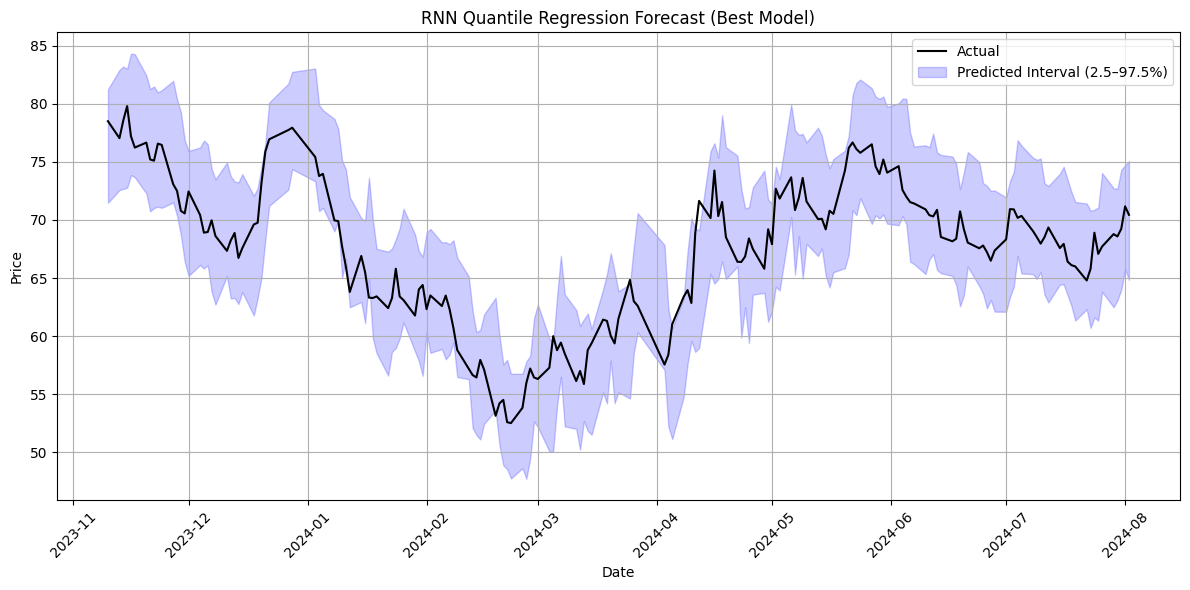

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import itertools

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# === Load your CSV file ===
csv_path = '/content/Carbon_Emissions_Futures_2021_Onwards.csv'
df = pd.read_csv(csv_path)

# === Preprocessing ===
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

def convert_volume(vol_str):
    try:
        if isinstance(vol_str, str):
            vol_str = vol_str.replace('K', '*1e3').replace('M', '*1e6')
            return eval(vol_str)
        return np.nan
    except:
        return np.nan

df['Vol.'] = df['Vol.'].apply(convert_volume)
df['Change %'] = df['Change %'].str.replace('%', '').astype(float)

# Lag features
df['Price_lag1'] = df['Price'].shift(1)
df['Vol_lag1'] = df['Vol.'].shift(1)
df['Change_lag1'] = df['Change %'].shift(1)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

features = ['Open', 'High', 'Low', 'Vol_lag1', 'Change_lag1', 'Price_lag1']
target = 'Price'

# Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_X.fit_transform(df[features])
y = scaler_y.fit_transform(df[[target]])

# Sequence creation
def create_sequences(X, y, seq_len=20):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i-seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# RNN Quantile Model
class RNNQuantile(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

# Quantile loss
def quantile_loss(q, y, y_pred):
    e = y - y_pred
    return torch.mean(torch.max(q * e, (q - 1) * e))

# Training function
def train_quantile_model(X_train, y_train, quantile, epochs=100, lr=0.01, hidden_dim=64, num_layers=1):
    model = RNNQuantile(input_dim=X_train.shape[2], hidden_dim=hidden_dim, num_layers=num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)

    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train_t)
        loss = quantile_loss(quantile, y_train_t, y_pred)
        loss.backward()
        optimizer.step()
    return model

# Grid search parameters
param_grid = {
    'seq_len': [3,6,9,12,15,18,21],
    'hidden_dim': [32, 64],
    'num_layers': [1, 2, 3],
    'learning_rate': [0.001, 0.01],
    'epochs': [50, 100]
}

target_coverage = 95  # target PICP %
alpha = 0.01           # weight for MPIW in scoring

# Evaluation function
def train_and_evaluate(params):
    seq_len = params['seq_len']
    hidden_dim = params['hidden_dim']
    num_layers = params['num_layers']
    lr = params['learning_rate']
    epochs = params['epochs']

    X_seq, y_seq = create_sequences(X, y, seq_len=seq_len)
    split_idx = int(0.8 * len(X_seq))
    X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
    y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]
    y_test_rescaled = scaler_y.inverse_transform(y_test).flatten()

    # Train lower and upper quantile RNN models
    lower_model = train_quantile_model(X_train, y_train, 0.025, epochs, lr, hidden_dim, num_layers)
    upper_model = train_quantile_model(X_train, y_train, 0.975, epochs, lr, hidden_dim, num_layers)

    # Predictions
    X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
    lower_model.eval()
    upper_model.eval()
    with torch.no_grad():
        pred_lower = lower_model(X_test_t).cpu().numpy()
        pred_upper = upper_model(X_test_t).cpu().numpy()

    pred_lower_rescaled = scaler_y.inverse_transform(pred_lower).flatten()
    pred_upper_rescaled = scaler_y.inverse_transform(pred_upper).flatten()
    median_pred = (pred_lower_rescaled + pred_upper_rescaled) / 2

    # Compute metrics
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, median_pred))
    picp = np.mean((y_test_rescaled >= pred_lower_rescaled) & (y_test_rescaled <= pred_upper_rescaled)) * 100
    mpiw = np.mean(pred_upper_rescaled - pred_lower_rescaled)
    score = abs(picp - target_coverage) + alpha * mpiw

    return score, rmse, params, pred_lower_rescaled, pred_upper_rescaled, y_test_rescaled, X_test, y_test, picp, mpiw

# Grid search
best_score = float('inf')
best_results = None

for values in itertools.product(*param_grid.values()):
    params = dict(zip(param_grid.keys(), values))
    print(f"Training with parameters: {params}")
    score, rmse, p, pred_lower, pred_upper, y_test_rescaled, X_test, y_test, picp, mpiw = train_and_evaluate(params)
    print(f"Score: {score:.4f}, RMSE: {rmse:.4f}, PICP: {picp:.2f}%, MPIW: {mpiw:.4f}")
    if score < best_score:
        best_score = score
        best_results = (p, pred_lower, pred_upper, y_test_rescaled, X_test, y_test, picp, mpiw)
        print(f"New best score: {best_score:.4f}")

# Final evaluation
best_params, pred_lower_best, pred_upper_best, y_test_rescaled_best, X_test_best, y_test_best, picp_best, mpiw_best = best_results
median_pred_best = (pred_lower_best + pred_upper_best) / 2
mse_best = mean_squared_error(y_test_rescaled_best, median_pred_best)
rmse_best = np.sqrt(mse_best)
mae_best = mean_absolute_error(y_test_rescaled_best, median_pred_best)
mape_best = np.mean(np.abs((y_test_rescaled_best - median_pred_best) / y_test_rescaled_best)) * 100
r2_best = r2_score(y_test_rescaled_best, median_pred_best)

# Print results
print("\nBest Hyperparameters:", best_params)
print(f"MSE: {mse_best:.4f}")
print(f"RMSE: {rmse_best:.4f}")
print(f"MAE: {mae_best:.4f}")
print(f"MAPE: {mape_best:.2f}%")
print(f"R^2: {r2_best:.4f}")
print(f"PICP: {picp_best:.2f}%")
print(f"MPIW: {mpiw_best:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df['Date'].iloc[-len(y_test_rescaled_best):], y_test_rescaled_best, label='Actual', color='black')
plt.fill_between(df['Date'].iloc[-len(y_test_rescaled_best):], pred_lower_best, pred_upper_best,
                 color='blue', alpha=0.2, label='Predicted Interval (2.5–97.5%)')
plt.title('RNN Quantile Regression Forecast (Best Model)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Using device: cuda
Training with parameters: {'seq_len': 10, 'hidden_dim': 16, 'num_layers': 1, 'learning_rate': 0.001, 'epochs': 50}
Score: 8.5133, RMSE: 10.1441, PICP: 86.74%, MPIW: 25.3600
New best score: 8.5133
Training with parameters: {'seq_len': 10, 'hidden_dim': 16, 'num_layers': 1, 'learning_rate': 0.001, 'epochs': 100}
Score: 3.6817, RMSE: 12.4530, PICP: 98.34%, MPIW: 33.9171
New best score: 3.6817
Training with parameters: {'seq_len': 10, 'hidden_dim': 16, 'num_layers': 1, 'learning_rate': 0.01, 'epochs': 50}
Score: 2.1625, RMSE: 23.6983, PICP: 93.37%, MPIW: 53.2697
New best score: 2.1625
Training with parameters: {'seq_len': 10, 'hidden_dim': 16, 'num_layers': 1, 'learning_rate': 0.01, 'epochs': 100}
Score: 3.6295, RMSE: 10.8152, PICP: 98.34%, MPIW: 28.6958
Training with parameters: {'seq_len': 10, 'hidden_dim': 16, 'num_layers': 2, 'learning_rate': 0.001, 'epochs': 50}
Score: 5.4978, RMSE: 13.2273, PICP: 100.00%, MPIW: 49.7814
Training with parameters: {'seq_len': 10, 'hid

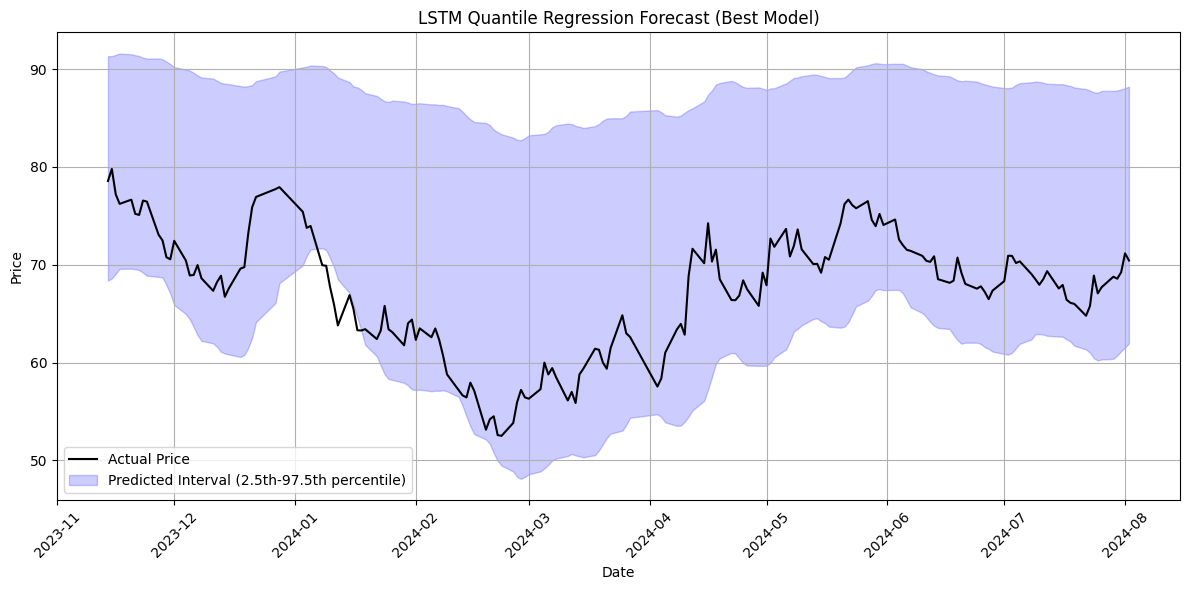

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import itertools

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# === Load your CSV file here ===
csv_path = '/content/Carbon_Emissions_Futures_2021_Onwards.csv'  # Change this to your file path
df = pd.read_csv(csv_path)

# === Preprocess ===
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

def convert_volume(vol_str):
    try:
        if isinstance(vol_str, str):
            vol_str = vol_str.replace('K', '*1e3').replace('M', '*1e6')
            return eval(vol_str)
        return np.nan
    except:
        return np.nan

df['Vol.'] = df['Vol.'].apply(convert_volume)
df['Change %'] = df['Change %'].str.replace('%', '').astype(float)

# Create lag features
df['Price_lag1'] = df['Price'].shift(1)
df['Vol_lag1'] = df['Vol.'].shift(1)
df['Change_lag1'] = df['Change %'].shift(1)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

features = ['Open', 'High', 'Low', 'Vol_lag1', 'Change_lag1', 'Price_lag1']
target = 'Price'

# Scale features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_X.fit_transform(df[features])
y = scaler_y.fit_transform(df[[target]])

# Create sequences for LSTM
def create_sequences(X, y, seq_len=20):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i-seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# LSTM Quantile Model
class LSTMQuantile(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

def quantile_loss(q, y, y_pred):
    e = y - y_pred
    return torch.mean(torch.max(q * e, (q - 1) * e))

def train_quantile_model(X_train, y_train, quantile, epochs=100, lr=0.01, hidden_dim=64, num_layers=1):
    model = LSTMQuantile(input_dim=X_train.shape[2], hidden_dim=hidden_dim, num_layers=num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)

    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train_t)
        loss = quantile_loss(quantile, y_train_t, y_pred)
        loss.backward()
        optimizer.step()
    return model

# Grid search params
param_grid = {
    'seq_len': [10, 15, 20],
    'hidden_dim': [16, 32, 64],
    'num_layers': [1, 2, 3],
    'learning_rate': [0.001, 0.01],
    'epochs': [50, 100]
}

# Target coverage and weight for MPIW in scoring
target_coverage = 95  # Desired PICP %
alpha = 0.01          # Weight for MPIW in combined score

def train_and_evaluate(params):
    seq_len = params['seq_len']
    hidden_dim = params['hidden_dim']
    num_layers = params['num_layers']
    lr = params['learning_rate']
    epochs = params['epochs']

    X_seq, y_seq = create_sequences(X, y, seq_len=seq_len)
    split_idx = int(0.8 * len(X_seq))
    X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
    y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]
    y_test_rescaled = scaler_y.inverse_transform(y_test).flatten()

    lower_model = train_quantile_model(X_train, y_train, quantile=0.025, epochs=epochs, lr=lr,
                                       hidden_dim=hidden_dim, num_layers=num_layers)
    upper_model = train_quantile_model(X_train, y_train, quantile=0.975, epochs=epochs, lr=lr,
                                       hidden_dim=hidden_dim, num_layers=num_layers)

    X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
    lower_model.eval()
    upper_model.eval()
    with torch.no_grad():
        pred_lower = lower_model(X_test_t).cpu().numpy()
        pred_upper = upper_model(X_test_t).cpu().numpy()

    pred_lower_rescaled = scaler_y.inverse_transform(pred_lower).flatten()
    pred_upper_rescaled = scaler_y.inverse_transform(pred_upper).flatten()
    median_pred = (pred_lower_rescaled + pred_upper_rescaled) / 2

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, median_pred))

    # Compute PICP and MPIW
    picp = np.mean((y_test_rescaled >= pred_lower_rescaled) & (y_test_rescaled <= pred_upper_rescaled)) * 100
    mpiw = np.mean(pred_upper_rescaled - pred_lower_rescaled)

    # Composite score: minimize difference from target coverage + weighted MPIW
    score = abs(picp - target_coverage) + alpha * mpiw

    return score, rmse, params, pred_lower_rescaled, pred_upper_rescaled, y_test_rescaled, X_test, y_test, picp, mpiw

best_score = float('inf')
best_results = None

for values in itertools.product(*param_grid.values()):
    params = dict(zip(param_grid.keys(), values))
    print(f"Training with parameters: {params}")
    score, rmse, p, pred_lower, pred_upper, y_test_rescaled, X_test, y_test, picp, mpiw = train_and_evaluate(params)
    print(f"Score: {score:.4f}, RMSE: {rmse:.4f}, PICP: {picp:.2f}%, MPIW: {mpiw:.4f}")
    if score < best_score:
        best_score = score
        best_results = (p, pred_lower, pred_upper, y_test_rescaled, X_test, y_test, picp, mpiw)
        print(f"New best score: {best_score:.4f}")

best_params, pred_lower_best, pred_upper_best, y_test_rescaled_best, X_test_best, y_test_best, picp_best, mpiw_best = best_results

median_pred_best = (pred_lower_best + pred_upper_best) / 2
mse_best = mean_squared_error(y_test_rescaled_best, median_pred_best)
rmse_best = np.sqrt(mse_best)
mae_best = mean_absolute_error(y_test_rescaled_best, median_pred_best)
mape_best = np.mean(np.abs((y_test_rescaled_best - median_pred_best) / y_test_rescaled_best)) * 100
r2_best = r2_score(y_test_rescaled_best, median_pred_best)

print("\nBest Hyperparameters:", best_params)
print(f"MSE: {mse_best:.4f}")
print(f"RMSE: {rmse_best:.4f}")
print(f"MAE: {mae_best:.4f}")
print(f"MAPE: {mape_best:.2f}%")
print(f"R^2: {r2_best:.4f}")
print(f"PICP: {picp_best:.2f}%")
print(f"MPIW: {mpiw_best:.4f}")

# Plot best results
plt.figure(figsize=(12,6))
plt.plot(df['Date'].iloc[-len(y_test_rescaled_best):], y_test_rescaled_best, label='Actual Price', color='black')
plt.fill_between(df['Date'].iloc[-len(y_test_rescaled_best):], pred_lower_best, pred_upper_best,
                 color='blue', alpha=0.2, label='Predicted Interval (2.5th-97.5th percentile)')
plt.title('LSTM Quantile Regression Forecast (Best Model)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Using device: cuda
Training with parameters: {'seq_len': 10, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.001, 'epochs': 50}
Score: 4.3026, RMSE: 15.8924, PICP: 98.90%, MPIW: 40.7613
New best score: 4.3026
Training with parameters: {'seq_len': 10, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.001, 'epochs': 100}
Score: 2.5196, RMSE: 9.4964, PICP: 97.24%, MPIW: 28.1993
New best score: 2.5196
Training with parameters: {'seq_len': 10, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.01, 'epochs': 50}
Score: 1.8223, RMSE: 3.8379, PICP: 96.69%, MPIW: 13.7187
New best score: 1.8223
Training with parameters: {'seq_len': 10, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.01, 'epochs': 100}
Score: 3.4700, RMSE: 2.8122, PICP: 98.34%, MPIW: 12.7494
Training with parameters: {'seq_len': 10, 'hidden_dim': 32, 'num_layers': 2, 'learning_rate': 0.001, 'epochs': 50}
Score: 2.7956, RMSE: 22.2931, PICP: 97.24%, MPIW: 55.7984
Training with parameters: {'seq_len': 10, 'hidden_

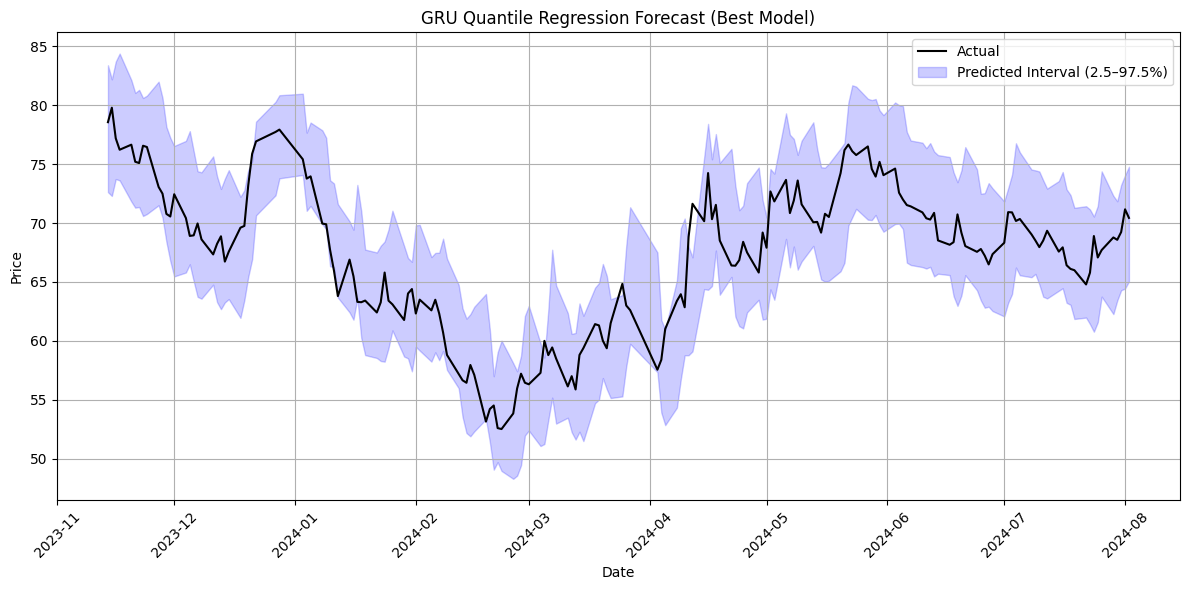

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import itertools

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# === Load your CSV file ===
csv_path = '/content/Carbon_Emissions_Futures_2021_Onwards.csv'
df = pd.read_csv(csv_path)

# === Preprocessing ===
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

def convert_volume(vol_str):
    try:
        if isinstance(vol_str, str):
            vol_str = vol_str.replace('K', '*1e3').replace('M', '*1e6')
            return eval(vol_str)
        return np.nan
    except:
        return np.nan

df['Vol.'] = df['Vol.'].apply(convert_volume)
df['Change %'] = df['Change %'].str.replace('%', '').astype(float)

df['Price_lag1'] = df['Price'].shift(1)
df['Vol_lag1'] = df['Vol.'].shift(1)
df['Change_lag1'] = df['Change %'].shift(1)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

features = ['Open', 'High', 'Low', 'Vol_lag1', 'Change_lag1', 'Price_lag1']
target = 'Price'

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_X.fit_transform(df[features])
y = scaler_y.fit_transform(df[[target]])

# Create sequences
def create_sequences(X, y, seq_len=20):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i-seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# GRU Quantile Model
class GRUQuantile(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

def quantile_loss(q, y, y_pred):
    e = y - y_pred
    return torch.mean(torch.max(q * e, (q - 1) * e))

def train_quantile_model(X_train, y_train, quantile, epochs=100, lr=0.01, hidden_dim=64, num_layers=1):
    model = GRUQuantile(input_dim=X_train.shape[2], hidden_dim=hidden_dim, num_layers=num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)

    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train_t)
        loss = quantile_loss(quantile, y_train_t, y_pred)
        loss.backward()
        optimizer.step()
    return model

# Grid search parameters
param_grid = {
    'seq_len': [10, 15, 20],
    'hidden_dim': [32, 64],
    'num_layers': [1, 2],
    'learning_rate': [0.001, 0.01],
    'epochs': [50, 100]
}

target_coverage = 95
alpha = 0.01

def train_and_evaluate(params):
    seq_len = params['seq_len']
    hidden_dim = params['hidden_dim']
    num_layers = params['num_layers']
    lr = params['learning_rate']
    epochs = params['epochs']

    X_seq, y_seq = create_sequences(X, y, seq_len=seq_len)
    split_idx = int(0.8 * len(X_seq))
    X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
    y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]
    y_test_rescaled = scaler_y.inverse_transform(y_test).flatten()

    lower_model = train_quantile_model(X_train, y_train, 0.025, epochs, lr, hidden_dim, num_layers)
    upper_model = train_quantile_model(X_train, y_train, 0.975, epochs, lr, hidden_dim, num_layers)

    X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
    lower_model.eval()
    upper_model.eval()
    with torch.no_grad():
        pred_lower = lower_model(X_test_t).cpu().numpy()
        pred_upper = upper_model(X_test_t).cpu().numpy()

    pred_lower_rescaled = scaler_y.inverse_transform(pred_lower).flatten()
    pred_upper_rescaled = scaler_y.inverse_transform(pred_upper).flatten()
    median_pred = (pred_lower_rescaled + pred_upper_rescaled) / 2

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, median_pred))
    picp = np.mean((y_test_rescaled >= pred_lower_rescaled) & (y_test_rescaled <= pred_upper_rescaled)) * 100
    mpiw = np.mean(pred_upper_rescaled - pred_lower_rescaled)
    score = abs(picp - target_coverage) + alpha * mpiw

    return score, rmse, params, pred_lower_rescaled, pred_upper_rescaled, y_test_rescaled, X_test, y_test, picp, mpiw

# Grid search
best_score = float('inf')
best_results = None

for values in itertools.product(*param_grid.values()):
    params = dict(zip(param_grid.keys(), values))
    print(f"Training with parameters: {params}")
    score, rmse, p, pred_lower, pred_upper, y_test_rescaled, X_test, y_test, picp, mpiw = train_and_evaluate(params)
    print(f"Score: {score:.4f}, RMSE: {rmse:.4f}, PICP: {picp:.2f}%, MPIW: {mpiw:.4f}")
    if score < best_score:
        best_score = score
        best_results = (p, pred_lower, pred_upper, y_test_rescaled, X_test, y_test, picp, mpiw)
        print(f"New best score: {score:.4f}")

# Final metrics
best_params, pred_lower_best, pred_upper_best, y_test_rescaled_best, X_test_best, y_test_best, picp_best, mpiw_best = best_results
median_pred_best = (pred_lower_best + pred_upper_best) / 2
mse_best = mean_squared_error(y_test_rescaled_best, median_pred_best)
rmse_best = np.sqrt(mse_best)
mae_best = mean_absolute_error(y_test_rescaled_best, median_pred_best)
mape_best = np.mean(np.abs((y_test_rescaled_best - median_pred_best) / y_test_rescaled_best)) * 100
r2_best = r2_score(y_test_rescaled_best, median_pred_best)

# Print results
print("\nBest Hyperparameters:", best_params)
print(f"MSE: {mse_best:.4f}")
print(f"RMSE: {rmse_best:.4f}")
print(f"MAE: {mae_best:.4f}")
print(f"MAPE: {mape_best:.2f}%")
print(f"R^2: {r2_best:.4f}")
print(f"PICP: {picp_best:.2f}%")
print(f"MPIW: {mpiw_best:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df['Date'].iloc[-len(y_test_rescaled_best):], y_test_rescaled_best, label='Actual', color='black')
plt.fill_between(df['Date'].iloc[-len(y_test_rescaled_best):], pred_lower_best, pred_upper_best,
                 color='blue', alpha=0.2, label='Predicted Interval (2.5–97.5%)')
plt.title('GRU Quantile Regression Forecast (Best Model)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Training with parameters: {'seq_len': 10, 'hidden_dim': 32, 'num_blocks': 2, 'learning_rate': 0.001, 'epochs': 50}
Score: 0.8099, RMSE: 5.6516, PICP: 94.48%, MPIW: 28.5030
New best score: 0.8099
Training with parameters: {'seq_len': 10, 'hidden_dim': 32, 'num_blocks': 2, 'learning_rate': 0.01, 'epochs': 50}
Score: 2.3135, RMSE: 3.3839, PICP: 92.82%, MPIW: 13.1226
Training with parameters: {'seq_len': 10, 'hidden_dim': 32, 'num_blocks': 3, 'learning_rate': 0.001, 'epochs': 50}
Score: 7.9547, RMSE: 7.1710, PICP: 87.29%, MPIW: 24.7555
Training with parameters: {'seq_len': 10, 'hidden_dim': 32, 'num_blocks': 3, 'learning_rate': 0.01, 'epochs': 50}
Score: 2.4454, RMSE: 6.3255, PICP: 97.24%, MPIW: 20.7822
Training with parameters: {'seq_len': 10, 'hidden_dim': 64, 'num_blocks': 2, 'learning_rate': 0.001, 'epochs': 50}
Score: 4.6157, RMSE: 4.3713, PICP: 90.61%, MPIW: 22.3467
Training with parameters: {'seq_len': 10, 'hidden_dim': 64, 'num_blocks': 2, 'learning_rate': 0.01, 'epochs': 50}
Score

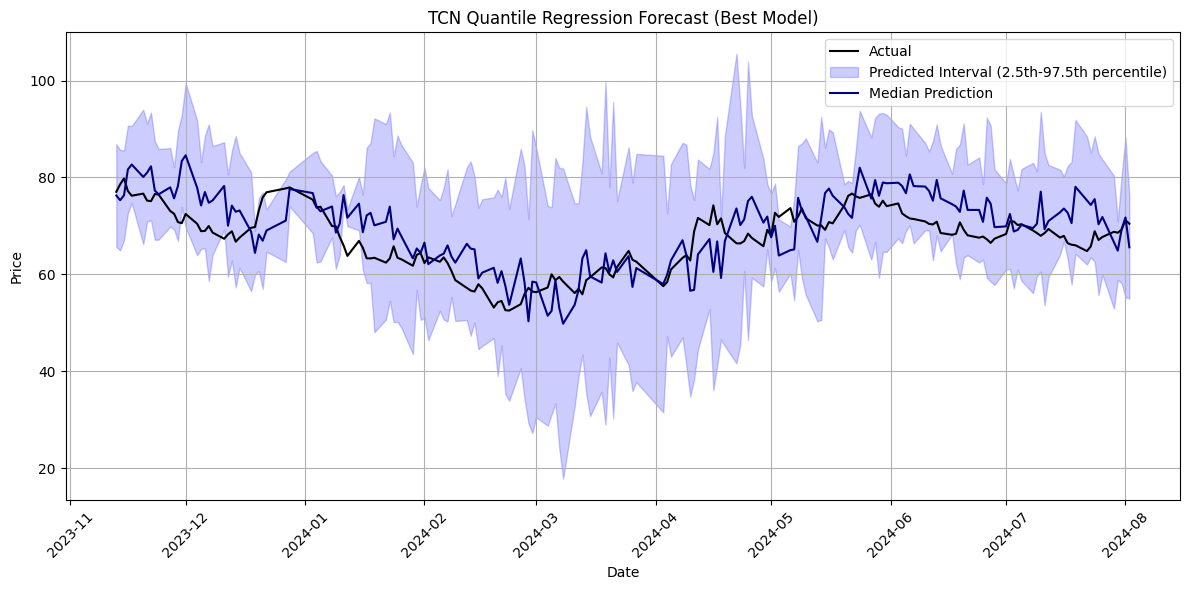

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import itertools

# Device: force CPU
device = torch.device("cpu")

# Load and preprocess data
df = pd.read_csv("Carbon_Emissions_Futures_2021_Onwards.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

def convert_volume(vol_str):
    try:
        if isinstance(vol_str, str):
            vol_str = vol_str.replace('K', '*1e3').replace('M', '*1e6')
            return eval(vol_str)
        return np.nan
    except:
        return np.nan

df['Vol.'] = df['Vol.'].apply(convert_volume)
df['Change %'] = df['Change %'].str.replace('%', '').astype(float)
df['Price_lag1'] = df['Price'].shift(1)
df['Vol_lag1'] = df['Vol.'].shift(1)
df['Change_lag1'] = df['Change %'].shift(1)
df.dropna(inplace=True)

features = ['Open', 'High', 'Low', 'Vol_lag1', 'Change_lag1', 'Price_lag1']
target = 'Price'

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_X.fit_transform(df[features])
y = scaler_y.fit_transform(df[[target]])

def create_sequences(X, y, seq_len=20):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i - seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=0, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding=0, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.kernel_size = kernel_size
        self.dilation = dilation

    def forward(self, x):
        pad = (self.kernel_size - 1) * self.dilation
        x_ = F.pad(x, (pad, 0))
        out = self.conv1(x_)
        out = F.relu(self.bn1(out))
        out = F.pad(out, (pad, 0))
        out = self.conv2(out)
        out = F.relu(self.bn2(out))
        res = x if self.downsample is None else self.downsample(x)
        if res.shape[-1] != out.shape[-1]:
            res = res[..., -out.shape[-1]:]
        return out + res

class TCNQuantile(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_blocks=2, kernel_size=3):
        super().__init__()
        layers = []
        for i in range(num_blocks):
            dilation = 2 ** i
            in_ch = input_dim if i == 0 else hidden_dim
            layers.append(TemporalBlock(in_ch, hidden_dim, kernel_size, stride=1, dilation=dilation))
        self.tcn = nn.Sequential(*layers)
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, seq_len)
        x = self.tcn(x)
        return self.output(x[:, :, -1])

def quantile_loss(q, y, y_pred):
    e = y - y_pred
    return torch.mean(torch.max(q * e, (q - 1) * e))

def train_quantile_model(X_train, y_train, quantile, epochs=50, lr=0.001, hidden_dim=64, num_blocks=2):
    model = TCNQuantile(X_train.shape[2], hidden_dim, num_blocks).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)
    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train_t)
        loss = quantile_loss(quantile, y_train_t, y_pred)
        loss.backward()
        optimizer.step()
    return model

# Hyperparameter grid
param_grid = {
    'seq_len': [10, 15],
    'hidden_dim': [32, 64],
    'num_blocks': [2, 3],
    'learning_rate': [0.001, 0.01],
    'epochs': [50]
}

target_coverage = 95
alpha = 0.01

def train_and_evaluate(params):
    seq_len = params['seq_len']
    hidden_dim = params['hidden_dim']
    num_blocks = params['num_blocks']
    lr = params['learning_rate']
    epochs = params['epochs']

    X_seq, y_seq = create_sequences(X, y, seq_len)
    split_idx = int(0.8 * len(X_seq))
    X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
    y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]
    y_test_rescaled = scaler_y.inverse_transform(y_test).flatten()

    model_lower = train_quantile_model(X_train, y_train, 0.025, epochs, lr, hidden_dim, num_blocks)
    model_upper = train_quantile_model(X_train, y_train, 0.975, epochs, lr, hidden_dim, num_blocks)

    X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
    model_lower.eval()
    model_upper.eval()
    with torch.no_grad():
        pred_lower = model_lower(X_test_t).cpu().numpy()
        pred_upper = model_upper(X_test_t).cpu().numpy()

    pred_lower_rescaled = scaler_y.inverse_transform(pred_lower).flatten()
    pred_upper_rescaled = scaler_y.inverse_transform(pred_upper).flatten()
    median_pred = (pred_lower_rescaled + pred_upper_rescaled) / 2

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, median_pred))
    picp = np.mean((y_test_rescaled >= pred_lower_rescaled) & (y_test_rescaled <= pred_upper_rescaled)) * 100
    mpiw = np.mean(pred_upper_rescaled - pred_lower_rescaled)

    score = abs(picp - target_coverage) + alpha * mpiw

    return score, rmse, params, pred_lower_rescaled, pred_upper_rescaled, y_test_rescaled, picp, mpiw

best_score = float('inf')
best_results = None

for values in itertools.product(*param_grid.values()):
    params = dict(zip(param_grid.keys(), values))
    print(f"Training with parameters: {params}")
    score, rmse, p, pred_lower, pred_upper, y_test_rescaled, picp, mpiw = train_and_evaluate(params)
    print(f"Score: {score:.4f}, RMSE: {rmse:.4f}, PICP: {picp:.2f}%, MPIW: {mpiw:.4f}")
    if score < best_score:
        best_score = score
        best_results = (p, pred_lower, pred_upper, y_test_rescaled, picp, mpiw)
        print(f"New best score: {best_score:.4f}")

best_params, pred_lower_best, pred_upper_best, y_test_rescaled_best, picp_best, mpiw_best = best_results
median_pred_best = (pred_lower_best + pred_upper_best) / 2

mse_best = mean_squared_error(y_test_rescaled_best, median_pred_best)
rmse_best = np.sqrt(mse_best)
mae_best = mean_absolute_error(y_test_rescaled_best, median_pred_best)
mape_best = np.mean(np.abs((y_test_rescaled_best - median_pred_best) / y_test_rescaled_best)) * 100
r2_best = r2_score(y_test_rescaled_best, median_pred_best)

print("\nBest Hyperparameters:", best_params)
print(f"MSE: {mse_best:.4f}")
print(f"RMSE: {rmse_best:.4f}")
print(f"MAE: {mae_best:.4f}")
print(f"MAPE: {mape_best:.2f}%")
print(f"R^2: {r2_best:.4f}")
print(f"PICP: {picp_best:.2f}%")
print(f"MPIW: {mpiw_best:.4f}")

# Plot best results
plt.figure(figsize=(12, 6))
test_dates = df['Date'].iloc[-len(y_test_rescaled_best):]
plt.plot(test_dates, y_test_rescaled_best, label='Actual', color='black')
plt.fill_between(test_dates, pred_lower_best, pred_upper_best, color='blue', alpha=0.2,
                 label='Predicted Interval (2.5th-97.5th percentile)')
plt.plot(test_dates, median_pred_best, color='navy', label='Median Prediction')
plt.title('TCN Quantile Regression Forecast (Best Model)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


### RNN/LSTM/GRU + Tube

In [ ]:
# hyperparameters for Tube Loss
q = 0.95 # target coverage
r=0.5  # for movement of PI tube
delta = 0 #  for recalibration


def confidence_loss(y_true, y_pred):
    y_true = y_true[:, 0]
    f2 = y_pred[:, 0]
    f1 = y_pred[:, 1]

    c1 = (1 - q) * (f2 - y_true)
    c2 = (1 - q) * (y_true - f1)
    c3 = q * (f1 - y_true)
    c4 = q * (y_true - f2)

    # Use tf.where to create a tensor based on conditions
    loss_part1 = tf.where(y_true > r * (f1 + f2), c1, c2)
    loss_part2 = tf.where(f1 > y_true, c3, c4)

    final_loss = tf.where(tf.logical_and(y_true <= f2, y_true >= f1), loss_part1, loss_part2) + (delta * tf.abs(f1 - f2))

    # Reduce the loss to a scalar using tf.reduce_mean
    return tf.reduce_mean(final_loss)

Using device: cuda

Training with params: {'seq_len': 2, 'hidden_dim': 16, 'num_layers': 1, 'learning_rate': 0.01, 'epochs': 100, 'q': 0.95, 'r': 0.5, 'delta': 0.0}
✗ Rejected: PICP = 93.99%

Training with params: {'seq_len': 2, 'hidden_dim': 16, 'num_layers': 1, 'learning_rate': 0.001, 'epochs': 100, 'q': 0.95, 'r': 0.5, 'delta': 0.0}
✓ Accepted: PICP = 100.00% | MPIW = 36.2126

Training with params: {'seq_len': 2, 'hidden_dim': 16, 'num_layers': 2, 'learning_rate': 0.01, 'epochs': 100, 'q': 0.95, 'r': 0.5, 'delta': 0.0}
✗ Rejected: PICP = 90.71%

Training with params: {'seq_len': 2, 'hidden_dim': 16, 'num_layers': 2, 'learning_rate': 0.001, 'epochs': 100, 'q': 0.95, 'r': 0.5, 'delta': 0.0}
✓ Accepted: PICP = 100.00% | MPIW = 30.2560

Training with params: {'seq_len': 2, 'hidden_dim': 16, 'num_layers': 3, 'learning_rate': 0.01, 'epochs': 100, 'q': 0.95, 'r': 0.5, 'delta': 0.0}
✓ Accepted: PICP = 95.63% | MPIW = 101.4157

Training with params: {'seq_len': 2, 'hidden_dim': 16, 'num_laye

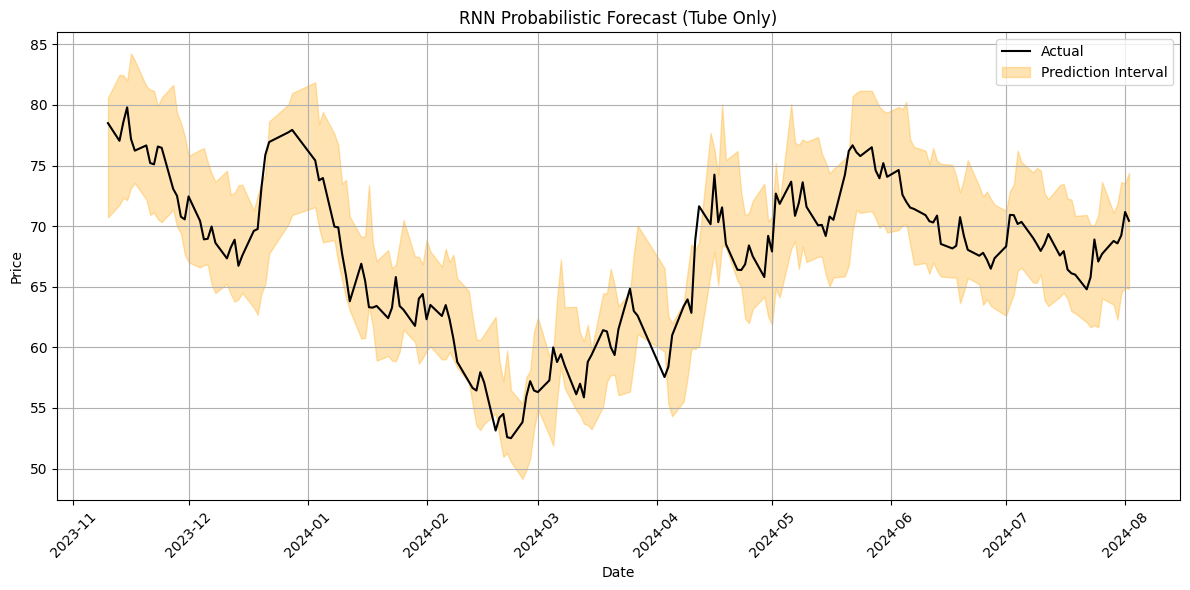

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import itertools

# --- Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- Load and Preprocess Data ---
def load_data(path):
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    df['Vol.'] = df['Vol.'].apply(lambda v: eval(v.replace('K','*1e3').replace('M','*1e6')) if isinstance(v, str) else np.nan)
    df['Change %'] = df['Change %'].str.replace('%','').astype(float)
    df['Price_lag1'] = df['Price'].shift(1)
    df['Vol_lag1'] = df['Vol.'].shift(1)
    df['Change_lag1'] = df['Change %'].shift(1)
    df.dropna(inplace=True)
    return df

def scale_features(df, features, target):
    scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
    X = scaler_X.fit_transform(df[features])
    y = scaler_y.fit_transform(df[[target]])
    return X, y, scaler_X, scaler_y

def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i-seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# --- RNN Model ---
class RNNTube(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 3)  # [upper, lower, (unused mean)]

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

# --- Tube Loss ---
def confidence_loss(y_true, y_pred, q, r, delta):
    y_true = y_true[:, 0]
    f2 = y_pred[:, 0]
    f1 = y_pred[:, 1]

    c1 = (1 - q) * (f2 - y_true)
    c2 = (1 - q) * (y_true - f1)
    c3 = q * (f1 - y_true)
    c4 = q * (y_true - f2)

    cond_inside = (y_true <= f2) & (y_true >= f1)
    cond_y_gt_mid = y_true > r * (f1 + f2)
    cond_f1_gt_y = f1 > y_true

    loss_part1 = torch.where(cond_y_gt_mid, c1, c2)
    loss_part2 = torch.where(cond_f1_gt_y, c3, c4)
    loss = torch.where(cond_inside, loss_part1, loss_part2)

    loss += delta * torch.abs(f2 - f1)
    return torch.mean(loss)


# --- Train Model ---
def train_model(X_train, y_train, input_dim, hidden_dim, num_layers, lr, epochs, q, r, delta):
    model = RNNTube(input_dim, hidden_dim, num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)

    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        loss = confidence_loss(y_train_t, model(X_train_t), q, r, delta)
        loss.backward()
        optimizer.step()
    return model


# --- Grid Search ---
def run_grid_search(X, y, scaler_y, param_grid, target_coverage=95):
    valid_models = []
    for values in itertools.product(*param_grid.values()):
        params = dict(zip(param_grid.keys(), values))
        print(f"\nTraining with params: {params}")

        X_seq, y_seq = create_sequences(X, y, params['seq_len'])
        split = int(0.8 * len(X_seq))
        X_train, X_test = X_seq[:split], X_seq[split:]
        y_train, y_test = y_seq[:split], y_seq[split:]
        y_test_rescaled = scaler_y.inverse_transform(y_test).flatten()

        model = train_model(X_train, y_train, X.shape[1], params['hidden_dim'],
                    params['num_layers'], params['learning_rate'],
                    params['epochs'], params['q'], params['r'], params['delta'])

        model.eval()
        with torch.no_grad():
            y_pred = model(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()

        pred_upper, pred_lower = y_pred[:, 0], y_pred[:, 1]
        pred_lower, pred_upper = np.minimum(pred_lower, pred_upper), np.maximum(pred_lower, pred_upper)

        pred_lower_rescaled = scaler_y.inverse_transform(pred_lower.reshape(-1, 1)).flatten()
        pred_upper_rescaled = scaler_y.inverse_transform(pred_upper.reshape(-1, 1)).flatten()

        picp = np.mean((y_test_rescaled >= pred_lower_rescaled) & (y_test_rescaled <= pred_upper_rescaled)) * 100
        mpiw = np.mean(pred_upper_rescaled - pred_lower_rescaled)

        if picp >= target_coverage:
            print(f"✓ Accepted: PICP = {picp:.2f}% | MPIW = {mpiw:.4f}")
            valid_models.append((mpiw, params, pred_lower_rescaled, pred_upper_rescaled, y_test_rescaled))
        else:
            print(f"✗ Rejected: PICP = {picp:.2f}%")

    return sorted(valid_models, key=lambda x: x[0])  # sort by MPIW

# --- Evaluation ---
def evaluate(y_true, pred_lower, pred_upper):
    picp = np.mean((y_true >= pred_lower) & (y_true <= pred_upper)) * 100
    mpiw = np.mean(pred_upper - pred_lower)
    print(f"\nEvaluation:\nPICP: {picp:.2f}% | MPIW: {mpiw:.4f}")

# --- Plotting ---
def plot_results(dates, y_true, pred_lower, pred_upper):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_true, label='Actual', color='black')
    plt.fill_between(dates, pred_lower, pred_upper, color='orange', alpha=0.3, label='Prediction Interval')
    plt.title('RNN Probabilistic Forecast (Tube Only)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    df = load_data("/content/Carbon_Emissions_Futures_2021_Onwards.csv")
    features = ['Open', 'High', 'Low', 'Vol_lag1', 'Change_lag1', 'Price_lag1']
    target = 'Price'
    X, y, scaler_X, scaler_y = scale_features(df, features, target)

    param_grid = {
    'seq_len': [2,4,6,8,10],
    'hidden_dim': [16,32,64],
    'num_layers': [1,2,3],
    'learning_rate': [0.01,0.001],
    'epochs': [100],
    'q': [0.95],
    'r': [0.5],
    'delta': [0.0]
}

    valid_models = run_grid_search(X, y, scaler_y, param_grid)

    if not valid_models:
        raise ValueError("No model met the PICP threshold.")

    best_model = valid_models[0]
    _, best_params, pred_lower, pred_upper, y_true = best_model

    print("\nBest Hyperparameters:", best_params)
    evaluate(y_true, pred_lower, pred_upper)

    test_dates = df['Date'].iloc[-len(y_true):]
    plot_results(test_dates, y_true, pred_lower, pred_upper)


Using device: cpu

Training with params: {'seq_len': 5, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.01, 'epochs': 100, 'q': 0.95, 'r': 0.4, 'delta': 0.0}
✓ Accepted: PICP = 100.00% | MPIW = 93.6036

Training with params: {'seq_len': 5, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.01, 'epochs': 100, 'q': 0.95, 'r': 0.4, 'delta': 0.05}
✗ Rejected: PICP = 86.81%

Training with params: {'seq_len': 5, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.01, 'epochs': 100, 'q': 0.95, 'r': 0.4, 'delta': 0.1}
✗ Rejected: PICP = 76.37%

Training with params: {'seq_len': 5, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.01, 'epochs': 100, 'q': 0.95, 'r': 0.5, 'delta': 0.0}
✗ Rejected: PICP = 85.71%

Training with params: {'seq_len': 5, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.01, 'epochs': 100, 'q': 0.95, 'r': 0.5, 'delta': 0.05}
✗ Rejected: PICP = 83.52%

Training with params: {'seq_len': 5, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.01, 'epoch

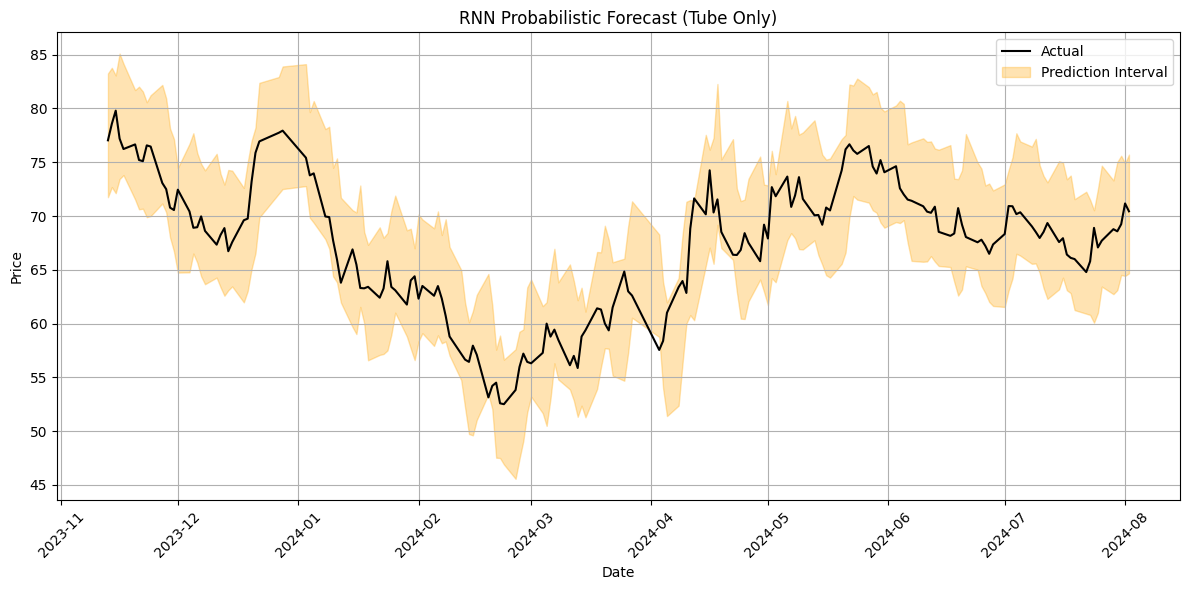

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import itertools

# --- Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- Load and Preprocess Data ---
def load_data(path):
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    df['Vol.'] = df['Vol.'].apply(lambda v: eval(v.replace('K','*1e3').replace('M','*1e6')) if isinstance(v, str) else np.nan)
    df['Change %'] = df['Change %'].str.replace('%','').astype(float)
    df['Price_lag1'] = df['Price'].shift(1)
    df['Vol_lag1'] = df['Vol.'].shift(1)
    df['Change_lag1'] = df['Change %'].shift(1)
    df.dropna(inplace=True)
    return df

def scale_features(df, features, target):
    scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
    X = scaler_X.fit_transform(df[features])
    y = scaler_y.fit_transform(df[[target]])
    return X, y, scaler_X, scaler_y

def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i-seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# --- RNN Model ---
class RNNTube(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 3)  # [upper, lower, (unused mean)]

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

# --- Tube Loss ---
def confidence_loss(y_true, y_pred, q, r, delta):
    y_true = y_true[:, 0]
    f2 = y_pred[:, 0]
    f1 = y_pred[:, 1]

    c1 = (1 - q) * (f2 - y_true)
    c2 = (1 - q) * (y_true - f1)
    c3 = q * (f1 - y_true)
    c4 = q * (y_true - f2)

    cond_inside = (y_true <= f2) & (y_true >= f1)
    cond_y_gt_mid = y_true > r * (f1 + f2)
    cond_f1_gt_y = f1 > y_true

    loss_part1 = torch.where(cond_y_gt_mid, c1, c2)
    loss_part2 = torch.where(cond_f1_gt_y, c3, c4)
    loss = torch.where(cond_inside, loss_part1, loss_part2)

    loss += delta * torch.abs(f2 - f1)
    return torch.mean(loss)


# --- Train Model ---
def train_model(X_train, y_train, input_dim, hidden_dim, num_layers, lr, epochs, q, r, delta):
    model = RNNTube(input_dim, hidden_dim, num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)

    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        loss = confidence_loss(y_train_t, model(X_train_t), q, r, delta)
        loss.backward()
        optimizer.step()
    return model


# --- Grid Search ---
def run_grid_search(X, y, scaler_y, param_grid, target_coverage=95):
    valid_models = []
    for values in itertools.product(*param_grid.values()):
        params = dict(zip(param_grid.keys(), values))
        print(f"\nTraining with params: {params}")

        X_seq, y_seq = create_sequences(X, y, params['seq_len'])
        split = int(0.8 * len(X_seq))
        X_train, X_test = X_seq[:split], X_seq[split:]
        y_train, y_test = y_seq[:split], y_seq[split:]
        y_test_rescaled = scaler_y.inverse_transform(y_test).flatten()

        model = train_model(X_train, y_train, X.shape[1], params['hidden_dim'],
                    params['num_layers'], params['learning_rate'],
                    params['epochs'], params['q'], params['r'], params['delta'])

        model.eval()
        with torch.no_grad():
            y_pred = model(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()

        pred_upper, pred_lower = y_pred[:, 0], y_pred[:, 1]
        pred_lower, pred_upper = np.minimum(pred_lower, pred_upper), np.maximum(pred_lower, pred_upper)

        pred_lower_rescaled = scaler_y.inverse_transform(pred_lower.reshape(-1, 1)).flatten()
        pred_upper_rescaled = scaler_y.inverse_transform(pred_upper.reshape(-1, 1)).flatten()

        picp = np.mean((y_test_rescaled >= pred_lower_rescaled) & (y_test_rescaled <= pred_upper_rescaled)) * 100
        mpiw = np.mean(pred_upper_rescaled - pred_lower_rescaled)

        if picp >= target_coverage:
            print(f"✓ Accepted: PICP = {picp:.2f}% | MPIW = {mpiw:.4f}")
            valid_models.append((mpiw, params, pred_lower_rescaled, pred_upper_rescaled, y_test_rescaled))
        else:
            print(f"✗ Rejected: PICP = {picp:.2f}%")

    return sorted(valid_models, key=lambda x: x[0])  # sort by MPIW

# --- Evaluation ---
def evaluate(y_true, pred_lower, pred_upper):
    picp = np.mean((y_true >= pred_lower) & (y_true <= pred_upper)) * 100
    mpiw = np.mean(pred_upper - pred_lower)
    print(f"\nEvaluation:\nPICP: {picp:.2f}% | MPIW: {mpiw:.4f}")

# --- Plotting ---
def plot_results(dates, y_true, pred_lower, pred_upper):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_true, label='Actual', color='black')
    plt.fill_between(dates, pred_lower, pred_upper, color='orange', alpha=0.3, label='Prediction Interval')
    plt.title('RNN Probabilistic Forecast (Tube Only)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    df = load_data("/content/Carbon_Emissions_Futures_2021_Onwards.csv")
    features = ['Open', 'High', 'Low', 'Vol_lag1', 'Change_lag1', 'Price_lag1']
    target = 'Price'
    X, y, scaler_X, scaler_y = scale_features(df, features, target)

    param_grid = {
    'seq_len': [5,6,7,12,14],
    'hidden_dim': [32,64,96],
    'num_layers': [1,2],
    'learning_rate': [0.01],
    'epochs': [100],
    'q': [0.95],
    'r': [0.4,0.5,0.6],
    'delta': [0.0,0.05,0.1]
}

    valid_models = run_grid_search(X, y, scaler_y, param_grid)

    if not valid_models:
        raise ValueError("No model met the PICP threshold.")

    best_model = valid_models[0]
    _, best_params, pred_lower, pred_upper, y_true = best_model

    print("\nBest Hyperparameters:", best_params)
    evaluate(y_true, pred_lower, pred_upper)

    test_dates = df['Date'].iloc[-len(y_true):]
    plot_results(test_dates, y_true, pred_lower, pred_upper)


Using device: cpu

Training with params: {'seq_len': 2, 'hidden_dim': 16, 'num_layers': 1, 'learning_rate': 0.01, 'epochs': 100, 'q': 0.95, 'r': 0.4, 'delta': 0.0}
✓ Accepted: PICP = 96.17% | MPIW = 89.1581

Training with params: {'seq_len': 2, 'hidden_dim': 16, 'num_layers': 1, 'learning_rate': 0.01, 'epochs': 100, 'q': 0.95, 'r': 0.4, 'delta': 0.05}
✓ Accepted: PICP = 97.27% | MPIW = 13.2759

Training with params: {'seq_len': 2, 'hidden_dim': 16, 'num_layers': 1, 'learning_rate': 0.01, 'epochs': 100, 'q': 0.95, 'r': 0.4, 'delta': 0.1}
✗ Rejected: PICP = 75.96%

Training with params: {'seq_len': 2, 'hidden_dim': 16, 'num_layers': 1, 'learning_rate': 0.01, 'epochs': 100, 'q': 0.95, 'r': 0.4, 'delta': 0.2}
✗ Rejected: PICP = 55.19%

Training with params: {'seq_len': 2, 'hidden_dim': 16, 'num_layers': 1, 'learning_rate': 0.01, 'epochs': 100, 'q': 0.95, 'r': 0.5, 'delta': 0.0}
✗ Rejected: PICP = 93.44%

Training with params: {'seq_len': 2, 'hidden_dim': 16, 'num_layers': 1, 'learning_rate

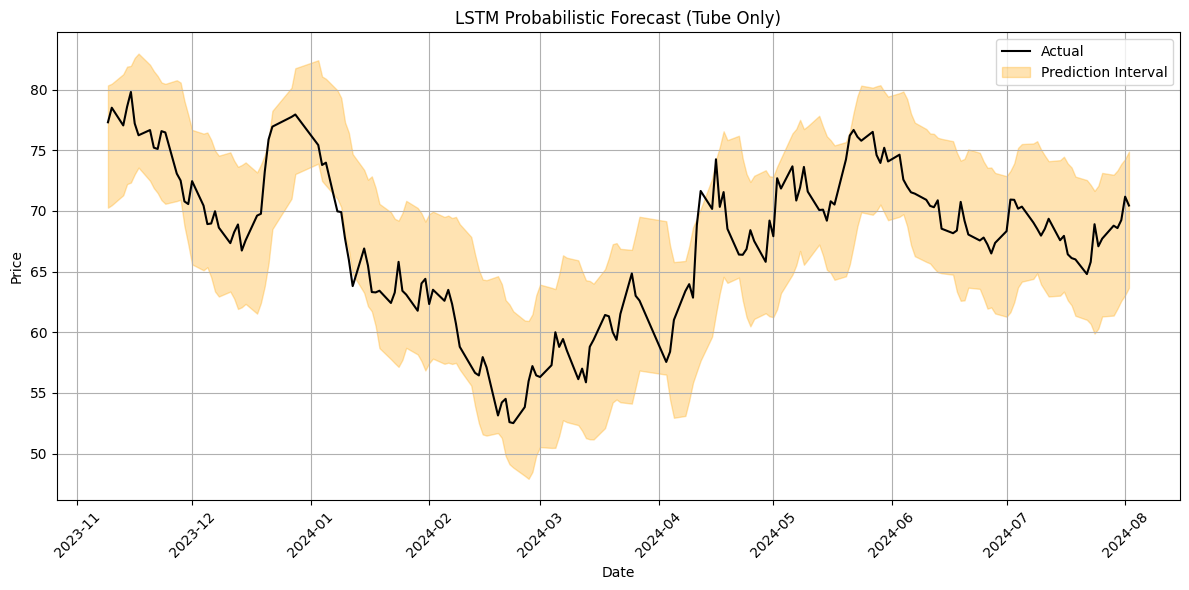

In [ ]:
# --- Imports ---
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import itertools

# --- Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- Load and Preprocess Data ---
def load_data(path):
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    df['Vol.'] = df['Vol.'].apply(lambda v: eval(v.replace('K','*1e3').replace('M','*1e6')) if isinstance(v, str) else np.nan)
    df['Change %'] = df['Change %'].str.replace('%','').astype(float)
    df['Price_lag1'] = df['Price'].shift(1)
    df['Vol_lag1'] = df['Vol.'].shift(1)
    df['Change_lag1'] = df['Change %'].shift(1)
    df.dropna(inplace=True)
    return df

def scale_features(df, features, target):
    scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
    X = scaler_X.fit_transform(df[features])
    y = scaler_y.fit_transform(df[[target]])
    return X, y, scaler_X, scaler_y

def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i-seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# --- LSTM Model ---
class LSTMTube(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 3)  # [upper, lower, (unused mean)]

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# --- Tube Loss ---
def confidence_loss(y_true, y_pred, q, r, delta):
    y_true = y_true[:, 0]
    f2 = y_pred[:, 0]  # upper
    f1 = y_pred[:, 1]  # lower

    c1 = (1 - q) * (f2 - y_true)
    c2 = (1 - q) * (y_true - f1)
    c3 = q * (f1 - y_true)
    c4 = q * (y_true - f2)

    cond_inside = (y_true <= f2) & (y_true >= f1)
    cond_y_gt_mid = y_true > r * (f1 + f2)
    cond_f1_gt_y = f1 > y_true

    loss_part1 = torch.where(cond_y_gt_mid, c1, c2)
    loss_part2 = torch.where(cond_f1_gt_y, c3, c4)
    loss = torch.where(cond_inside, loss_part1, loss_part2)

    loss += delta * torch.abs(f2 - f1)
    return torch.mean(loss)

# --- Train Model ---
def train_model(X_train, y_train, input_dim, hidden_dim, num_layers, lr, epochs, q, r, delta):
    model = LSTMTube(input_dim, hidden_dim, num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)

    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        loss = confidence_loss(y_train_t, model(X_train_t), q, r, delta)
        loss.backward()
        optimizer.step()
    return model

# --- Grid Search ---
def run_grid_search(X, y, scaler_y, param_grid, target_coverage=95):
    valid_models = []
    for values in itertools.product(*param_grid.values()):
        params = dict(zip(param_grid.keys(), values))
        print(f"\nTraining with params: {params}")

        X_seq, y_seq = create_sequences(X, y, params['seq_len'])
        split = int(0.8 * len(X_seq))
        X_train, X_test = X_seq[:split], X_seq[split:]
        y_train, y_test = y_seq[:split], y_seq[split:]
        y_test_rescaled = scaler_y.inverse_transform(y_test).flatten()

        model = train_model(X_train, y_train, X.shape[1], params['hidden_dim'],
                    params['num_layers'], params['learning_rate'],
                    params['epochs'], params['q'], params['r'], params['delta'])

        model.eval()
        with torch.no_grad():
            y_pred = model(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()

        pred_upper, pred_lower = y_pred[:, 0], y_pred[:, 1]
        pred_lower, pred_upper = np.minimum(pred_lower, pred_upper), np.maximum(pred_lower, pred_upper)

        pred_lower_rescaled = scaler_y.inverse_transform(pred_lower.reshape(-1, 1)).flatten()
        pred_upper_rescaled = scaler_y.inverse_transform(pred_upper.reshape(-1, 1)).flatten()

        picp = np.mean((y_test_rescaled >= pred_lower_rescaled) & (y_test_rescaled <= pred_upper_rescaled)) * 100
        mpiw = np.mean(pred_upper_rescaled - pred_lower_rescaled)

        if picp >= target_coverage:
            print(f"✓ Accepted: PICP = {picp:.2f}% | MPIW = {mpiw:.4f}")
            valid_models.append((mpiw, params, pred_lower_rescaled, pred_upper_rescaled, y_test_rescaled))
        else:
            print(f"✗ Rejected: PICP = {picp:.2f}%")

    return sorted(valid_models, key=lambda x: x[0])

# --- Evaluation ---
def evaluate(y_true, pred_lower, pred_upper):
    picp = np.mean((y_true >= pred_lower) & (y_true <= pred_upper)) * 100
    mpiw = np.mean(pred_upper - pred_lower)
    print(f"\nEvaluation:\nPICP: {picp:.2f}% | MPIW: {mpiw:.4f}")

# --- Plotting ---
def plot_results(dates, y_true, pred_lower, pred_upper):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_true, label='Actual', color='black')
    plt.fill_between(dates, pred_lower, pred_upper, color='orange', alpha=0.3, label='Prediction Interval')
    plt.title('LSTM Probabilistic Forecast (Tube Only)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    df = load_data("/content/Carbon_Emissions_Futures_2021_Onwards.csv")  # ✅ Change path if needed
    features = ['Open', 'High', 'Low', 'Vol_lag1', 'Change_lag1', 'Price_lag1']
    target = 'Price'
    X, y, scaler_X, scaler_y = scale_features(df, features, target)

    param_grid = {
        'seq_len': [2, 4, 6, 8, 10],
        'hidden_dim': [16, 32, 64],
        'num_layers': [1, 2],
        'learning_rate': [0.01],
        'epochs': [100],
        'q': [0.95],
        'r': [0.4,0.5,0.6],
        'delta': [0.0, 0.05, 0.1, 0.2]
    }

    valid_models = run_grid_search(X, y, scaler_y, param_grid)

    if not valid_models:
        raise ValueError("No model met the PICP threshold.")

    best_model = valid_models[0]
    _, best_params, pred_lower, pred_upper, y_true = best_model

    print("\nBest Hyperparameters:", best_params)
    evaluate(y_true, pred_lower, pred_upper)

    test_dates = df['Date'].iloc[-len(y_true):]
    plot_results(test_dates, y_true, pred_lower, pred_upper)


Using device: cuda

Training with params: {'seq_len': 2, 'hidden_dim': 16, 'num_layers': 1, 'learning_rate': 0.01, 'epochs': 100, 'q': 0.95, 'r': 0.5, 'delta': 0.0}
✗ Rejected: PICP = 89.62%

Training with params: {'seq_len': 2, 'hidden_dim': 16, 'num_layers': 1, 'learning_rate': 0.001, 'epochs': 100, 'q': 0.95, 'r': 0.5, 'delta': 0.0}
✓ Accepted: PICP = 100.00% | MPIW = 41.0544

Training with params: {'seq_len': 2, 'hidden_dim': 16, 'num_layers': 2, 'learning_rate': 0.01, 'epochs': 100, 'q': 0.95, 'r': 0.5, 'delta': 0.0}
✗ Rejected: PICP = 92.35%

Training with params: {'seq_len': 2, 'hidden_dim': 16, 'num_layers': 2, 'learning_rate': 0.001, 'epochs': 100, 'q': 0.95, 'r': 0.5, 'delta': 0.0}
✓ Accepted: PICP = 100.00% | MPIW = 45.2664

Training with params: {'seq_len': 2, 'hidden_dim': 16, 'num_layers': 3, 'learning_rate': 0.01, 'epochs': 100, 'q': 0.95, 'r': 0.5, 'delta': 0.0}
✓ Accepted: PICP = 96.72% | MPIW = 117.6262

Training with params: {'seq_len': 2, 'hidden_dim': 16, 'num_laye

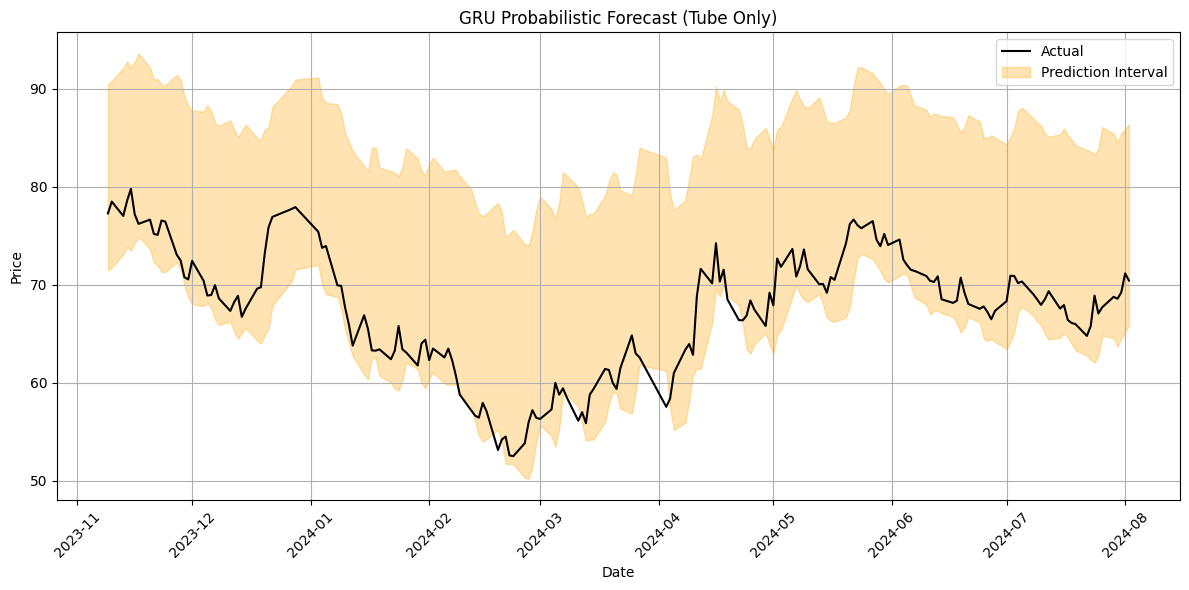

In [ ]:
# --- Imports ---
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import itertools

# --- Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- Load and Preprocess Data ---
def load_data(path):
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    df['Vol.'] = df['Vol.'].apply(lambda v: eval(v.replace('K','*1e3').replace('M','*1e6')) if isinstance(v, str) else np.nan)
    df['Change %'] = df['Change %'].str.replace('%','').astype(float)
    df['Price_lag1'] = df['Price'].shift(1)
    df['Vol_lag1'] = df['Vol.'].shift(1)
    df['Change_lag1'] = df['Change %'].shift(1)
    df.dropna(inplace=True)
    return df

def scale_features(df, features, target):
    scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
    X = scaler_X.fit_transform(df[features])
    y = scaler_y.fit_transform(df[[target]])
    return X, y, scaler_X, scaler_y

def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i-seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# --- GRU Model ---
class GRUTube(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 3)  # [upper, lower, (unused mean)]

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

# --- Tube Loss ---
def confidence_loss(y_true, y_pred, q, r, delta):
    y_true = y_true[:, 0]
    f2 = y_pred[:, 0]  # upper
    f1 = y_pred[:, 1]  # lower

    c1 = (1 - q) * (f2 - y_true)
    c2 = (1 - q) * (y_true - f1)
    c3 = q * (f1 - y_true)
    c4 = q * (y_true - f2)

    cond_inside = (y_true <= f2) & (y_true >= f1)
    cond_y_gt_mid = y_true > r * (f1 + f2)
    cond_f1_gt_y = f1 > y_true

    loss_part1 = torch.where(cond_y_gt_mid, c1, c2)
    loss_part2 = torch.where(cond_f1_gt_y, c3, c4)
    loss = torch.where(cond_inside, loss_part1, loss_part2)

    loss += delta * torch.abs(f2 - f1)
    return torch.mean(loss)

# --- Train Model ---
def train_model(X_train, y_train, input_dim, hidden_dim, num_layers, lr, epochs, q, r, delta):
    model = GRUTube(input_dim, hidden_dim, num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)

    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        loss = confidence_loss(y_train_t, model(X_train_t), q, r, delta)
        loss.backward()
        optimizer.step()
    return model

# --- Grid Search ---
def run_grid_search(X, y, scaler_y, param_grid, target_coverage=95):
    valid_models = []
    for values in itertools.product(*param_grid.values()):
        params = dict(zip(param_grid.keys(), values))
        print(f"\nTraining with params: {params}")

        X_seq, y_seq = create_sequences(X, y, params['seq_len'])
        split = int(0.8 * len(X_seq))
        X_train, X_test = X_seq[:split], X_seq[split:]
        y_train, y_test = y_seq[:split], y_seq[split:]
        y_test_rescaled = scaler_y.inverse_transform(y_test).flatten()

        model = train_model(X_train, y_train, X.shape[1], params['hidden_dim'],
                    params['num_layers'], params['learning_rate'],
                    params['epochs'], params['q'], params['r'], params['delta'])

        model.eval()
        with torch.no_grad():
            y_pred = model(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()

        pred_upper, pred_lower = y_pred[:, 0], y_pred[:, 1]
        pred_lower, pred_upper = np.minimum(pred_lower, pred_upper), np.maximum(pred_lower, pred_upper)

        pred_lower_rescaled = scaler_y.inverse_transform(pred_lower.reshape(-1, 1)).flatten()
        pred_upper_rescaled = scaler_y.inverse_transform(pred_upper.reshape(-1, 1)).flatten()

        picp = np.mean((y_test_rescaled >= pred_lower_rescaled) & (y_test_rescaled <= pred_upper_rescaled)) * 100
        mpiw = np.mean(pred_upper_rescaled - pred_lower_rescaled)

        if picp >= target_coverage:
            print(f"✓ Accepted: PICP = {picp:.2f}% | MPIW = {mpiw:.4f}")
            valid_models.append((mpiw, params, pred_lower_rescaled, pred_upper_rescaled, y_test_rescaled))
        else:
            print(f"✗ Rejected: PICP = {picp:.2f}%")

    return sorted(valid_models, key=lambda x: x[0])  # sort by MPIW

# --- Evaluation ---
def evaluate(y_true, pred_lower, pred_upper):
    picp = np.mean((y_true >= pred_lower) & (y_true <= pred_upper)) * 100
    mpiw = np.mean(pred_upper - pred_lower)
    print(f"\nEvaluation:\nPICP: {picp:.2f}% | MPIW: {mpiw:.4f}")

# --- Plotting ---
def plot_results(dates, y_true, pred_lower, pred_upper):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_true, label='Actual', color='black')
    plt.fill_between(dates, pred_lower, pred_upper, color='orange', alpha=0.3, label='Prediction Interval')
    plt.title('GRU Probabilistic Forecast (Tube Only)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    df = load_data("/content/Carbon_Emissions_Futures_2021_Onwards.csv")  # ✅ Update path if needed
    features = ['Open', 'High', 'Low', 'Vol_lag1', 'Change_lag1', 'Price_lag1']
    target = 'Price'
    X, y, scaler_X, scaler_y = scale_features(df, features, target)

    param_grid = {
        'seq_len': [2, 4, 6, 8, 10],
        'hidden_dim': [16, 32, 64],
        'num_layers': [1, 2, 3],
        'learning_rate': [0.01, 0.001],
        'epochs': [100],
        'q': [0.95],
        'r': [0.5],
        'delta': [0.0]
    }

    valid_models = run_grid_search(X, y, scaler_y, param_grid)

    if not valid_models:
        raise ValueError("No model met the PICP threshold.")

    best_model = valid_models[0]
    _, best_params, pred_lower, pred_upper, y_true = best_model

    print("\nBest Hyperparameters:", best_params)
    evaluate(y_true, pred_lower, pred_upper)

    test_dates = df['Date'].iloc[-len(y_true):]
    plot_results(test_dates, y_true, pred_lower, pred_upper)


Using device: cpu

Training with params: {'seq_len': 2, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.001, 'epochs': 100, 'q': 0.95, 'r': 0.4, 'delta': 0.0}
✓ Accepted: PICP = 100.00% | MPIW = 48.1390

Training with params: {'seq_len': 2, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.001, 'epochs': 100, 'q': 0.95, 'r': 0.4, 'delta': 0.05}
✗ Rejected: PICP = 84.70%

Training with params: {'seq_len': 2, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.001, 'epochs': 100, 'q': 0.95, 'r': 0.4, 'delta': 0.1}
✗ Rejected: PICP = 82.51%

Training with params: {'seq_len': 2, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.001, 'epochs': 100, 'q': 0.95, 'r': 0.5, 'delta': 0.0}
✓ Accepted: PICP = 100.00% | MPIW = 44.3424

Training with params: {'seq_len': 2, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.001, 'epochs': 100, 'q': 0.95, 'r': 0.5, 'delta': 0.05}
✗ Rejected: PICP = 72.13%

Training with params: {'seq_len': 2, 'hidden_dim': 32, 'num_layers': 1, 'learn

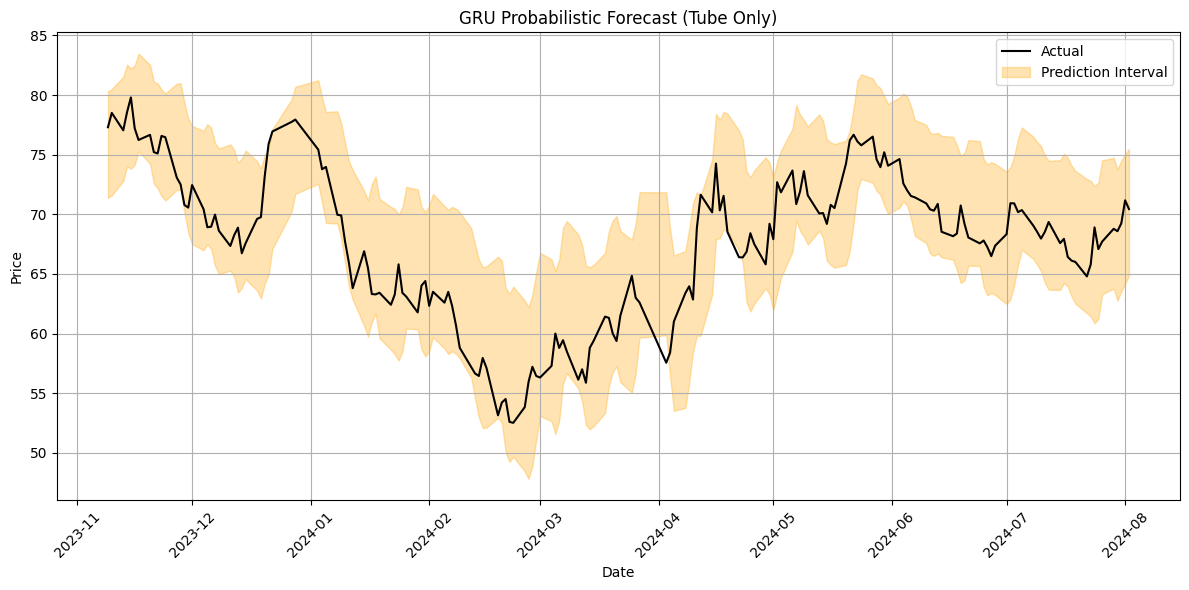

In [ ]:
# --- Imports ---
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import itertools

# --- Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- Load and Preprocess Data ---
def load_data(path):
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    df['Vol.'] = df['Vol.'].apply(lambda v: eval(v.replace('K','*1e3').replace('M','*1e6')) if isinstance(v, str) else np.nan)
    df['Change %'] = df['Change %'].str.replace('%','').astype(float)
    df['Price_lag1'] = df['Price'].shift(1)
    df['Vol_lag1'] = df['Vol.'].shift(1)
    df['Change_lag1'] = df['Change %'].shift(1)
    df.dropna(inplace=True)
    return df

def scale_features(df, features, target):
    scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
    X = scaler_X.fit_transform(df[features])
    y = scaler_y.fit_transform(df[[target]])
    return X, y, scaler_X, scaler_y

def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i-seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# --- GRU Model ---
class GRUTube(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 3)  # [upper, lower, (unused mean)]

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

# --- Tube Loss ---
def confidence_loss(y_true, y_pred, q, r, delta):
    y_true = y_true[:, 0]
    f2 = y_pred[:, 0]  # upper
    f1 = y_pred[:, 1]  # lower

    c1 = (1 - q) * (f2 - y_true)
    c2 = (1 - q) * (y_true - f1)
    c3 = q * (f1 - y_true)
    c4 = q * (y_true - f2)

    cond_inside = (y_true <= f2) & (y_true >= f1)
    cond_y_gt_mid = y_true > r * (f1 + f2)
    cond_f1_gt_y = f1 > y_true

    loss_part1 = torch.where(cond_y_gt_mid, c1, c2)
    loss_part2 = torch.where(cond_f1_gt_y, c3, c4)
    loss = torch.where(cond_inside, loss_part1, loss_part2)

    loss += delta * torch.abs(f2 - f1)
    return torch.mean(loss)

# --- Train Model ---
def train_model(X_train, y_train, input_dim, hidden_dim, num_layers, lr, epochs, q, r, delta):
    model = GRUTube(input_dim, hidden_dim, num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)

    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        loss = confidence_loss(y_train_t, model(X_train_t), q, r, delta)
        loss.backward()
        optimizer.step()
    return model

# --- Grid Search ---
def run_grid_search(X, y, scaler_y, param_grid, target_coverage=95):
    valid_models = []
    for values in itertools.product(*param_grid.values()):
        params = dict(zip(param_grid.keys(), values))
        print(f"\nTraining with params: {params}")

        X_seq, y_seq = create_sequences(X, y, params['seq_len'])
        split = int(0.8 * len(X_seq))
        X_train, X_test = X_seq[:split], X_seq[split:]
        y_train, y_test = y_seq[:split], y_seq[split:]
        y_test_rescaled = scaler_y.inverse_transform(y_test).flatten()

        model = train_model(X_train, y_train, X.shape[1], params['hidden_dim'],
                    params['num_layers'], params['learning_rate'],
                    params['epochs'], params['q'], params['r'], params['delta'])

        model.eval()
        with torch.no_grad():
            y_pred = model(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()

        pred_upper, pred_lower = y_pred[:, 0], y_pred[:, 1]
        pred_lower, pred_upper = np.minimum(pred_lower, pred_upper), np.maximum(pred_lower, pred_upper)

        pred_lower_rescaled = scaler_y.inverse_transform(pred_lower.reshape(-1, 1)).flatten()
        pred_upper_rescaled = scaler_y.inverse_transform(pred_upper.reshape(-1, 1)).flatten()

        picp = np.mean((y_test_rescaled >= pred_lower_rescaled) & (y_test_rescaled <= pred_upper_rescaled)) * 100
        mpiw = np.mean(pred_upper_rescaled - pred_lower_rescaled)

        if picp >= target_coverage:
            print(f"✓ Accepted: PICP = {picp:.2f}% | MPIW = {mpiw:.4f}")
            valid_models.append((mpiw, params, pred_lower_rescaled, pred_upper_rescaled, y_test_rescaled))
        else:
            print(f"✗ Rejected: PICP = {picp:.2f}%")

    return sorted(valid_models, key=lambda x: x[0])  # sort by MPIW

# --- Evaluation ---
def evaluate(y_true, pred_lower, pred_upper):
    picp = np.mean((y_true >= pred_lower) & (y_true <= pred_upper)) * 100
    mpiw = np.mean(pred_upper - pred_lower)
    print(f"\nEvaluation:\nPICP: {picp:.2f}% | MPIW: {mpiw:.4f}")

# --- Plotting ---
def plot_results(dates, y_true, pred_lower, pred_upper):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_true, label='Actual', color='black')
    plt.fill_between(dates, pred_lower, pred_upper, color='orange', alpha=0.3, label='Prediction Interval')
    plt.title('GRU Probabilistic Forecast (Tube Only)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    df = load_data("/content/Carbon_Emissions_Futures_2021_Onwards.csv")  # ✅ Update path if needed
    features = ['Open', 'High', 'Low', 'Vol_lag1', 'Change_lag1', 'Price_lag1']
    target = 'Price'
    X, y, scaler_X, scaler_y = scale_features(df, features, target)

    param_grid = {
        'seq_len': [2,4,6,8,10],
        'hidden_dim': [32,64],
        'num_layers': [1,2],
        'learning_rate': [0.001,0.05],
        'epochs': [100],
        'q': [0.95],
        'r': [0.4,0.5,0.6],
        'delta': [0.0,0.05,0.1]
    }

    valid_models = run_grid_search(X, y, scaler_y, param_grid)

    if not valid_models:
        raise ValueError("No model met the PICP threshold.")

    best_model = valid_models[0]
    _, best_params, pred_lower, pred_upper, y_true = best_model

    print("\nBest Hyperparameters:", best_params)
    evaluate(y_true, pred_lower, pred_upper)

    test_dates = df['Date'].iloc[-len(y_true):]
    plot_results(test_dates, y_true, pred_lower, pred_upper)


Using device: cuda

Training with params: {'seq_len': 5, 'hidden_dim': 16, 'kernel_size': 2, 'num_blocks': 1, 'dropout': 0.0, 'learning_rate': 0.001, 'epochs': 50, 'q': 0.95, 'r': 0.5, 'delta': 0.0}
✓ Accepted: PICP = 96.70% | MPIW = 50.5674

Training with params: {'seq_len': 5, 'hidden_dim': 16, 'kernel_size': 2, 'num_blocks': 1, 'dropout': 0.0, 'learning_rate': 0.005, 'epochs': 50, 'q': 0.95, 'r': 0.5, 'delta': 0.0}
✗ Rejected: PICP = 87.36%

Training with params: {'seq_len': 5, 'hidden_dim': 16, 'kernel_size': 2, 'num_blocks': 1, 'dropout': 0.0, 'learning_rate': 0.01, 'epochs': 50, 'q': 0.95, 'r': 0.5, 'delta': 0.0}
✗ Rejected: PICP = 66.48%

Training with params: {'seq_len': 5, 'hidden_dim': 16, 'kernel_size': 2, 'num_blocks': 1, 'dropout': 0.1, 'learning_rate': 0.001, 'epochs': 50, 'q': 0.95, 'r': 0.5, 'delta': 0.0}
✓ Accepted: PICP = 99.45% | MPIW = 48.3357

Training with params: {'seq_len': 5, 'hidden_dim': 16, 'kernel_size': 2, 'num_blocks': 1, 'dropout': 0.1, 'learning_rate': 

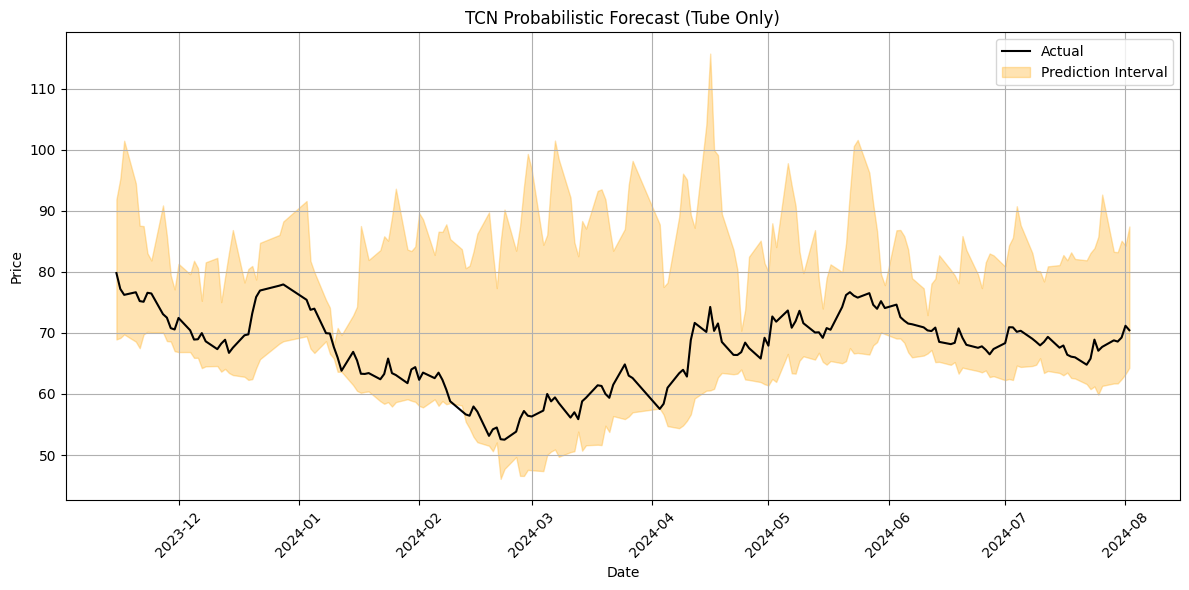


Final Evaluation:
PICP: 98.88%
MPIW: 23.6306


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import itertools

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- Load Data ---
def load_data(path):
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    df['Vol.'] = df['Vol.'].apply(lambda v: eval(v.replace('K','*1e3').replace('M','*1e6')) if isinstance(v, str) else np.nan)
    df['Change %'] = df['Change %'].str.replace('%','').astype(float)
    df['Price_lag1'] = df['Price'].shift(1)
    df['Vol_lag1'] = df['Vol.'].shift(1)
    df['Change_lag1'] = df['Change %'].shift(1)
    df.dropna(inplace=True)
    return df

def scale_features(df, features, target):
    scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
    X = scaler_X.fit_transform(df[features])
    y = scaler_y.fit_transform(df[[target]])
    return X, y, scaler_X, scaler_y

def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i-seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# --- TCN Layer ---
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout):
        super().__init__()
        padding = (kernel_size - 1) * dilation
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, dilation=dilation),
            nn.ReLU(),
            nn.BatchNorm1d(out_channels),
            nn.Dropout(dropout),
            nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding, dilation=dilation),
            nn.ReLU(),
            nn.BatchNorm1d(out_channels),
            nn.Dropout(dropout),
        )
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None

    def forward(self, x):
        out = self.conv(x)
        out = out[:, :, :x.size(2)]
        res = x if self.downsample is None else self.downsample(x)
        return out + res

class TCN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_blocks=2, kernel_size=3, dropout=0.0):
        super().__init__()
        layers = []
        for i in range(num_blocks):
            dilation = 2 ** i
            in_ch = input_dim if i == 0 else hidden_dim
            layers.append(TemporalBlock(in_ch, hidden_dim, kernel_size, dilation, dropout))
        self.network = nn.Sequential(*layers)
        self.output = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.network(x)
        return self.output(x[:, :, -1])

# --- Tube Loss ---
def confidence_loss(y_true, y_pred, q, r, delta):
    y_true = y_true[:, 0]
    f2 = y_pred[:, 0]  # upper
    f1 = y_pred[:, 1]  # lower

    c1 = (1 - q) * (f2 - y_true)
    c2 = (1 - q) * (y_true - f1)
    c3 = q * (f1 - y_true)
    c4 = q * (y_true - f2)

    cond_inside = (y_true <= f2) & (y_true >= f1)
    cond_y_gt_mid = y_true > r * (f1 + f2)
    cond_f1_gt_y = f1 > y_true

    loss_part1 = torch.where(cond_y_gt_mid, c1, c2)
    loss_part2 = torch.where(cond_f1_gt_y, c3, c4)
    loss = torch.where(cond_inside, loss_part1, loss_part2)
    loss += delta * torch.abs(f2 - f1)
    return torch.mean(loss)

# --- Training ---
def train_model(X_train, y_train, input_dim, hidden_dim, num_blocks, kernel_size,
                dropout, lr, epochs, q, r, delta):
    model = TCN(input_dim, hidden_dim, num_blocks, kernel_size, dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)

    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        loss = confidence_loss(y_train_t, model(X_train_t), q, r, delta)
        loss.backward()
        optimizer.step()
    return model

# --- Grid Search ---
def run_grid_search(X, y, scaler_y, param_grid, target_coverage=95):
    valid_models = []
    for values in itertools.product(*param_grid.values()):
        params = dict(zip(param_grid.keys(), values))
        print(f"\nTraining with params: {params}")

        X_seq, y_seq = create_sequences(X, y, params['seq_len'])
        split = int(0.8 * len(X_seq))
        X_train, X_test = X_seq[:split], X_seq[split:]
        y_train, y_test = y_seq[:split], y_seq[split:]
        y_test_rescaled = scaler_y.inverse_transform(y_test).flatten()

        model = train_model(X_train, y_train, X.shape[1],
                    params['hidden_dim'], params['num_blocks'],
                    params['kernel_size'], params['dropout'],
                    params['learning_rate'], params['epochs'],
                    params['q'], params['r'], params['delta'])

        model.eval()
        with torch.no_grad():
            y_pred = model(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()

        pred_upper, pred_lower = y_pred[:, 0], y_pred[:, 1]
        pred_lower, pred_upper = np.minimum(pred_lower, pred_upper), np.maximum(pred_lower, pred_upper)

        pred_lower_rescaled = scaler_y.inverse_transform(pred_lower.reshape(-1, 1)).flatten()
        pred_upper_rescaled = scaler_y.inverse_transform(pred_upper.reshape(-1, 1)).flatten()

        picp = np.mean((y_test_rescaled >= pred_lower_rescaled) & (y_test_rescaled <= pred_upper_rescaled)) * 100
        mpiw = np.mean(pred_upper_rescaled - pred_lower_rescaled)

        if picp >= target_coverage:
            print(f"✓ Accepted: PICP = {picp:.2f}% | MPIW = {mpiw:.4f}")
            valid_models.append((mpiw, params, pred_lower_rescaled, pred_upper_rescaled, y_test_rescaled))
        else:
            print(f"✗ Rejected: PICP = {picp:.2f}%")

    return sorted(valid_models, key=lambda x: x[0])

# --- Plot ---
def plot_results(dates, y_true, pred_lower, pred_upper):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_true, label='Actual', color='black')
    plt.fill_between(dates, pred_lower, pred_upper, color='orange', alpha=0.3, label='Prediction Interval')
    plt.title('TCN Probabilistic Forecast (Tube Only)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    df = load_data("/content/Carbon_Emissions_Futures_2021_Onwards.csv")
    features = ['Open', 'High', 'Low', 'Vol_lag1', 'Change_lag1', 'Price_lag1']
    target = 'Price'
    X, y, scaler_X, scaler_y = scale_features(df, features, target)

    param_grid = {
    'seq_len': [5, 10, 15, 20],
    'hidden_dim': [16, 32, 64, 128],
    'kernel_size': [2, 3, 5],
    'num_blocks': [1, 2, 3],
    'dropout': [0.0, 0.1, 0.2],
    'learning_rate': [0.001, 0.005, 0.01],
    'epochs': [50],
    'q': [0.95],
    'r': [0.5],
    'delta': [0.0]
}

    valid_models = run_grid_search(X, y, scaler_y, param_grid)

    if not valid_models:
        raise ValueError("No model met the PICP threshold.")

    best_model = valid_models[0]
    _, best_params, pred_lower, pred_upper, y_true = best_model

    print("\nBest Hyperparameters:", best_params)
    plot_results(df['Date'].iloc[-len(y_true):], y_true, pred_lower, pred_upper)

    # --- Final Evaluation ---
    picp = np.mean((y_true >= pred_lower) & (y_true <= pred_upper)) * 100
    mpiw = np.mean(pred_upper - pred_lower)

    print(f"\nFinal Evaluation:")
    print(f"PICP: {picp:.2f}%")
    print(f"MPIW: {mpiw:.4f}")

Using device: cpu

Training with params: {'seq_len': 15, 'hidden_dim': 64, 'kernel_size': 2, 'num_blocks': 2, 'dropout': 0.1, 'learning_rate': 0.005, 'epochs': 50, 'q': 0.95, 'r': 0.4, 'delta': 0.0}
✓ Accepted: PICP = 98.89% | MPIW = 33.2017

Training with params: {'seq_len': 15, 'hidden_dim': 64, 'kernel_size': 2, 'num_blocks': 2, 'dropout': 0.1, 'learning_rate': 0.005, 'epochs': 50, 'q': 0.95, 'r': 0.4, 'delta': 0.05}
✗ Rejected: PICP = 94.44%

Training with params: {'seq_len': 15, 'hidden_dim': 64, 'kernel_size': 2, 'num_blocks': 2, 'dropout': 0.1, 'learning_rate': 0.005, 'epochs': 50, 'q': 0.95, 'r': 0.4, 'delta': 0.1}
✗ Rejected: PICP = 93.89%

Training with params: {'seq_len': 15, 'hidden_dim': 64, 'kernel_size': 2, 'num_blocks': 2, 'dropout': 0.1, 'learning_rate': 0.005, 'epochs': 50, 'q': 0.95, 'r': 0.4, 'delta': 0.2}
✗ Rejected: PICP = 82.22%

Training with params: {'seq_len': 15, 'hidden_dim': 64, 'kernel_size': 2, 'num_blocks': 2, 'dropout': 0.1, 'learning_rate': 0.005, 'epo

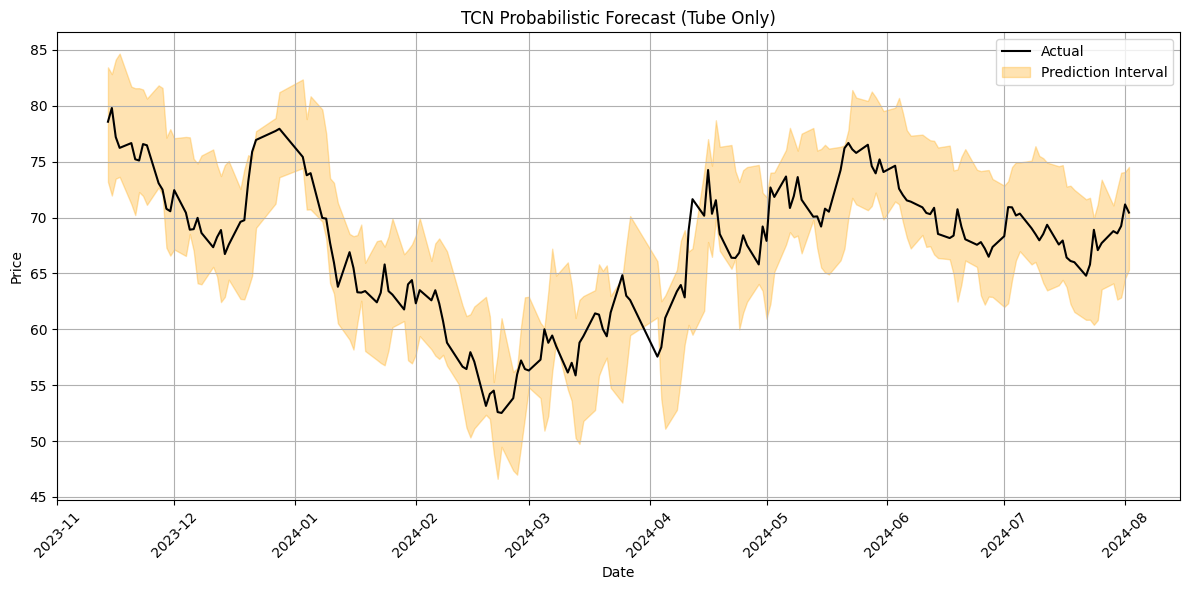


Final Evaluation:
PICP: 96.67%
MPIW: 9.8829


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import itertools

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- Load Data ---
def load_data(path):
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    df['Vol.'] = df['Vol.'].apply(lambda v: eval(v.replace('K','*1e3').replace('M','*1e6')) if isinstance(v, str) else np.nan)
    df['Change %'] = df['Change %'].str.replace('%','').astype(float)
    df['Price_lag1'] = df['Price'].shift(1)
    df['Vol_lag1'] = df['Vol.'].shift(1)
    df['Change_lag1'] = df['Change %'].shift(1)
    df.dropna(inplace=True)
    return df

def scale_features(df, features, target):
    scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
    X = scaler_X.fit_transform(df[features])
    y = scaler_y.fit_transform(df[[target]])
    return X, y, scaler_X, scaler_y

def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i-seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# --- TCN Layer ---
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout):
        super().__init__()
        padding = (kernel_size - 1) * dilation
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, dilation=dilation),
            nn.ReLU(),
            nn.BatchNorm1d(out_channels),
            nn.Dropout(dropout),
            nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding, dilation=dilation),
            nn.ReLU(),
            nn.BatchNorm1d(out_channels),
            nn.Dropout(dropout),
        )
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None

    def forward(self, x):
        out = self.conv(x)
        out = out[:, :, :x.size(2)]
        res = x if self.downsample is None else self.downsample(x)
        return out + res

class TCN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_blocks=2, kernel_size=3, dropout=0.0):
        super().__init__()
        layers = []
        for i in range(num_blocks):
            dilation = 2 ** i
            in_ch = input_dim if i == 0 else hidden_dim
            layers.append(TemporalBlock(in_ch, hidden_dim, kernel_size, dilation, dropout))
        self.network = nn.Sequential(*layers)
        self.output = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.network(x)
        return self.output(x[:, :, -1])

# --- Tube Loss ---
def confidence_loss(y_true, y_pred, q, r, delta):
    y_true = y_true[:, 0]
    f2 = y_pred[:, 0]  # upper
    f1 = y_pred[:, 1]  # lower

    c1 = (1 - q) * (f2 - y_true)
    c2 = (1 - q) * (y_true - f1)
    c3 = q * (f1 - y_true)
    c4 = q * (y_true - f2)

    cond_inside = (y_true <= f2) & (y_true >= f1)
    cond_y_gt_mid = y_true > r * (f1 + f2)
    cond_f1_gt_y = f1 > y_true

    loss_part1 = torch.where(cond_y_gt_mid, c1, c2)
    loss_part2 = torch.where(cond_f1_gt_y, c3, c4)
    loss = torch.where(cond_inside, loss_part1, loss_part2)
    loss += delta * torch.abs(f2 - f1)
    return torch.mean(loss)

# --- Training ---
def train_model(X_train, y_train, input_dim, hidden_dim, num_blocks, kernel_size,
                dropout, lr, epochs, q, r, delta):
    model = TCN(input_dim, hidden_dim, num_blocks, kernel_size, dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)

    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        loss = confidence_loss(y_train_t, model(X_train_t), q, r, delta)
        loss.backward()
        optimizer.step()
    return model

# --- Grid Search ---
def run_grid_search(X, y, scaler_y, param_grid, target_coverage=95):
    valid_models = []
    for values in itertools.product(*param_grid.values()):
        params = dict(zip(param_grid.keys(), values))
        print(f"\nTraining with params: {params}")

        X_seq, y_seq = create_sequences(X, y, params['seq_len'])
        split = int(0.8 * len(X_seq))
        X_train, X_test = X_seq[:split], X_seq[split:]
        y_train, y_test = y_seq[:split], y_seq[split:]
        y_test_rescaled = scaler_y.inverse_transform(y_test).flatten()

        model = train_model(X_train, y_train, X.shape[1],
                    params['hidden_dim'], params['num_blocks'],
                    params['kernel_size'], params['dropout'],
                    params['learning_rate'], params['epochs'],
                    params['q'], params['r'], params['delta'])

        model.eval()
        with torch.no_grad():
            y_pred = model(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()

        pred_upper, pred_lower = y_pred[:, 0], y_pred[:, 1]
        pred_lower, pred_upper = np.minimum(pred_lower, pred_upper), np.maximum(pred_lower, pred_upper)

        pred_lower_rescaled = scaler_y.inverse_transform(pred_lower.reshape(-1, 1)).flatten()
        pred_upper_rescaled = scaler_y.inverse_transform(pred_upper.reshape(-1, 1)).flatten()

        picp = np.mean((y_test_rescaled >= pred_lower_rescaled) & (y_test_rescaled <= pred_upper_rescaled)) * 100
        mpiw = np.mean(pred_upper_rescaled - pred_lower_rescaled)

        if picp >= target_coverage:
            print(f"✓ Accepted: PICP = {picp:.2f}% | MPIW = {mpiw:.4f}")
            valid_models.append((mpiw, params, pred_lower_rescaled, pred_upper_rescaled, y_test_rescaled))
        else:
            print(f"✗ Rejected: PICP = {picp:.2f}%")

    return sorted(valid_models, key=lambda x: x[0])

# --- Plot ---
def plot_results(dates, y_true, pred_lower, pred_upper):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_true, label='Actual', color='black')
    plt.fill_between(dates, pred_lower, pred_upper, color='orange', alpha=0.3, label='Prediction Interval')
    plt.title('TCN Probabilistic Forecast (Tube Only)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    df = load_data("/content/Carbon_Emissions_Futures_2021_Onwards.csv")
    features = ['Open', 'High', 'Low', 'Vol_lag1', 'Change_lag1', 'Price_lag1']
    target = 'Price'
    X, y, scaler_X, scaler_y = scale_features(df, features, target)

    param_grid = {
    'seq_len': [15,20],
    'hidden_dim': [64, 128],
    'kernel_size': [2],
    'num_blocks': [2],
    'dropout': [0.1],
    'learning_rate': [0.005],
    'epochs': [50],
    'q': [0.95],
    'r': [0.4,0.5,0.6],
    'delta': [0.0,0.05,0.1,0.2]
}

    valid_models = run_grid_search(X, y, scaler_y, param_grid)

    if not valid_models:
        raise ValueError("No model met the PICP threshold.")

    best_model = valid_models[0]
    _, best_params, pred_lower, pred_upper, y_true = best_model

    print("\nBest Hyperparameters:", best_params)
    plot_results(df['Date'].iloc[-len(y_true):], y_true, pred_lower, pred_upper)

    # --- Final Evaluation ---
    picp = np.mean((y_true >= pred_lower) & (y_true <= pred_upper)) * 100
    mpiw = np.mean(pred_upper - pred_lower)

    print(f"\nFinal Evaluation:")
    print(f"PICP: {picp:.2f}%")
    print(f"MPIW: {mpiw:.4f}")

### MDN

In [ ]:
# 1. Install necessary packages (if not already installed)
!pip install tensorflow tensorflow-probability pandas numpy matplotlib scikit-learn --quiet


Validation Set Evaluation:
PICP: 0.988, MPIW: 1.653, MPIW/PICP: 1.674

Test Set Evaluation:
PICP: 0.974, MPIW: 4.104, MPIW/PICP: 4.216


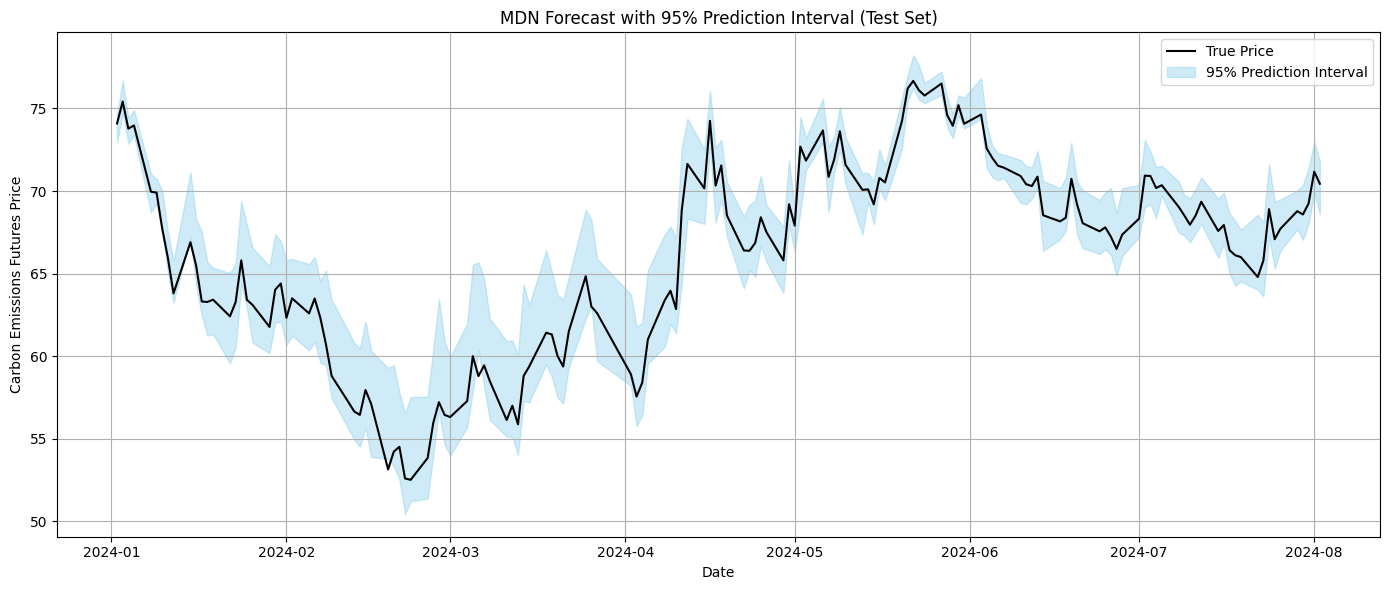

In [ ]:
# 1. Imports
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Input, Dense, Lambda, Concatenate
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

tfd = tfp.distributions

# 2. Load Data
df = pd.read_csv('/content/Carbon_Emissions_Futures_2021_Onwards.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# 3. Preprocessing
def parse_volume(vol):
    if isinstance(vol, str):
        vol = vol.replace(',', '')
        if 'K' in vol: return float(vol.replace('K', '')) * 1e3
        elif 'M' in vol: return float(vol.replace('M', '')) * 1e6
    return float(vol)

df['Vol.'] = df['Vol.'].apply(parse_volume)
df['Change %'] = df['Change %'].str.replace('%', '').astype(float)

df_model = df[['Date', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'Price']].copy()
for lag in range(1, 4):
    df_model[f'Price_lag_{lag}'] = df_model['Price'].shift(lag)
df_model.dropna(inplace=True)

# 4. Time-based Split
train_df = df_model[df_model['Date'] < '2023-09-01']
val_df = df_model[(df_model['Date'] >= '2023-09-01') & (df_model['Date'] < '2024-01-01')]
test_df = df_model[df_model['Date'].dt.year == 2024]

features = ['Open', 'High', 'Low', 'Vol.', 'Change %', 'Price_lag_1', 'Price_lag_2', 'Price_lag_3']
X_train, y_train = train_df[features].values, train_df['Price'].values.reshape(-1, 1)
X_val, y_val = val_df[features].values, val_df['Price'].values.reshape(-1, 1)
X_test, y_test = test_df[features].values, test_df['Price'].values.reshape(-1, 1)
dates_test = test_df['Date'].values

# 5. Scaling
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train).flatten()
y_val_scaled = scaler_y.transform(y_val).flatten()

# 6. MDN Setup
n_components = 3

def mdn_output_layer(x, n_components):
    params = Dense(n_components * 3)(x)
    logits = Lambda(lambda x: x[:, :n_components])(params)
    means = Lambda(lambda x: x[:, n_components:2 * n_components])(params)
    raw_stds = Lambda(lambda x: x[:, 2 * n_components:])(params)
    stds = Lambda(lambda s: tf.math.softplus(s) + 1e-6)(raw_stds)
    return Concatenate()([logits, means, stds])

def mdn_loss(n_components):
    def loss(y_true, y_pred):
        logits = y_pred[:, :n_components]
        means = y_pred[:, n_components:2 * n_components]
        stds = y_pred[:, 2 * n_components:]
        cat = tfd.Categorical(logits=logits)
        components = [tfd.Normal(loc=means[:, i], scale=stds[:, i]) for i in range(n_components)]
        gmm = tfd.Mixture(cat=cat, components=components)
        return -tf.reduce_mean(gmm.log_prob(y_true))
    return loss

# 7. Build and Train Model
inputs = Input(shape=(X_train.shape[1],))
x = Dense(64, activation='relu')(inputs)
x = Dense(64, activation='relu')(x)
outputs = mdn_output_layer(x, n_components)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss=mdn_loss(n_components))

model.fit(X_train, y_train_scaled,
          validation_data=(X_val, y_val_scaled),
          epochs=100, batch_size=32, verbose=0)

# 8. Inference Function
def predict_and_evaluate(X, y_true, scaler_y, n_components):
    pred_params = model.predict(X, verbose=0)
    logits = pred_params[:, :n_components]
    means = pred_params[:, n_components:2*n_components]
    stds = pred_params[:, 2*n_components:]

    cat = tfd.Categorical(logits=logits)
    components = [tfd.Normal(loc=means[:, i], scale=stds[:, i]) for i in range(n_components)]
    gmm = tfd.Mixture(cat=cat, components=components)

    samples = gmm.sample(1000).numpy()
    y_lower = np.percentile(samples, 2.5, axis=0)
    y_upper = np.percentile(samples, 97.5, axis=0)
    y_mean = gmm.mean().numpy()

    y_lower = scaler_y.inverse_transform(y_lower.reshape(-1, 1)).flatten()
    y_upper = scaler_y.inverse_transform(y_upper.reshape(-1, 1)).flatten()
    y_mean = scaler_y.inverse_transform(y_mean.reshape(-1, 1)).flatten()
    y_true = y_true.flatten()

    return y_true, y_lower, y_upper, y_mean

def compute_metrics(y_true, y_lower, y_upper):
    coverage = np.mean((y_true >= y_lower) & (y_true <= y_upper))
    mpiw = np.mean(y_upper - y_lower)
    ratio = mpiw / coverage if coverage > 0 else np.inf
    return coverage, mpiw, ratio

# 9. Evaluate on Validation Set
y_val_true, y_val_lower, y_val_upper, _ = predict_and_evaluate(X_val, y_val, scaler_y, n_components)
picp_val, mpiw_val, ratio_val = compute_metrics(y_val_true, y_val_lower, y_val_upper)
print(f'\nValidation Set Evaluation:')
print(f'PICP: {picp_val:.3f}, MPIW: {mpiw_val:.3f}, MPIW/PICP: {ratio_val:.3f}')

# 10. Evaluate on Test Set
y_test_true, y_test_lower, y_test_upper, y_test_mean = predict_and_evaluate(X_test, y_test, scaler_y, n_components)
picp_test, mpiw_test, ratio_test = compute_metrics(y_test_true, y_test_lower, y_test_upper)
print(f'\nTest Set Evaluation:')
print(f'PICP: {picp_test:.3f}, MPIW: {mpiw_test:.3f}, MPIW/PICP: {ratio_test:.3f}')

# 11. Plot
plt.figure(figsize=(14, 6))
plt.plot(dates_test, y_test_true, label='True Price', color='black')
plt.fill_between(dates_test, y_test_lower, y_test_upper, color='skyblue', alpha=0.4, label='95% Prediction Interval')
plt.title('MDN Forecast with 95% Prediction Interval (Test Set)')
plt.xlabel('Date')
plt.ylabel('Carbon Emissions Futures Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import itertools

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load data
df = pd.read_csv("/content/Carbon_Emissions_Futures_2021_Onwards.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# Convert volume
def convert_volume(vol):
    try:
        if isinstance(vol, str):
            vol = vol.replace('K', '*1e3').replace('M', '*1e6')
            return eval(vol)
        return np.nan
    except:
        return np.nan

df['Vol.'] = df['Vol.'].apply(convert_volume)
df['Change %'] = df['Change %'].str.replace('%', '').astype(float)
df['Price_lag1'] = df['Price'].shift(1)
df['Vol_lag1'] = df['Vol.'].shift(1)
df['Change_lag1'] = df['Change %'].shift(1)
df.dropna(inplace=True)

features = ['Open', 'High', 'Low', 'Vol_lag1', 'Change_lag1', 'Price_lag1']
target = 'Price'

# Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_X.fit_transform(df[features])
y = scaler_y.fit_transform(df[[target]])

# Sequence creation
def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i - seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# --- MDN Layer ---
class MDNLayer(nn.Module):
    def __init__(self, in_features, num_mixtures):
        super().__init__()
        self.pi = nn.Linear(in_features, num_mixtures)
        self.mu = nn.Linear(in_features, num_mixtures)
        self.sigma = nn.Linear(in_features, num_mixtures)

    def forward(self, x):
        pi = nn.functional.softmax(self.pi(x), dim=1)
        sigma = torch.exp(self.sigma(x)) + 1e-6
        mu = self.mu(x)
        return pi, mu, sigma

# --- RNN + MDN Model ---
class RNN_MDN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_mixtures):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.mdn = MDNLayer(hidden_dim, num_mixtures)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.mdn(out[:, -1, :])

# --- MDN Loss ---
def mdn_loss_fn(pi, mu, sigma, y):
    y = y.view(-1, 1)
    prob = torch.exp(-0.5 * ((y - mu) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))
    weighted_prob = pi * prob
    total_prob = torch.sum(weighted_prob, dim=1, keepdim=True)
    loss = -torch.log(total_prob + 1e-6).mean()
    return loss

# --- Sampling function ---
def sample_from_mdn(pi, mu, sigma, num_samples=10):
    batch_size, num_mixtures = pi.shape
    samples = []

    for _ in range(num_samples):
        # Sample mixture component for each item in batch
        categorical = torch.distributions.Categorical(pi)
        indices = categorical.sample()  # shape: (batch_size,)

        # Gather mu and sigma at sampled indices
        selected_mu = mu[torch.arange(batch_size), indices]
        selected_sigma = sigma[torch.arange(batch_size), indices]

        # Sample from normal
        normal_sample = torch.randn_like(selected_mu)
        sample = selected_mu + selected_sigma * normal_sample
        samples.append(sample.unsqueeze(0))  # shape: (1, batch_size)

    return torch.cat(samples, dim=0)  # shape: (num_samples, batch_size)


# --- Hyperparameter Grid ---
param_grid = {
    'seq_len': [2,4,6,8,10],
    'hidden_dim': [32, 64, 128],
    'num_layers': [1, 2, 3, 4],
    'learning_rate': [0.001],
    'epochs': [100],
    'batch_size': [32],
    'num_mixtures': [5]
}

# --- Training and Evaluation ---
target_coverage = 95
valid_models = []

for values in itertools.product(*param_grid.values()):
    params = dict(zip(param_grid.keys(), values))
    print(f"\nTraining with params: {params}")

    # Prepare data
    X_seq, y_seq = create_sequences(X, y, seq_len=params['seq_len'])
    split = int(0.8 * len(X_seq))
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]
    y_test_rescaled = scaler_y.inverse_transform(y_test).flatten()

    model = RNN_MDN(
        input_dim=X.shape[1],
        hidden_dim=params['hidden_dim'],
        num_layers=params['num_layers'],
        num_mixtures=params['num_mixtures']
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])

    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)

    # Train
    model.train()
    for epoch in range(params['epochs']):
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pi, mu, sigma = model(xb)
            loss = mdn_loss_fn(pi, mu, sigma, yb)
            loss.backward()
            optimizer.step()

    # Inference
    model.eval()
    X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
    with torch.no_grad():
        pi, mu, sigma = model(X_test_t)
        samples = sample_from_mdn(pi, mu, sigma, num_samples=10).cpu().numpy()

    pred_lower = np.percentile(samples, 2.5, axis=0)
    pred_upper = np.percentile(samples, 97.5, axis=0)
    pred_median = np.median(samples, axis=0)

    pred_lower_rescaled = scaler_y.inverse_transform(pred_lower.reshape(-1, 1)).flatten()
    pred_upper_rescaled = scaler_y.inverse_transform(pred_upper.reshape(-1, 1)).flatten()
    pred_median_rescaled = scaler_y.inverse_transform(pred_median.reshape(-1, 1)).flatten()

    # Metrics
    picp = np.mean((y_test_rescaled >= pred_lower_rescaled) & (y_test_rescaled <= pred_upper_rescaled)) * 100
    mpiw = np.mean(pred_upper_rescaled - pred_lower_rescaled)

    if picp >= target_coverage:
        print(f"✓ Accepted: PICP = {picp:.2f}% (≥ {target_coverage}) | MPIW = {mpiw:.4f}")
        valid_models.append((mpiw, params, pred_lower_rescaled, pred_upper_rescaled, pred_median_rescaled, y_test_rescaled))
    else:
        print(f"✗ Rejected: PICP = {picp:.2f}% (< {target_coverage})")

# --- Final Evaluation ---
if valid_models:
    valid_models.sort(key=lambda x: x[0])  # sort by MPIW
    _, best_params, pred_lower, pred_upper, pred_median, y_true = valid_models[0]

    mse = mean_squared_error(y_true, pred_median)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, pred_median)
    mape = np.mean(np.abs((y_true - pred_median) / y_true)) * 100
    r2 = r2_score(y_true, pred_median)
    picp = np.mean((y_true >= pred_lower) & (y_true <= pred_upper)) * 100
    mpiw = np.mean(pred_upper - pred_lower)

    print("\n✅ Best Hyperparameters:", best_params)
    print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R²: {r2:.4f}")
    print(f"PICP: {picp:.2f}% | MPIW: {mpiw:.4f}")

    # Plot
    test_dates = df['Date'].iloc[-len(y_true):]
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, y_true, label='Actual', color='black')
    plt.fill_between(test_dates, pred_lower, pred_upper, color='blue', alpha=0.3, label='Prediction Interval (95%)')
    plt.plot(test_dates, pred_median, label='Median Prediction', color='blue')
    plt.title('RNN + MDN Probabilistic Forecasting (Best Model)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("❌ No valid model met the coverage threshold.")


Using device: cpu

Training with params: {'seq_len': 2, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'num_mixtures': 5}
✗ Rejected: PICP = 80.87% (< 95)

Training with params: {'seq_len': 2, 'hidden_dim': 32, 'num_layers': 2, 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'num_mixtures': 5}
✗ Rejected: PICP = 73.22% (< 95)

Training with params: {'seq_len': 2, 'hidden_dim': 32, 'num_layers': 3, 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'num_mixtures': 5}
✗ Rejected: PICP = 77.05% (< 95)

Training with params: {'seq_len': 2, 'hidden_dim': 32, 'num_layers': 4, 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'num_mixtures': 5}
✗ Rejected: PICP = 81.42% (< 95)

Training with params: {'seq_len': 2, 'hidden_dim': 64, 'num_layers': 1, 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'num_mixtures': 5}
✗ Rejected: PICP = 74.32% (< 95)

Training with params: {'seq_len': 2, 'hidden_dim': 64, 'num_layers': 2,

### TimeGPT

In [ ]:
!pip install nixtlats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 kB 2.8 MB/s eta 0:00:00


In [ ]:
nixak-KYlGAOkA8e384H8KKhVSarDK163eklEP4a0fmQuukLtoI6PC8QMgZnITKqgVhkhF0fOaP4X2kX9WKMi5

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from nixtla import NixtlaClient

# Load and prepare data
df = pd.read_csv('/content/Carbon_Emissions_Futures_2021_Onwards.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df_gpt = df[['Date', 'Price']].rename(columns={'Date': 'ds', 'Price': 'y'})
df_gpt['unique_id'] = 'carbon_series'
df_gpt = df_gpt[['unique_id', 'ds', 'y']]
df_gpt = df_gpt.set_index('ds').resample('D').ffill().reset_index()
df_gpt['unique_id'] = 'carbon_series'
df_gpt = df_gpt[['unique_id', 'ds', 'y']]

# Parameters
initial_window = int(len(df_gpt) * 0.8)
horizon = 1
step = 1

# Initialize API
client = NixtlaClient(api_key='nixak-KYlGAOkA8e384H8KKhVSarDK163eklEP4a0fmQuukLtoI6PC8QMgZnITKqgVhkhF0fOaP4X2kX9WKMi5')

# Rolling Forecast + Evaluation
all_preds, all_actuals = [], []

for start in range(initial_window, len(df_gpt) - horizon, step):
    train = df_gpt.iloc[:start]
    test = df_gpt.iloc[start:start + horizon]

    forecast = client.forecast(df=train, h=horizon, freq='D')
    forecast['ds'] = pd.date_range(start=train['ds'].iloc[-1] + pd.Timedelta(days=1), periods=horizon, freq='D')
    pred_values = forecast[forecast.columns[-1]].values
    actual_values = test['y'].values

    all_preds.extend(pred_values)
    all_actuals.extend(actual_values)

# Convert to arrays
all_preds = np.array(all_preds)
all_actuals = np.array(all_actuals)

# --- Metrics ---
mse = mean_squared_error(all_actuals, all_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(all_actuals, all_preds)
mape = np.mean(np.abs((all_actuals - all_preds) / all_actuals)) * 100
r2 = r2_score(all_actuals, all_preds)

# Print metrics
print("Evaluation Metrics on Rolling Forecast:")
print(f"  MSE  : {mse:.4f}")
print(f"  RMSE : {rmse:.4f}")
print(f"  MAE  : {mae:.4f}")
print(f"  MAPE : {mape:.2f}%")
print(f"  R²   : {r2:.4f}")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df_gpt['ds'], df_gpt['y'], label='Actual', color='black')

# Generate rolling forecast date range to plot predictions
rolling_dates = df_gpt['ds'].iloc[initial_window:len(df_gpt) - horizon:step]
rolling_forecast_dates = []
for d in rolling_dates:
    rolling_forecast_dates.extend(pd.date_range(start=d, periods=horizon, freq='D'))
rolling_forecast_dates = rolling_forecast_dates[:len(all_preds)]  # ensure same length

plt.plot(rolling_forecast_dates, all_preds, label='Rolling Forecast', linestyle='--', color='blue')
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.title(f'Rolling Forecast with Evaluation (Horizon={horizon}, Step={step})')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Evaluation Metrics on Rolling Forecast:
  MSE  : 2.5401
  RMSE : 1.5938
  MAE  : 1.1499
  MAPE : 1.72%
  R²   : 0.9354


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from nixtla import NixtlaClient

# Load and prepare data
df = pd.read_csv('/content/Carbon_Emissions_Futures_2021_Onwards.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df_gpt = df[['Date', 'Price']].rename(columns={'Date': 'ds', 'Price': 'y'})
df_gpt['unique_id'] = 'carbon_series'
df_gpt = df_gpt[['unique_id', 'ds', 'y']]
df_gpt = df_gpt.set_index('ds').resample('D').ffill().reset_index()
df_gpt['unique_id'] = 'carbon_series'
df_gpt = df_gpt[['unique_id', 'ds', 'y']]

# Parameters
initial_window = int(len(df_gpt) * 0.8)
horizon = 1
step = 1
level = 95  # Confidence level for prediction intervals

# Initialize API
client = NixtlaClient(api_key='nixak-KYlGAOkA8e384H8KKhVSarDK163eklEP4a0fmQuukLtoI6PC8QMgZnITKqgVhkhF0fOaP4X2kX9WKMi5')  # Replace with your actual API key

# Rolling Forecast + Evaluation
all_preds = []
all_actuals = []
all_lowers = []
all_uppers = []
all_dates = []

for start in range(initial_window, len(df_gpt) - horizon + 1, step):
    train = df_gpt.iloc[:start]
    test = df_gpt.iloc[start:start + horizon]

    forecast = client.forecast(df=train, h=horizon, freq='D', level=[level])
    forecast['ds'] = pd.date_range(start=train['ds'].iloc[-1] + pd.Timedelta(days=1), periods=horizon, freq='D')

    # Extract forecasted values and prediction intervals
    pred_values = forecast['TimeGPT'].values
    lower_values = forecast[f'TimeGPT-lo-{level}'].values    # changed here
    upper_values = forecast[f'TimeGPT-hi-{level}'].values    # changed here
    actual_values = test['y'].values
    forecast_dates = forecast['ds'].values

    all_preds.extend(pred_values)
    all_actuals.extend(actual_values)
    all_lowers.extend(lower_values)
    all_uppers.extend(upper_values)
    all_dates.extend(forecast_dates)

# Convert to arrays
all_preds = np.array(all_preds)
all_actuals = np.array(all_actuals)
all_lowers = np.array(all_lowers)
all_uppers = np.array(all_uppers)
all_dates = np.array(all_dates)

# --- Metrics ---
# PICP: Proportion of actual values within the prediction intervals
picp = np.mean((all_actuals >= all_lowers) & (all_actuals <= all_uppers)) * 100

# MPIW: Mean width of the prediction intervals
mpiw = np.mean(all_uppers - all_lowers)

# Print metrics
print("Evaluation Metrics on Rolling Probabilistic Forecast:")
print(f"  PICP (95% Interval Coverage): {picp:.2f}%")
print(f"  MPIW (Mean Interval Width)  : {mpiw:.4f}")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df_gpt['ds'], df_gpt['y'], label='Actual', color='black')

# Plot prediction intervals
plt.fill_between(all_dates, all_lowers, all_uppers, color='blue', alpha=0.3, label='95% Prediction Interval')
plt.plot(all_dates, all_preds, label='Forecast Median', linestyle='--', color='blue')

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.title(f'Rolling Probabilistic Forecast (Horizon={horizon}, Step={step})')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Evaluation Metrics on Rolling Probabilistic Forecast:
  PICP (95% Interval Coverage): 88.55%
  MPIW (Mean Interval Width)  : 4.9172


## Not working

### Deep AR

In [ ]:
pip install gluonts pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.4 MB/s eta 0:00:00


In [ ]:
pip install --upgrade gluonts

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from gluonts.dataset.common import ListDataset
from gluonts.model.deepar import DeepAREstimator  # <--- Correct import for 0.16.1
from gluonts.trainer import Trainer
from gluonts.evaluation import Evaluator
import mxnet as mx

# Load data
df = pd.read_csv('/content/Carbon_Emissions_Futures_2021_Onwards.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Parameters
train_ratio = 0.8
forecast_horizon = 10  # Set your desired forecast horizon here
level = 0.95  # 95% confidence

# Prepare time series data
series = df[['Date', 'Price']].rename(columns={'Date': 'start', 'Price': 'target'})
series = series.set_index('start').asfreq('D').ffill().reset_index()

# Split train-test manually by train_ratio
train_len = int(len(series) * train_ratio)
train_series = series.iloc[:train_len]
test_series = series.iloc[train_len:train_len + forecast_horizon]

# Create GluonTS datasets
train_ds = ListDataset(
    [{"start": train_series['start'].iloc[0], "target": train_series['target'].values}],
    freq="D"
)
test_ds = ListDataset(
    [{"start": train_series['start'].iloc[0], "target": series['target'].values}],
    freq="D"
)

# Estimator and Trainer
estimator = DeepAREstimator(
    freq="D",
    prediction_length=forecast_horizon,
    trainer=Trainer(ctx="cpu", epochs=20, learning_rate=1e-3, hybridize=False),
)

predictor = estimator.train(training_data=train_ds)

# Forecast
forecast_it, ts_it = predictor.predict(test_ds), test_ds

# Get forecast and actuals
forecasts = list(forecast_it)
actuals = list(ts_it)

# Extract median forecast and prediction intervals
median_forecast = forecasts[0].median
lower_forecast = forecasts[0].quantile(0.5 - level / 2)
upper_forecast = forecasts[0].quantile(0.5 + level / 2)

# Dates for plotting
forecast_dates = pd.date_range(start=train_series['start'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_horizon)

# Actual values for the forecast horizon
actual_values = series['target'].iloc[train_len:train_len + forecast_horizon].values

# Compute PICP and MPIW
picp = np.mean((actual_values >= lower_forecast) & (actual_values <= upper_forecast)) * 100
mpiw = np.mean(upper_forecast - lower_forecast)

print(f"PICP (95% coverage): {picp:.2f}%")
print(f"MPIW (Mean prediction interval width): {mpiw:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(series['start'], series['target'], label='Actual', color='black')
plt.plot(forecast_dates, median_forecast, label='Forecast Median', linestyle='--', color='blue')
plt.fill_between(forecast_dates, lower_forecast, upper_forecast, color='blue', alpha=0.3, label='95% Prediction Interval')

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'DeepAR Forecast with {forecast_horizon}-Day Horizon')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'gluonts.model.deepar'

In [ ]:
import gluonts
print(gluonts.__version__)
!pip show gluonts


0.16.1
Name: gluonts
Version: 0.16.1
Summary: Probabilistic time series modeling in Python.
Home-page: https://github.com/awslabs/gluonts/
Author: Amazon
Author-email: gluon-ts-dev@amazon.com
License: Apache License 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: numpy, pandas, pydantic, toolz, tqdm, typing-extensions
Required-by: 


In [ ]:
import gluonts.model
print(dir(gluonts.model))

['Estimator', 'Forecast', 'IncrementallyTrainable', 'Input', 'InputSpec', 'Predictor', 'QuantileForecast', 'SampleForecast', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'estimator', 'evaluate_forecasts', 'evaluate_model', 'evaluation', 'forecast', 'inputs', 'predictor']


### N-BEATS

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from gluonts.dataset.common import ListDataset
from gluonts.torch.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.evaluation import Evaluator
import mxnet as mx

# Load data
df = pd.read_csv('/content/Carbon_Emissions_Futures_2021_Onwards.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Parameters
train_ratio = 0.8
forecast_horizon = 10  # Set your desired forecast horizon here
level = 0.95  # 95% confidence

# Prepare time series
series = df[['Date', 'Price']].rename(columns={'Date': 'start', 'Price': 'target'})
series = series.set_index('start').asfreq('D').ffill().reset_index()

# Split train/test
train_len = int(len(series) * train_ratio)
train_series = series.iloc[:train_len]
test_series = series.iloc[train_len:train_len + forecast_horizon]

# GluonTS datasets
train_ds = ListDataset(
    [{"start": train_series['start'].iloc[0], "target": train_series['target'].values}],
    freq="D"
)

test_ds = ListDataset(
    [{"start": train_series['start'].iloc[0], "target": series['target'].values}],
    freq="D"
)

# N-BEATS Estimator
estimator = NBEATSEstimator(
    freq="D",
    prediction_length=forecast_horizon,
    trainer=Trainer(ctx="cpu", epochs=20, learning_rate=1e-3)
)

predictor = estimator.train(training_data=train_ds)

# Forecast
forecast_it, ts_it = predictor.predict(test_ds), test_ds
forecasts = list(forecast_it)
actuals = list(ts_it)

# Extract forecast values
median_forecast = forecasts[0].median
lower_forecast = forecasts[0].quantile(0.5 - level / 2)
upper_forecast = forecasts[0].quantile(0.5 + level / 2)

# Dates for forecast plot
forecast_dates = pd.date_range(start=train_series['start'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_horizon)

# Ground truth values
actual_values = series['target'].iloc[train_len:train_len + forecast_horizon].values

# PICP and MPIW
picp = np.mean((actual_values >= lower_forecast) & (actual_values <= upper_forecast)) * 100
mpiw = np.mean(upper_forecast - lower_forecast)

print(f"PICP (95% coverage): {picp:.2f}%")
print(f"MPIW (Mean prediction interval width): {mpiw:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(series['start'], series['target'], label='Actual', color='black')
plt.plot(forecast_dates, median_forecast, label='Forecast Median', linestyle='--', color='blue')
plt.fill_between(forecast_dates, lower_forecast, upper_forecast, color='blue', alpha=0.3, label='95% Prediction Interval')
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'N-BEATS Forecast ({forecast_horizon}-Day Horizon)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'lightning'

# MDN with hyperparameter tuning

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical, Normal, MixtureSameFamily
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings

# Change device to CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
# Load your dataframe
df = pd.read_csv("/content/merged_df.csv")

# Parse date
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

# Convert Vol. and Change %
def parse_vol(vol):
    if isinstance(vol, str):
        vol = vol.replace(",", "")
        if "K" in vol:
            return float(vol.replace("K","")) * 1e3
        if "M" in vol:
            return float(vol.replace("M","")) * 1e6
    return float(vol)

df["Vol."] = df["Vol."].apply(parse_vol)
df["Change %"] = df["Change %"].astype(float)

# Show
df


Date  Carbon_Price_EUR   Open   High    Low     Vol.  Change %  \
0   2021-01-04             33.89  33.14  34.45  33.14   1250.0      2.88   
1   2021-01-05             33.15  33.69  33.83  32.96   1280.0     -2.18   
2   2021-01-06             33.83  33.71  33.88  33.02    430.0      2.05   
3   2021-01-07             34.97  34.05  35.00  34.05   1170.0      3.37   
4   2021-01-08             35.14  35.21  35.35  34.55   1600.0      0.49   
..         ...               ...    ...    ...    ...      ...       ...   
919 2024-07-29             68.78  67.70  68.90  67.20  16080.0      1.58   
920 2024-07-30             68.58  68.67  69.29  67.47  20660.0     -0.29   
921 2024-07-31             69.24  68.95  69.44  68.04  20380.0      0.96   
922 2024-08-01             71.17  69.55  71.50  68.83  29180.0      2.79   
923 2024-08-02             70.44  71.18  71.31  69.45  23240.0     -1.03   

     Crude_Oil_Price  EURUSD  Carbon_Price_USD  EuroNext100_Price  \
0              47.76  1.2248         41.508472            1112.52   
1              50.01  1.2294         40.754610            1109.56   
2              50.69  1.2325         41.695475            1120.23   
3              50.87  1.2270         42.908190            1122.13   
4              52.26  1.2218         42.934052            1132.10   
..               ...     ...               ...                ...   
919            74.80  1.0819         74.413082            1465.62   
920            73.88  1.0815         74.169270            1473.41   
921            76.84  1.0825         74.952300            1489.26   
922            75.40  1.0791         76.799547            1463.53   
923            72.59  1.0908         76.835952            1424.08   

     Total_MtCO2_per_day  Natural_Gas_Price  
0              18.327063              2.561  
1              18.811858              2.673  
2              19.171410              2.684  
3              19.889331              2.691  
4              20.891234              2.656  
..                   ...                ...  
919            13.891497              2.036  
920            14.055537              2.244  
921            14.211645              2.162  
922            14.353932              2.096  
923            14.362197              2.078  

[924 rows x 13 columns]

In [ ]:
df.drop(['Carbon_Price_EUR'], axis=1, inplace=True)

In [ ]:
def create_features(df, lag):
    features = [
        'Open', 'High', 'Low', 'Vol.', 'Change %',
        'Crude_Oil_Price', 'EURUSD',
        'EuroNext100_Price', 'Total_MtCO2_per_day',
        'Natural_Gas_Price'
    ]
    df_feat = df[["Date", "Carbon_Price_USD"] + features].copy()
    for l in range(1, lag+1):
        df_feat[f'Carbon_Price_USD_lag_{l}'] = df_feat["Carbon_Price_USD"].shift(l)
    df_feat.dropna(inplace=True)
    return df_feat, features + [f'Carbon_Price_USD_lag_{i}' for i in range(1, lag+1)]


In [ ]:
# Example lag to start (will change during tuning)
lag = 3

df_feat, feat_cols = create_features(df, lag)

# Train: <2023-09-01
# Val: 2023-09-01 to <2024-01-01
# Test: >=2024-01-01
train_df = df_feat[df_feat["Date"] < "2023-09-01"]
val_df = df_feat[(df_feat["Date"] >= "2023-09-01") & (df_feat["Date"] < "2024-01-01")]
test_df = df_feat[df_feat["Date"] >= "2024-01-01"]

print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))


Train size: 684
Val size: 84
Test size: 152


In [ ]:
# Split and scale
X_train = train_df[feat_cols].values
y_train = train_df["Carbon_Price_USD"].values.reshape(-1,1)
X_val = val_df[feat_cols].values
y_val = val_df["Carbon_Price_USD"].values.reshape(-1,1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)

y_train_scaled = scaler_y.fit_transform(y_train)

# Convert to tensors
X_train_t = torch.FloatTensor(X_train_scaled).to(device)
y_train_t = torch.FloatTensor(y_train_scaled).squeeze().to(device)
X_val_t = torch.FloatTensor(X_val_scaled).to(device)


In [ ]:
class MDN(nn.Module):
    def __init__(self, n_features, hidden_dims, n_mixtures):
        super(MDN, self).__init__()
        layers = []
        input_dim = n_features
        for h in hidden_dims:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU())
            input_dim = h
        self.hidden = nn.Sequential(*layers)
        self.pi = nn.Linear(input_dim, n_mixtures)
        self.mu = nn.Linear(input_dim, n_mixtures)
        self.sigma = nn.Linear(input_dim, n_mixtures)

    def forward(self, x):
        h = self.hidden(x)
        pi_logits = self.pi(h)
        mu = self.mu(h)
        sigma = F.softplus(self.sigma(h)) + 1e-6
        return pi_logits, mu, sigma

def mdn_loss(pi_logits, mu, sigma, y, sigma_penalty=0.0):
    mix = Categorical(logits=pi_logits)
    comp = Normal(mu, sigma)
    gmm = MixtureSameFamily(mix, comp)
    nll = -gmm.log_prob(y).mean()
    return nll + sigma_penalty * torch.mean(sigma)

def predict(model, X_tensor, y_true, scaler_y):
    model.eval()
    with torch.no_grad():
        pi, mu, sigma = model(X_tensor)
        mix = Categorical(logits=pi)
        comp = Normal(mu, sigma)
        gmm = MixtureSameFamily(mix, comp)
        samples = gmm.sample((1000,)).cpu().numpy()
        y_lower = scaler_y.inverse_transform(np.percentile(samples,2.5,axis=0).reshape(-1,1)).flatten()
        y_upper = scaler_y.inverse_transform(np.percentile(samples,97.5,axis=0).reshape(-1,1)).flatten()
        y_mean = scaler_y.inverse_transform(gmm.mean.cpu().numpy().reshape(-1,1)).flatten()
        y_true_flat = y_true.flatten()
        picp = np.mean((y_true_flat >= y_lower) & (y_true_flat <= y_upper))
        mpiw = np.mean(y_upper - y_lower)
    return y_true_flat, y_mean, y_lower, y_upper, picp, mpiw


In [ ]:
# Grid
lag_options = [12,13,14,15,16,17,18,19,20]
hidden_options = [[16, 16], [16, 32], [32, 32], [32, 64], [64, 64], [32, 32, 32], [64, 64, 64]]
mixture_options = [2,3,4,5,6,7]
sigma_penalty_options = [0.0,0.01, 0.05]

N_EPOCHS = 200
LR = 0.001


In [ ]:
# ─── Cell 8: Hyperparameter Tuning (MPIW only if PICP ≥ 95%) ───

best_params = {}
best_mpiw = float('inf')
best_picp = 0

for lag in lag_options:
    df_feat, feat_cols = create_features(df, lag)
    train_df = df_feat[df_feat["Date"] < "2023-09-01"]
    val_df   = df_feat[(df_feat["Date"] >= "2023-09-01") & (df_feat["Date"] < "2024-01-01")]

    X_train = train_df[feat_cols].values
    y_train = train_df["Carbon_Price_USD"].values.reshape(-1,1)
    X_val   = val_df[feat_cols].values
    y_val   = val_df["Carbon_Price_USD"].values.reshape(-1,1)

    # fit on train only
    sx = StandardScaler().fit(X_train)
    sy = StandardScaler().fit(y_train)

    X_train_t = torch.FloatTensor(sx.transform(X_train)).to(device)
    y_train_t = torch.FloatTensor(sy.transform(y_train)).squeeze().to(device)
    X_val_t   = torch.FloatTensor(sx.transform(X_val)).to(device)

    for hidden in hidden_options:
        for mix in mixture_options:
            for penalty in sigma_penalty_options:

                # init model & optimizer
                model = MDN(len(feat_cols), hidden, mix).to(device)
                opt   = optim.Adam(model.parameters(), lr=LR)

                # train
                for _ in range(N_EPOCHS):
                    model.train()
                    opt.zero_grad()
                    pi, mu, sigma = model(X_train_t)
                    loss = mdn_loss(pi, mu, sigma, y_train_t, sigma_penalty=penalty)
                    loss.backward()
                    opt.step()

                # evaluate PICP (and MPIW)
                _, _, _, _, picp, mpiw = predict(model, X_val_t, y_val, sy)

                # always print PICP, only print MPIW if picp≥0.95
                if picp >= 0.95:
                    print(f"Lag={lag}, Hidden={hidden}, Mix={mix}, Penalty={penalty} | PICP={picp:.4f}, MPIW={mpiw:.4f}")
                    # update best if narrower interval
                    if mpiw < best_mpiw:
                        best_params = {'lag':lag, 'hidden':hidden, 'mix':mix, 'penalty':penalty}
                        best_mpiw   = mpiw
                        best_picp   = picp
                        print("→ New best (meets PICP≥95% and lower MPIW)")

                else:
                    print(f"Lag={lag}, Hidden={hidden}, Mix={mix}, Penalty={penalty} | PICP={picp:.4f} (too low)")

print("Best Params:", best_params)
print(f"Best PICP: {best_picp:.4f}, Best MPIW: {best_mpiw:.4f}")


Lag=12, Hidden=[16, 16], Mix=2, Penalty=0.0 | PICP=1.0000, MPIW=8.6455
→ New best (meets PICP≥95% and lower MPIW)
Lag=12, Hidden=[16, 16], Mix=2, Penalty=0.01 | PICP=1.0000, MPIW=16.3552
Lag=12, Hidden=[16, 16], Mix=2, Penalty=0.05 | PICP=1.0000, MPIW=15.5761
Lag=12, Hidden=[16, 16], Mix=3, Penalty=0.0 | PICP=1.0000, MPIW=15.3542
Lag=12, Hidden=[16, 16], Mix=3, Penalty=0.01 | PICP=1.0000, MPIW=17.8862
Lag=12, Hidden=[16, 16], Mix=3, Penalty=0.05 | PICP=1.0000, MPIW=12.3094
Lag=12, Hidden=[16, 16], Mix=4, Penalty=0.0 | PICP=1.0000, MPIW=13.1887
Lag=12, Hidden=[16, 16], Mix=4, Penalty=0.01 | PICP=0.9167 (too low)
Lag=12, Hidden=[16, 16], Mix=4, Penalty=0.05 | PICP=1.0000, MPIW=13.2214
Lag=12, Hidden=[16, 16], Mix=5, Penalty=0.0 | PICP=1.0000, MPIW=12.8537
Lag=12, Hidden=[16, 16], Mix=5, Penalty=0.01 | PICP=1.0000, MPIW=12.4926
Lag=12, Hidden=[16, 16], Mix=5, Penalty=0.05 | PICP=1.0000, MPIW=17.0997
Lag=12, Hidden=[16, 16], Mix=6, Penalty=0.0 | PICP=0.9881, MPIW=15.8989
Lag=12, Hidden=[16

In [ ]:
df_feat, feat_cols = create_features(df, best_params["lag"])
trainval_df = df_feat[df_feat["Date"]<"2024-01-01"]
test_df = df_feat[df_feat["Date"]>="2024-01-01"]

X_train = trainval_df[feat_cols].values
y_train = trainval_df["Carbon_Price_USD"].values.reshape(-1,1)
X_test = test_df[feat_cols].values
y_test = test_df["Carbon_Price_USD"].values.reshape(-1,1)
dates_test = test_df["Date"].values

sx, sy = StandardScaler(), StandardScaler()
X_train_scaled = sx.fit_transform(X_train)
X_test_scaled = sx.transform(X_test)
y_train_scaled = sy.fit_transform(y_train)

X_train_t = torch.FloatTensor(X_train_scaled).to(device)
y_train_t = torch.FloatTensor(y_train_scaled).squeeze().to(device)
X_test_t = torch.FloatTensor(X_test_scaled).to(device)

model = MDN(X_train.shape[1],best_params["hidden"],best_params["mix"]).to(device)
opt = optim.Adam(model.parameters(), lr=LR)
for ep in range(N_EPOCHS+50):
    model.train()
    opt.zero_grad()
    pi, mu, sigma = model(X_train_t)
    loss = mdn_loss(pi, mu, sigma, y_train_t, sigma_penalty=best_params["penalty"])
    loss.backward()
    opt.step()
    if (ep+1)%50==0:
        print(f"Epoch {ep+1}, Loss={loss.item():.4f}")


Epoch 50, Loss=-0.0415
Epoch 100, Loss=-1.2024
Epoch 150, Loss=-1.6188
Epoch 200, Loss=-0.6494
Epoch 250, Loss=-1.8650


In [ ]:
# Train
y_true_tr, y_mean_tr, _, _, picp_tr, mpiw_tr = predict(model, X_train_t, y_train, sy)
print("Train PICP:",picp_tr,"MPIW:",mpiw_tr)

# Test
y_true_ts, y_mean_ts, y_lo_ts, y_hi_ts, picp_ts, mpiw_ts = predict(model, X_test_t, y_test, sy)
print("Test PICP:",picp_ts,"MPIW:",mpiw_ts)


Train PICP: 0.9630606860158312 MPIW: 3.8033714
Test PICP: 0.625 MPIW: 4.3283753


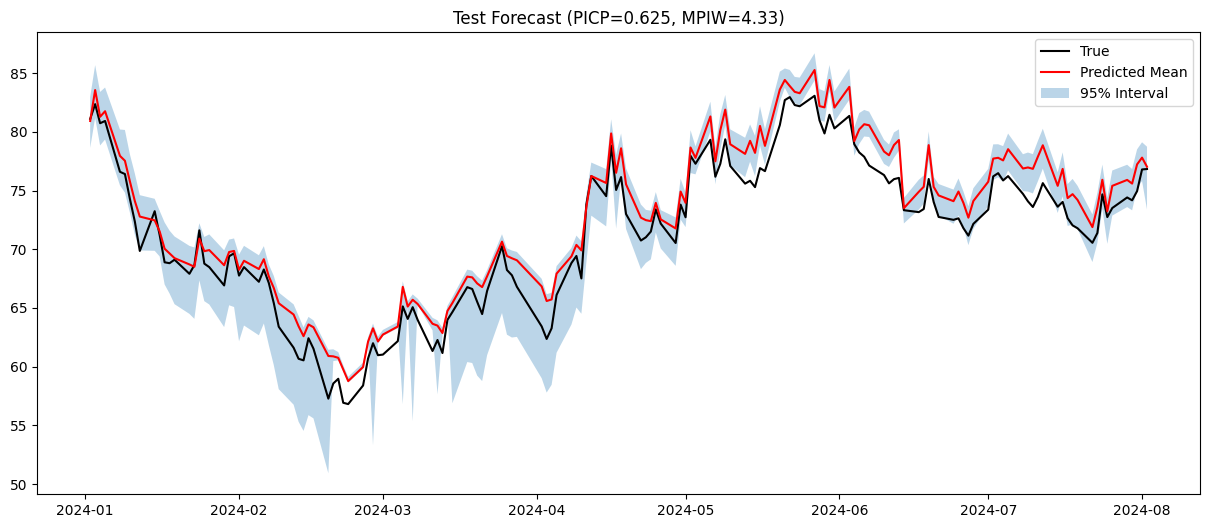

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(dates_test,y_true_ts,label="True",c='k')
plt.plot(dates_test,y_mean_ts,label="Predicted Mean",c='r')
plt.fill_between(dates_test,y_lo_ts,y_hi_ts,alpha=0.3,label="95% Interval")
plt.legend()
plt.title(f"Test Forecast (PICP={picp_ts:.3f}, MPIW={mpiw_ts:.2f})")
plt.show()


Using device: cuda
Lag=1, Hidden=16, Layers=1, Val PICP=0.773 (skipped)
Lag=1, Hidden=32, Layers=1, Val PICP=1.000, MPIW=16.850
*** New Best Model ***
Lag=2, Hidden=16, Layers=1, Val PICP=0.939 (skipped)
Lag=2, Hidden=32, Layers=1, Val PICP=0.985, MPIW=9.776
*** New Best Model ***
Best Params: {'lag': 2, 'hidden': 32, 'layers': 1}
Epoch 50, Loss 0.3726
Epoch 100, Loss 0.0266
Epoch 150, Loss 0.0161
Epoch 200, Loss 0.0149
Test PICP: 0.07236842105263158
Test MPIW: 7.2627163


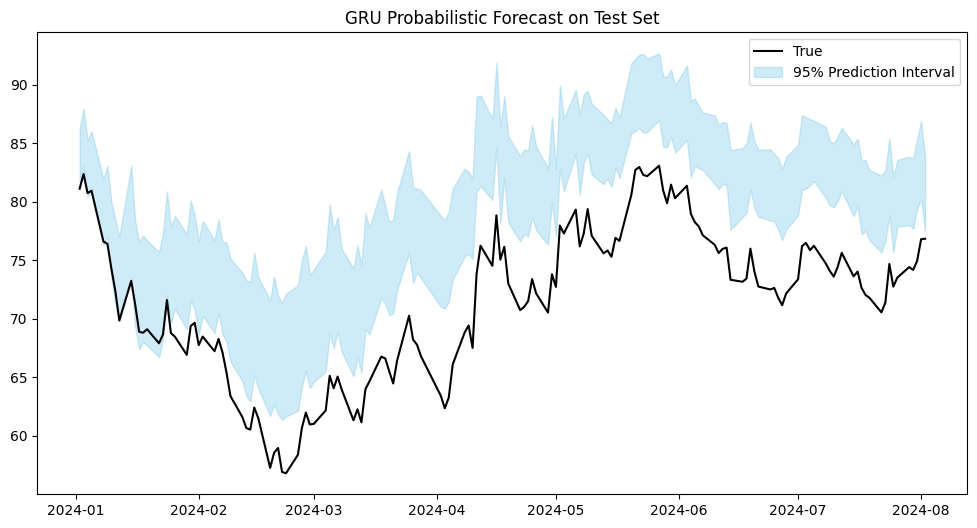

In [ ]:
# 1. Imports and Device
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 2. Data Load
df = pd.read_csv("/content/merged_df.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

# 3. Feature Creation
def create_features(df, lag):
    cols = ['Open','High','Low','Vol.','Change %','Crude_Oil_Price','EuroNext100_Price','Total_MtCO2_per_day','Natural_Gas_Price']
    df_feat = df[["Date","Carbon_Price_USD"] + cols].copy()
    for l in range(1, lag+1):
        df_feat[f"Carbon_lag_{l}"] = df_feat["Carbon_Price_USD"].shift(l)
    df_feat.dropna(inplace=True)
    feat_cols = cols + [f"Carbon_lag_{i}" for i in range(1, lag+1)]
    return df_feat, feat_cols

# 4. GRU Probabilistic Model
class GRUInterval(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(GRUInterval, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc_low = nn.Linear(hidden_dim, 1)
        self.fc_up = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.gru(x)
        lower = self.fc_low(out[:,-1,:])
        upper = self.fc_up(out[:,-1,:])
        return lower, upper

# 5. Quantile Loss
def quantile_loss(preds, target, q):
    errors = target - preds
    return torch.max(q*errors, (q-1)*errors).mean()

# 6. Hyperparameters
lag_options = [1,2]
hidden_options = [16,32]
layer_options = [1]
N_EPOCHS = 150
LR = 0.001

# 7. Tuning
best_params = {}
best_mpiw = float("inf")

for lag in lag_options:
    df_feat, feat_cols = create_features(df, lag)

    train_df = df_feat[df_feat["Date"] < "2023-06-01"]
    val_df = df_feat[(df_feat["Date"] >= "2023-06-01") & (df_feat["Date"] < "2023-09-01")]

    X_train = train_df[feat_cols].values
    y_train = train_df["Carbon_Price_USD"].values.reshape(-1,1)
    X_val = val_df[feat_cols].values
    y_val = val_df["Carbon_Price_USD"].values.reshape(-1,1)

    sx, sy = StandardScaler(), StandardScaler()
    X_train_scaled = sx.fit_transform(X_train)
    X_val_scaled = sx.transform(X_val)
    y_train_scaled = sy.fit_transform(y_train)
    y_val_scaled = sy.transform(y_val)

    X_train_t = torch.FloatTensor(X_train_scaled).unsqueeze(1).to(device)
    y_train_t = torch.FloatTensor(y_train_scaled).to(device)
    X_val_t = torch.FloatTensor(X_val_scaled).unsqueeze(1).to(device)

    for hidden in hidden_options:
        for layers in layer_options:
            model = GRUInterval(X_train.shape[1], hidden, layers).to(device)
            opt = optim.Adam(model.parameters(), lr=LR)

            for ep in range(N_EPOCHS):
                model.train()
                opt.zero_grad()
                l_pred, u_pred = model(X_train_t)
                loss_l = quantile_loss(l_pred, y_train_t, 0.025)
                loss_u = quantile_loss(u_pred, y_train_t, 0.975)
                loss = loss_l + loss_u
                loss.backward()
                opt.step()

            # Evaluate on Validation
            model.eval()
            with torch.no_grad():
                l_pred_v, u_pred_v = model(X_val_t)
                l_np = sy.inverse_transform(l_pred_v.cpu().numpy())
                u_np = sy.inverse_transform(u_pred_v.cpu().numpy())
                y_v = y_val.flatten()
                picp = np.mean((y_v >= l_np.flatten()) & (y_v <= u_np.flatten()))
                if picp >=0.95:
                    mpiw = np.mean(u_np - l_np)
                    print(f"Lag={lag}, Hidden={hidden}, Layers={layers}, Val PICP={picp:.3f}, MPIW={mpiw:.3f}")
                    if mpiw < best_mpiw:
                        best_params = {'lag':lag,'hidden':hidden,'layers':layers}
                        best_mpiw = mpiw
                        print("*** New Best Model ***")
                else:
                    print(f"Lag={lag}, Hidden={hidden}, Layers={layers}, Val PICP={picp:.3f} (skipped)")

print("Best Params:", best_params)

# 8. Retrain on Train+Val
df_feat, feat_cols = create_features(df, best_params["lag"])
trainval_df = df_feat[df_feat["Date"]<"2024-01-01"]
test_df = df_feat[df_feat["Date"]>="2024-01-01"]

X_trainval = trainval_df[feat_cols].values
y_trainval = trainval_df["Carbon_Price_USD"].values.reshape(-1,1)
X_test = test_df[feat_cols].values
y_test = test_df["Carbon_Price_USD"].values.reshape(-1,1)

sx_f, sy_f = StandardScaler(), StandardScaler()
X_trainval_scaled = sx_f.fit_transform(X_trainval)
X_test_scaled = sx_f.transform(X_test)
y_trainval_scaled = sy_f.fit_transform(y_trainval)

X_trainval_t = torch.FloatTensor(X_trainval_scaled).unsqueeze(1).to(device)
y_trainval_t = torch.FloatTensor(y_trainval_scaled).to(device)
X_test_t = torch.FloatTensor(X_test_scaled).unsqueeze(1).to(device)

model = GRUInterval(X_trainval.shape[1], best_params["hidden"], best_params["layers"]).to(device)
opt = optim.Adam(model.parameters(), lr=LR)

for ep in range(N_EPOCHS+50):
    model.train()
    opt.zero_grad()
    l_pred, u_pred = model(X_trainval_t)
    loss_l = quantile_loss(l_pred, y_trainval_t, 0.025)
    loss_u = quantile_loss(u_pred, y_trainval_t, 0.975)
    loss = loss_l + loss_u
    loss.backward()
    opt.step()
    if (ep+1)%50==0:
        print(f"Epoch {ep+1}, Loss {loss.item():.4f}")

# 9. Test Evaluation
model.eval()
with torch.no_grad():
    l_test, u_test = model(X_test_t)
    l_real = sy_f.inverse_transform(l_test.cpu().numpy()).flatten()
    u_real = sy_f.inverse_transform(u_test.cpu().numpy()).flatten()
    y_real = y_test.flatten()
    picp_test = np.mean((y_real >= l_real) & (y_real <= u_real))
    mpiw_test = np.mean(u_real - l_real)
    print("Test PICP:", picp_test)
    print("Test MPIW:", mpiw_test)

# 10. Plot
plt.figure(figsize=(12,6))
plt.plot(test_df["Date"], y_real, label="True", color="black")
plt.fill_between(test_df["Date"], l_real, u_real, color="skyblue", alpha=0.4, label="95% Prediction Interval")
plt.title("GRU Probabilistic Forecast on Test Set")
plt.legend()
plt.show()
